# 0. 라이브러리 및 데이터

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm import tqdm_notebook

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/sample_submission.csv')

# id : 구분자
# rho : 측정 거리 (단위: mm)
# src : 광원 스펙트럼 (650 nm ~ 990 nm)
# dst : 측정 스펙트럼 (650 nm ~ 990 nm)

# hhb : 디옥시헤모글로빈 농도
# hbo2 : 옥시헤모글로빈 농도
# ca : 칼슘 농도
# na : 나트륨 농도

In [3]:
train.head()

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,...,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst,hhb,hbo2,ca,na
0,0,25,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,...,NaN,0.000000e+00,NaN,1.067504e-18,5.998949e-18,4.378513e-17,5.59,4.32,8.92,4.29
1,1,10,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,...,1.343132e-08,6.112685e-09,2.130547e-09,NaN,9.710091e-09,NaN,0.00,2.83,7.25,4.64
2,2,25,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.329725e-18,NaN,10.64,3.00,8.40,5.16
3,3,10,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,...,2.245998e-10,1.299511e-10,7.782625e-11,NaN,4.088921e-10,NaN,5.67,4.01,5.05,4.35
4,4,15,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,...,1.457955e-13,8.769053e-14,NaN,1.330237e-13,NaN,NaN,11.97,4.41,10.78,2.42


In [4]:
test.head()

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,...,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
0,10000,15,0.15406,0.23275,0.30977,0.42949,0.51264,0.62558,0.74340,0.85418,...,0.000000e+00,0.000000e+00,1.432248e-14,0.000000e+00,0.000000e+00,6.332117e-15,1.429966e-14,0.000000e+00,NaN,7.320236e-14
1,10001,15,0.48552,0.56939,0.67575,0.79089,0.85114,0.92581,0.98071,0.98177,...,1.036013e-13,NaN,2.830975e-14,1.114337e-13,4.825731e-14,NaN,2.282485e-14,7.348414e-14,1.259055e-13,2.349874e-13
2,10002,10,0.46883,0.56085,0.62442,0.73172,0.81724,0.91517,0.94801,0.99108,...,NaN,NaN,NaN,NaN,1.569208e-11,6.242378e-12,NaN,1.219010e-11,NaN,NaN
3,10003,10,0.06905,0.07517,0.10226,0.14905,0.16182,0.19659,0.26085,0.36753,...,1.651177e-11,7.282747e-12,5.010879e-12,NaN,1.571023e-11,0.000000e+00,0.000000e+00,3.304247e-12,4.106134e-11,NaN
4,10004,25,0.00253,0.00757,0.01649,0.00128,0.00000,0.00000,0.00105,0.01975,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.732057e-17,4.110605e-17,0.000000e+00,0.000000e+00,1.910775e-16,2.215673e-15


In [5]:
print ("Size of train data : {}" .format(train.shape))
print ("Size of test data : {}" .format(test.shape))

Size of train data : (10000, 76)
Size of test data : (10000, 72)


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 76 columns):
id         10000 non-null int64
rho        10000 non-null int64
650_src    10000 non-null float64
660_src    10000 non-null float64
670_src    10000 non-null float64
680_src    10000 non-null float64
690_src    10000 non-null float64
700_src    10000 non-null float64
710_src    10000 non-null float64
720_src    10000 non-null float64
730_src    10000 non-null float64
740_src    10000 non-null float64
750_src    10000 non-null float64
760_src    10000 non-null float64
770_src    10000 non-null float64
780_src    10000 non-null float64
790_src    10000 non-null float64
800_src    10000 non-null float64
810_src    10000 non-null float64
820_src    10000 non-null float64
830_src    10000 non-null float64
840_src    10000 non-null float64
850_src    10000 non-null float64
860_src    10000 non-null float64
870_src    10000 non-null float64
880_src    10000 non-null float64
890_src    1

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 72 columns):
id         10000 non-null int64
rho        10000 non-null int64
650_src    10000 non-null float64
660_src    10000 non-null float64
670_src    10000 non-null float64
680_src    10000 non-null float64
690_src    10000 non-null float64
700_src    10000 non-null float64
710_src    10000 non-null float64
720_src    10000 non-null float64
730_src    10000 non-null float64
740_src    10000 non-null float64
750_src    10000 non-null float64
760_src    10000 non-null float64
770_src    10000 non-null float64
780_src    10000 non-null float64
790_src    10000 non-null float64
800_src    10000 non-null float64
810_src    10000 non-null float64
820_src    10000 non-null float64
830_src    10000 non-null float64
840_src    10000 non-null float64
850_src    10000 non-null float64
860_src    10000 non-null float64
870_src    10000 non-null float64
880_src    10000 non-null float64
890_src    1

# 1. 탐색적 자료 분석

## 1.1 결측치 확인

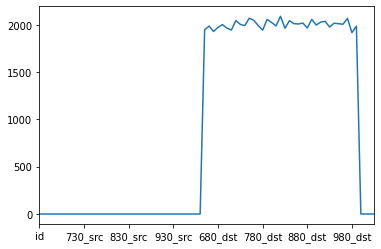

In [8]:
train.isnull().sum().plot()

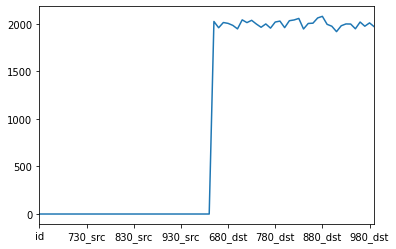

In [9]:
test.isnull().sum().plot()

In [10]:
print(train.isnull().sum()[train.isnull().sum().values > 0].index)

Index(['650_dst', '660_dst', '670_dst', '680_dst', '690_dst', '700_dst',
       '710_dst', '720_dst', '730_dst', '740_dst', '750_dst', '760_dst',
       '770_dst', '780_dst', '790_dst', '800_dst', '810_dst', '820_dst',
       '830_dst', '840_dst', '850_dst', '860_dst', '870_dst', '880_dst',
       '890_dst', '900_dst', '910_dst', '920_dst', '930_dst', '940_dst',
       '950_dst', '960_dst', '970_dst', '980_dst', '990_dst'],
      dtype='object')


In [11]:
print(test.isnull().sum()[test.isnull().sum().values > 0].index)

Index(['650_dst', '660_dst', '670_dst', '680_dst', '690_dst', '700_dst',
       '710_dst', '720_dst', '730_dst', '740_dst', '750_dst', '760_dst',
       '770_dst', '780_dst', '790_dst', '800_dst', '810_dst', '820_dst',
       '830_dst', '840_dst', '850_dst', '860_dst', '870_dst', '880_dst',
       '890_dst', '900_dst', '910_dst', '920_dst', '930_dst', '940_dst',
       '950_dst', '960_dst', '970_dst', '980_dst', '990_dst'],
      dtype='object')


## 1.2 데이터의 의미 파악

### 1.2.1 광원 스펙트럼

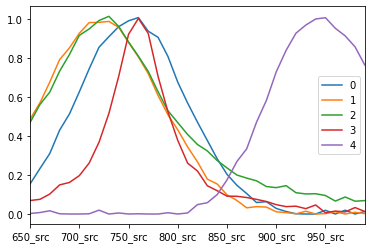

In [12]:
test.filter(regex='_src$', axis=1).head().T.plot()

### 1.2.2 측정 스펙트럼

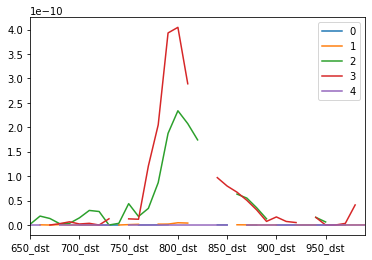

In [13]:
test.filter(regex='_dst$', axis=1).head().T.plot()

# 2. 데이터 정리

## 2.1 결측치 보간

In [14]:
# interpolate():실측값과 실측값 사이의 결측값을 마치 '그라데이션(gradation)' 기법으로 색깔을 조금씩 변화시켜가면서 부드럽게 채워나가는 방법
train = train.interpolate(method='linear', axis=1)
test = test.interpolate(method='linear', axis=1)

test.head()

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,...,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
0,10000.0,15.0,0.15406,0.23275,0.30977,0.42949,0.51264,0.62558,0.74340,0.85418,...,0.000000e+00,0.000000e+00,1.432248e-14,0.000000e+00,0.000000e+00,6.332117e-15,1.429966e-14,0.000000e+00,3.660118e-14,7.320236e-14
1,10001.0,15.0,0.48552,0.56939,0.67575,0.79089,0.85114,0.92581,0.98071,0.98177,...,1.036013e-13,6.595554e-14,2.830975e-14,1.114337e-13,4.825731e-14,3.554108e-14,2.282485e-14,7.348414e-14,1.259055e-13,2.349874e-13
2,10002.0,10.0,0.46883,0.56085,0.62442,0.73172,0.81724,0.91517,0.94801,0.99108,...,1.325728e-11,1.386598e-11,1.447468e-11,1.508338e-11,1.569208e-11,6.242378e-12,9.216241e-12,1.219010e-11,1.219010e-11,1.219010e-11
3,10003.0,10.0,0.06905,0.07517,0.10226,0.14905,0.16182,0.19659,0.26085,0.36753,...,1.651177e-11,7.282747e-12,5.010879e-12,1.036055e-11,1.571023e-11,0.000000e+00,0.000000e+00,3.304247e-12,4.106134e-11,4.106134e-11
4,10004.0,25.0,0.00253,0.00757,0.01649,0.00128,0.00000,0.00000,0.00105,0.01975,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.732057e-17,4.110605e-17,0.000000e+00,0.000000e+00,1.910775e-16,2.215673e-15


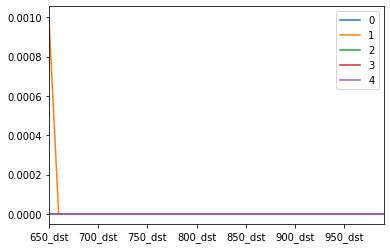

In [15]:
test.filter(regex='_dst$', axis=1).head().T.plot()

# 3. 데이터 전처리

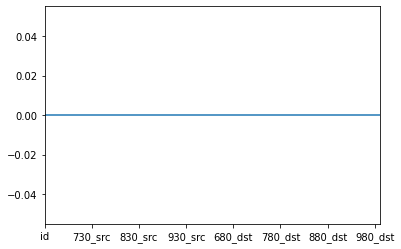

In [16]:
test.isnull().sum().plot()

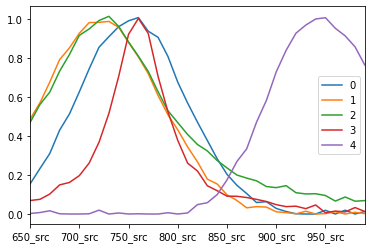

In [17]:
test.filter(regex='_src$', axis=1).head().T.plot()

## 3.1 상관관계 분석

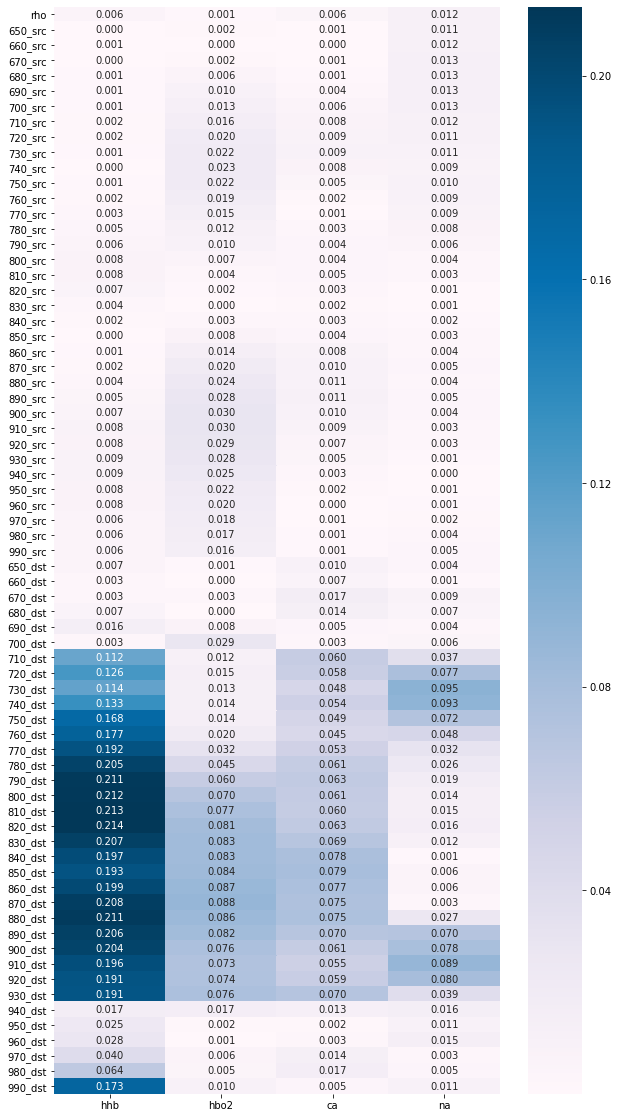

In [18]:
plt.figure(figsize=(10,20))
sns.heatmap(train.corr().loc['rho':'990_dst', 'hhb':].abs(), fmt='.3f', annot=True, cmap='PuBu')

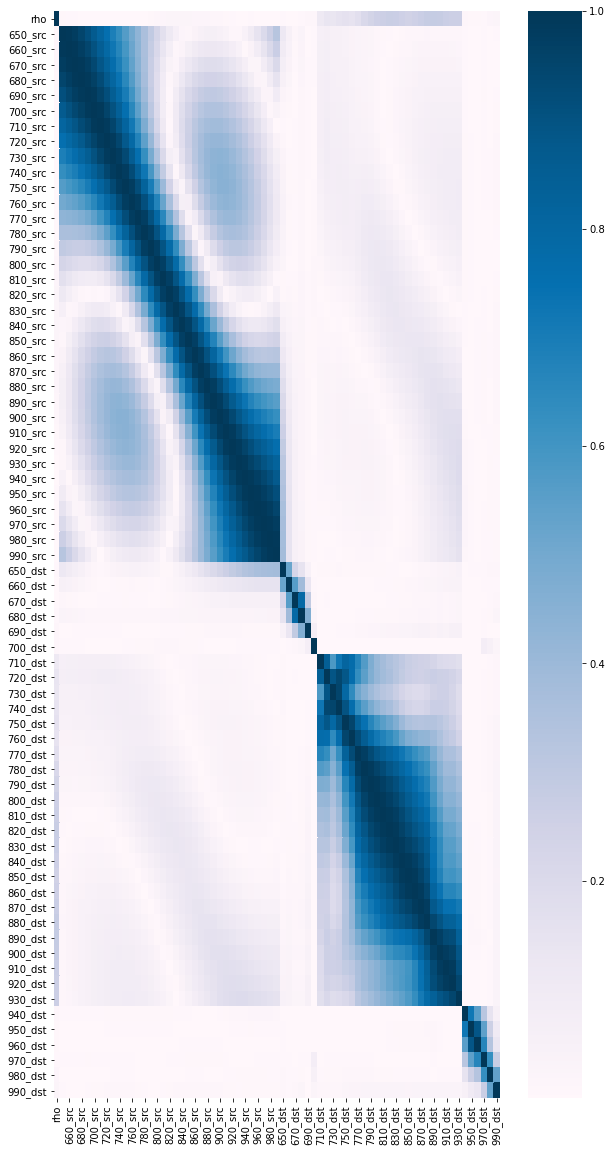

In [19]:
plt.figure(figsize=(10, 20))
sns.heatmap(train.corr().loc['rho':'990_dst', 'rho':'990_dst'].abs(), cmap='PuBu')

## 이상치 제거

In [20]:
# columns = train.columns.drop('id')
# sns.set()
# for col in columns:
#     fig,ax = plt.subplots(1, 1, figsize=(20,4))
#     sns.distplot(train[col])

In [21]:
# # IQR을 이용하여 이상치 탐색
# # https://hong-yp-ml-records.tistory.com/15?category=819005

# from collections import Counter 

# def detect_outliers(df, n, features): 
#     outlier_indices = []
    
#     for col in features: 
#         Q1 = np.percentile(df[col], 25)
#         Q3 = np.percentile(df[col], 75) 
#         IQR = Q3 - Q1
                
#         outlier_step = 1.5 * IQR
#         outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index 
#         outlier_indices.extend(outlier_list_col) 
    
#     outlier_indices = Counter(outlier_indices) 
#     multiple_outliers = list(k for k, v in outlier_indices.items() if v > n) 
    
#     return multiple_outliers 

In [22]:
# train_Outliers = detect_outliers(train, 2, columns)
# train.loc[train_Outliers]

- 이상치가 포함된 데이터가 너무 많음
- 상관관계 분석에서 target에 영향을 미치는 column만 다시 이상치 탐색해보자

In [23]:
# columns_dst = train.filter(regex='_dst$', axis=1).columns
# train_Outliers_dst = detect_outliers(train, 2, columns_dst)

# train.loc[train_Outliers_dst]

## 다중공선성

In [24]:
feature_columns = list(train.columns.difference(['id','hhb','hbo2','ca','na']))
X_train = train[feature_columns]

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['features'] = X_train.columns

vif.sort_values(by='VIF Factor', ascending=False)

,VIF Factor,features
33,1660.044156,810_src
29,1648.009709,790_src
41,1639.554030,850_src
37,1636.191962,830_src
27,1633.658288,780_src
...,...,...
2,1.973573,660_dst
0,1.701240,650_dst
68,1.696264,990_dst
8,1.348957,690_dst


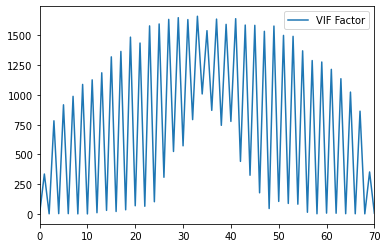

In [26]:
vif.plot()

In [27]:
# _src 변수끼리 다중공선성 확인
X_train2 = train.loc[:, '650_src':'990_src']
vif2 = pd.DataFrame()
vif2['VIF Factor'] = [variance_inflation_factor(X_train2.values, i) for i in range(X_train2.shape[1])]
vif2['features'] = X_train2.columns

vif2.sort_values(by='VIF Factor', ascending=False)

,VIF Factor,features
16,1641.691277,810_src
14,1635.053032,790_src
13,1625.251552,780_src
20,1623.180937,850_src
15,1616.884069,800_src
18,1612.500522,830_src
12,1589.024430,770_src
19,1575.291222,840_src
11,1572.640161,760_src
24,1571.971326,890_src


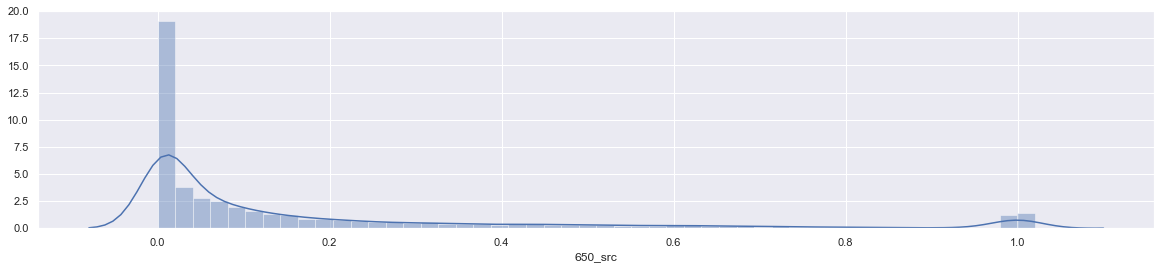

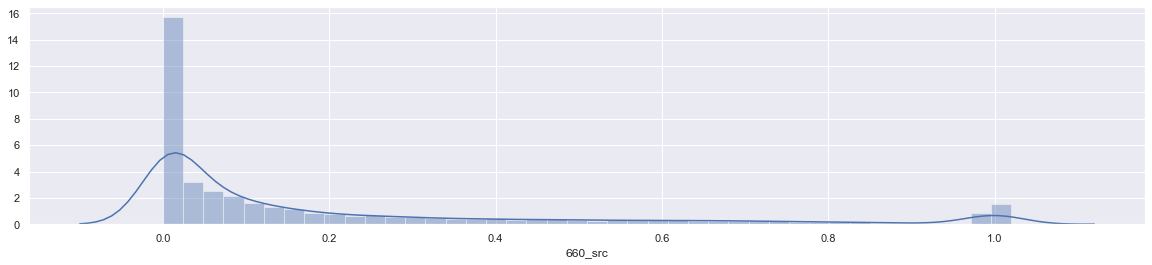

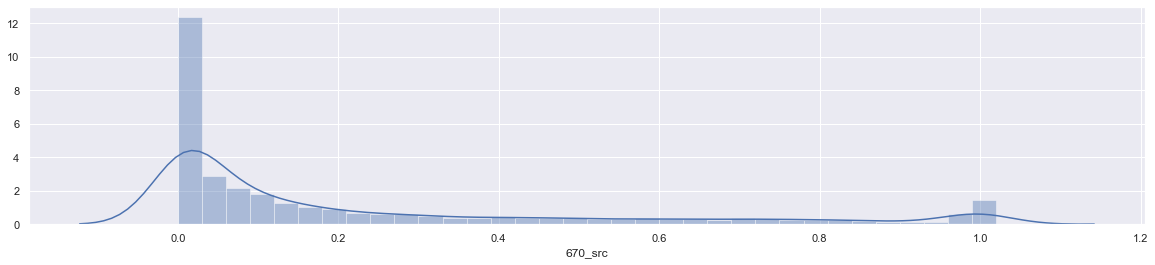

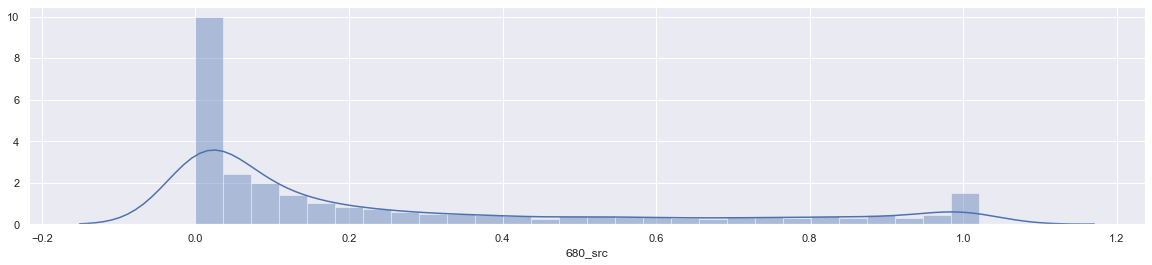

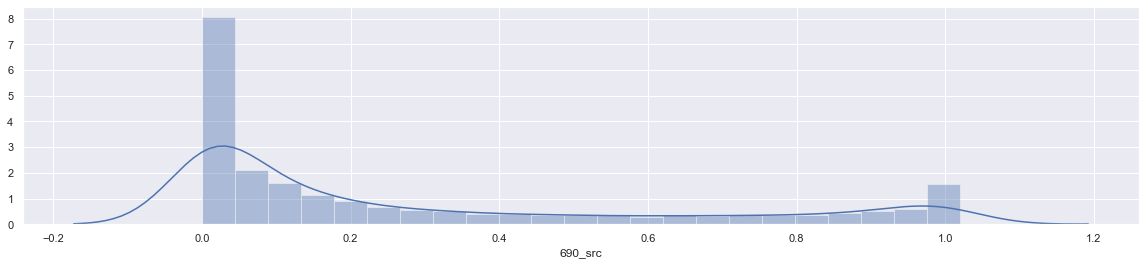

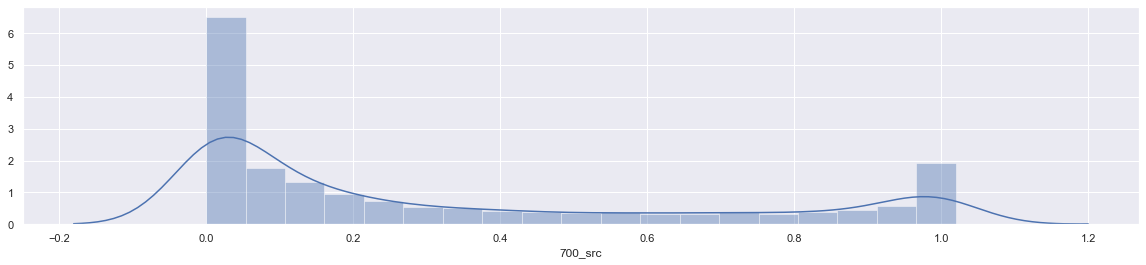

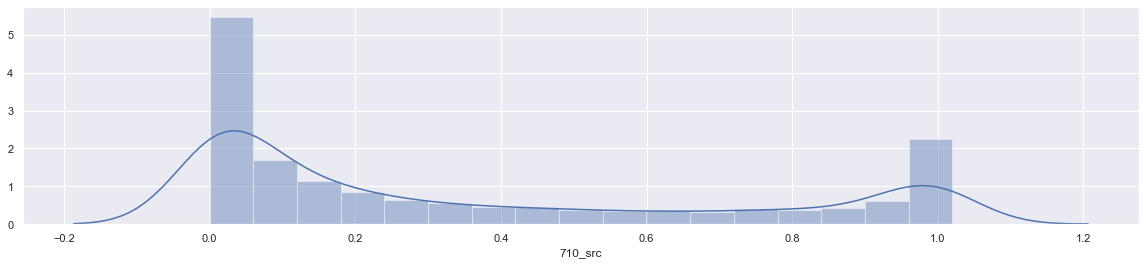

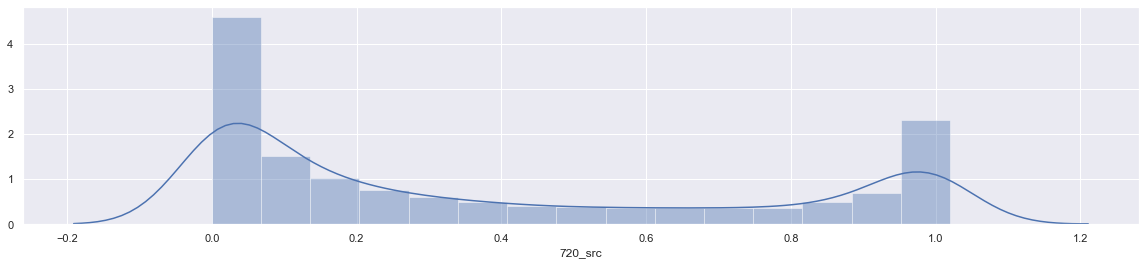

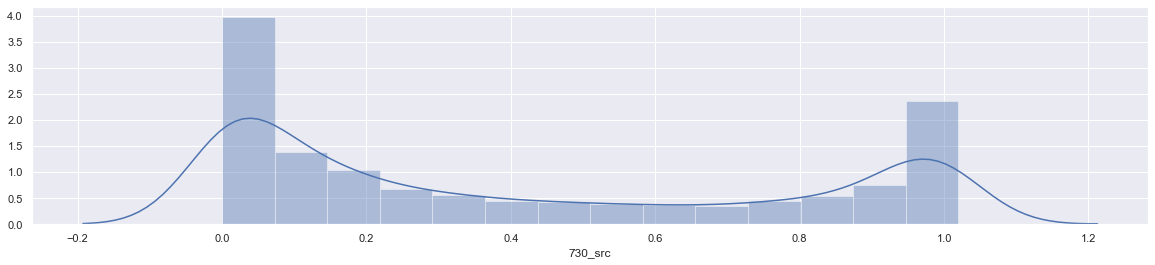

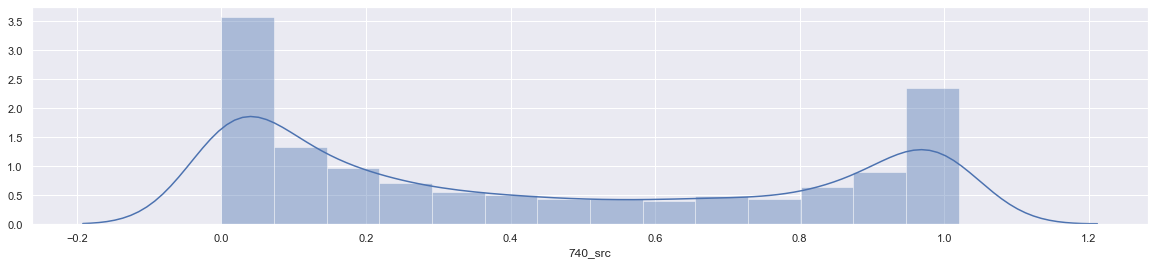

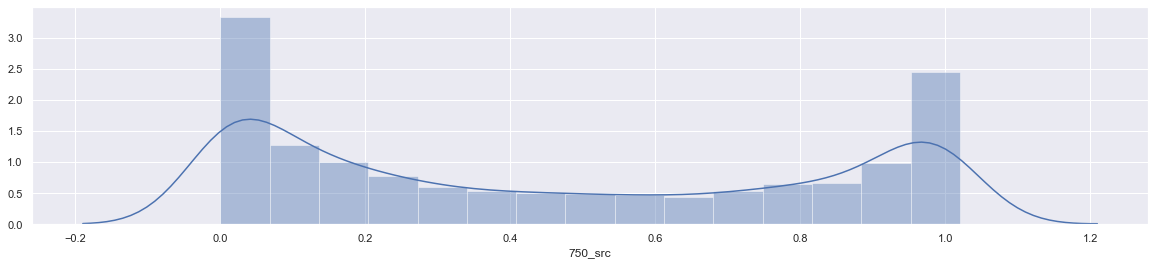

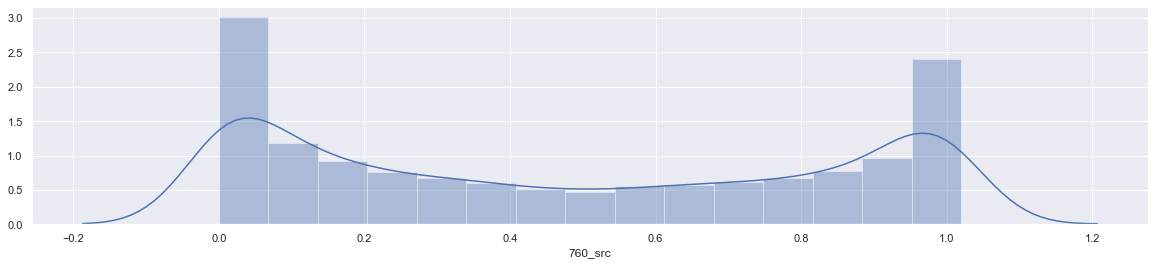

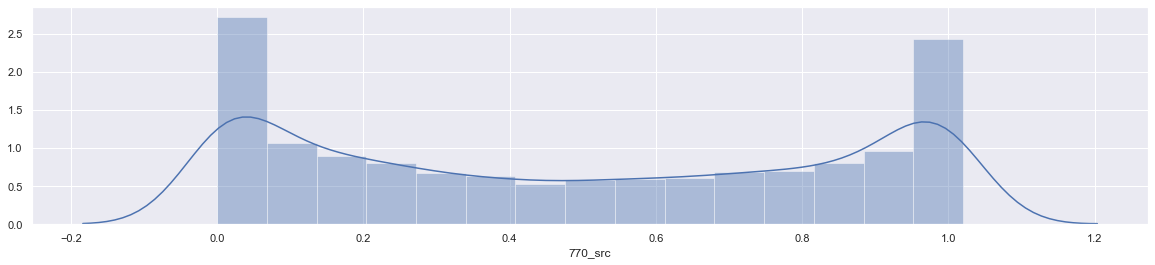

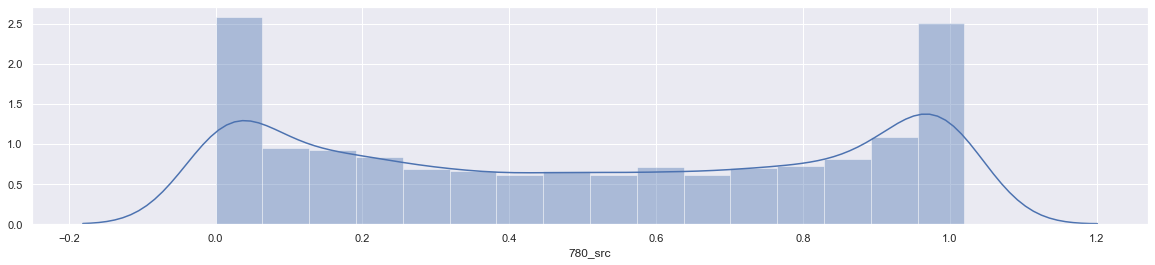

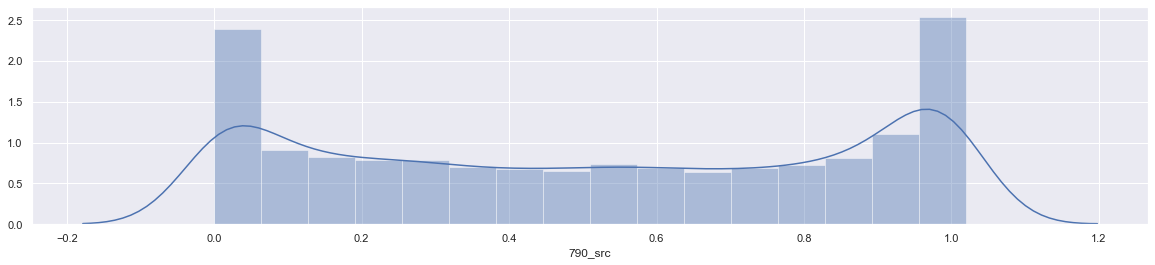

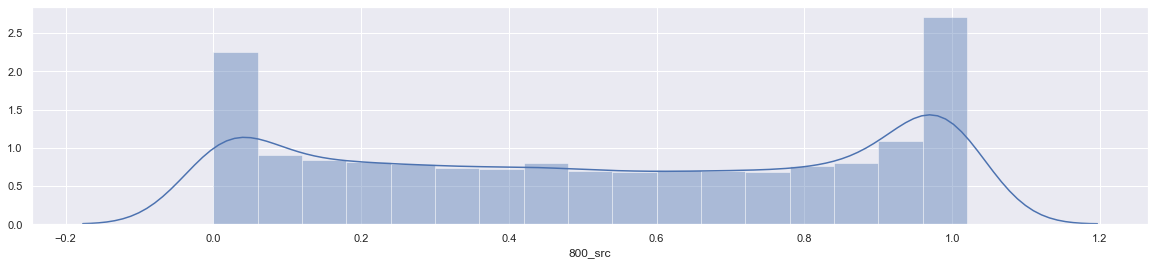

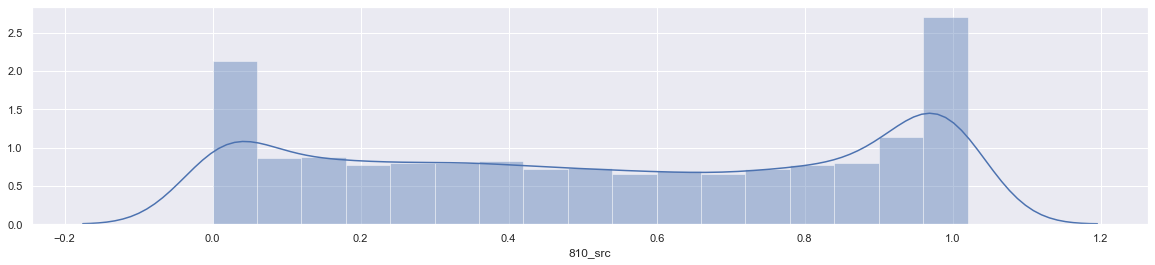

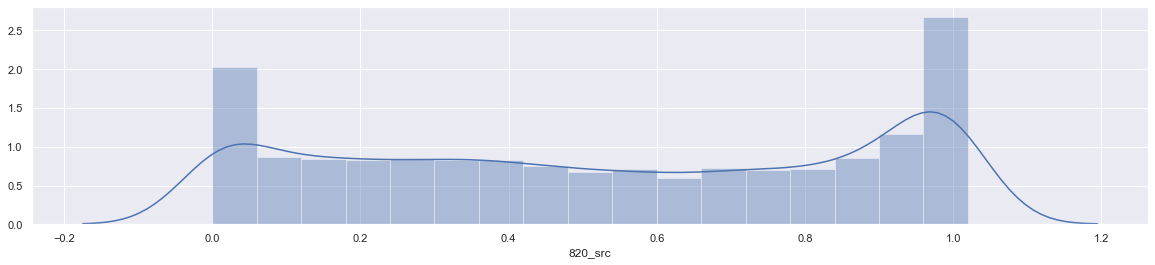

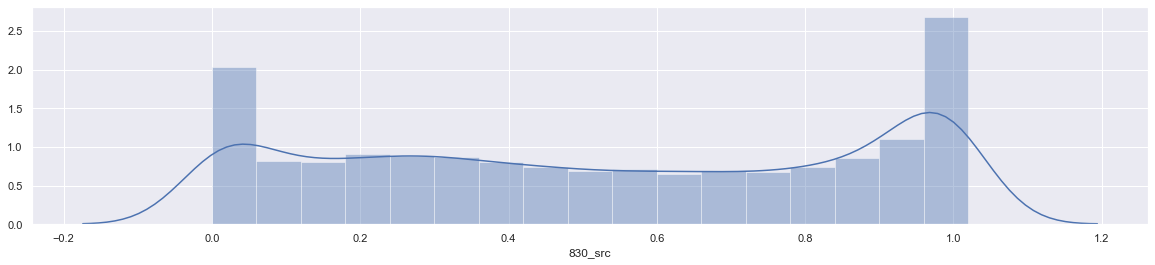

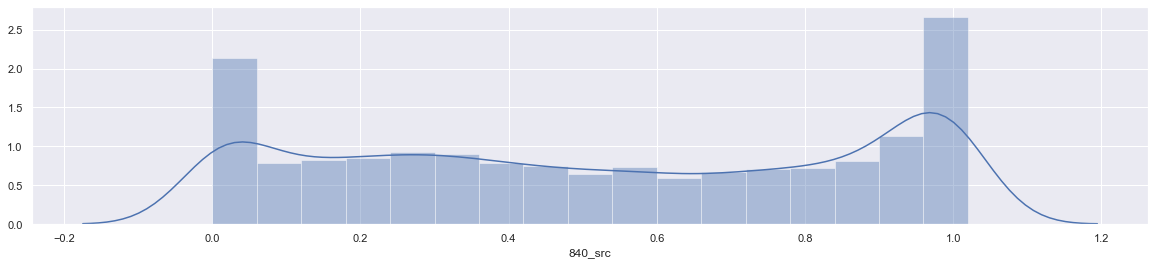

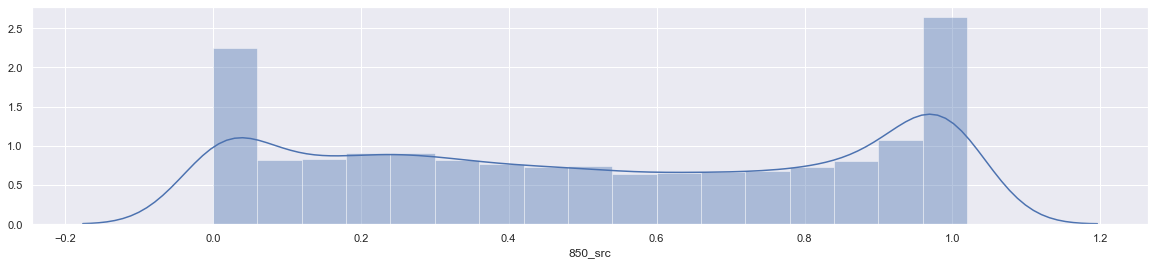

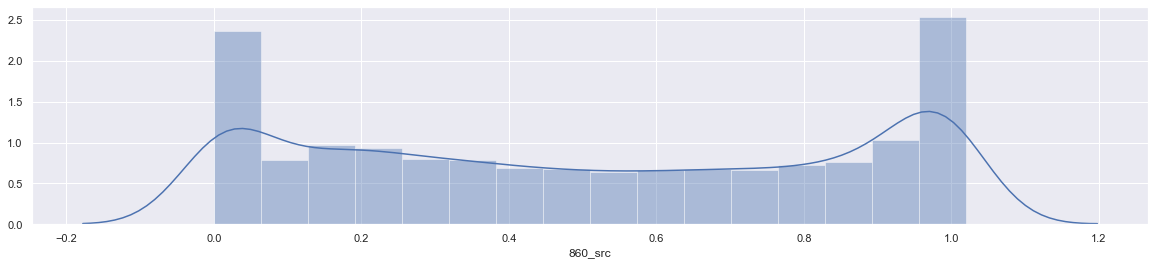

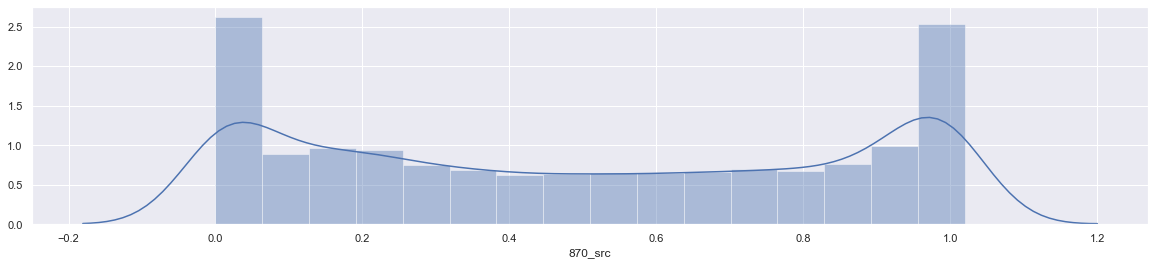

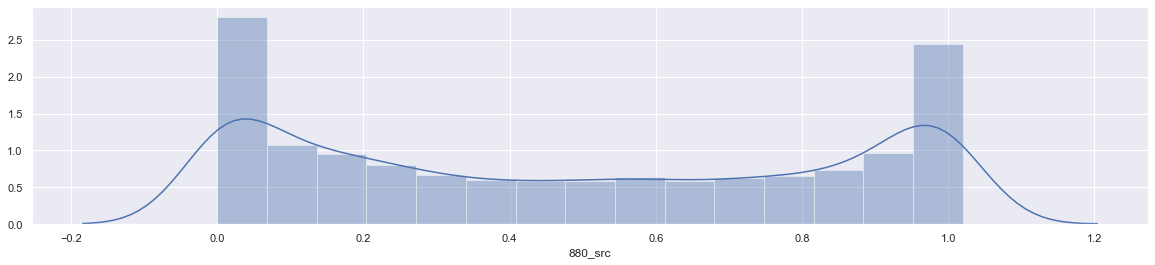

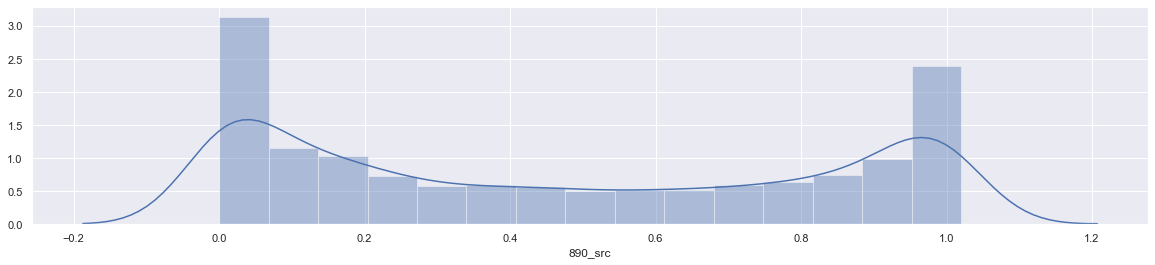

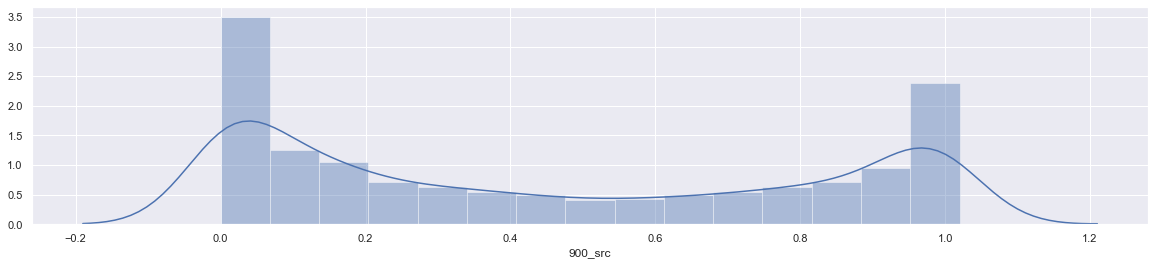

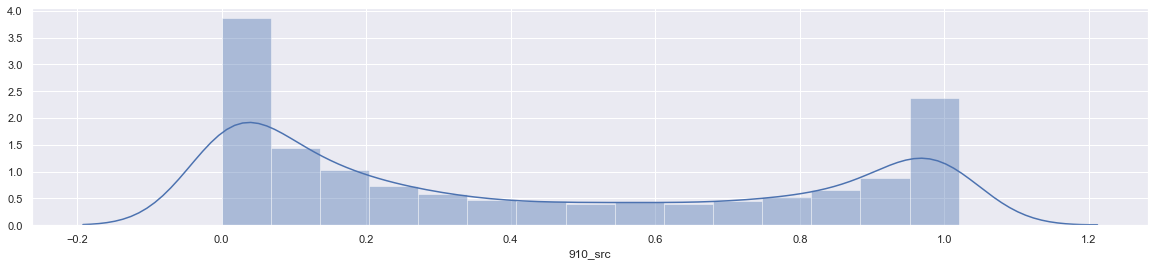

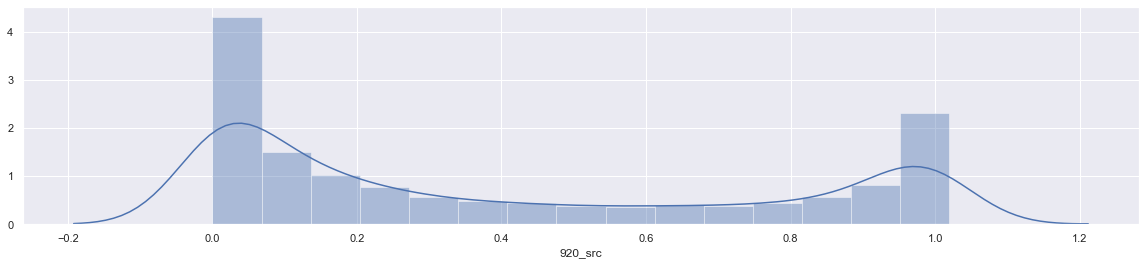

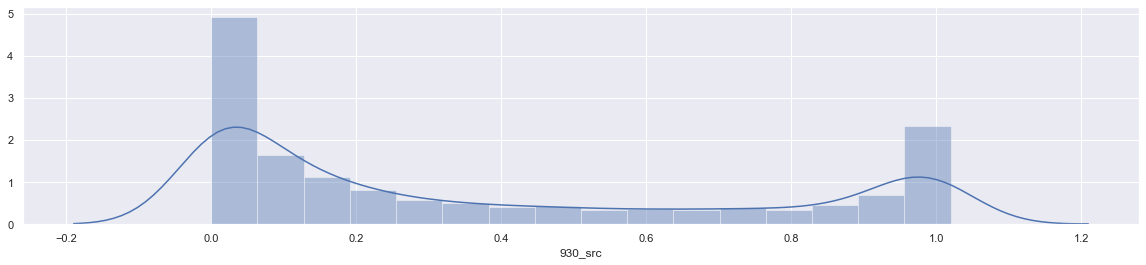

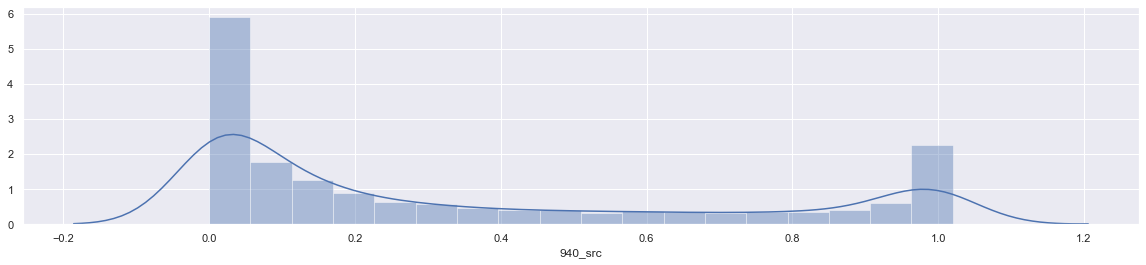

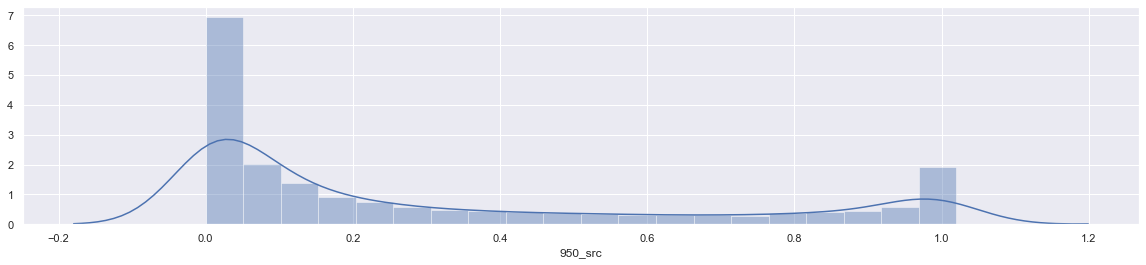

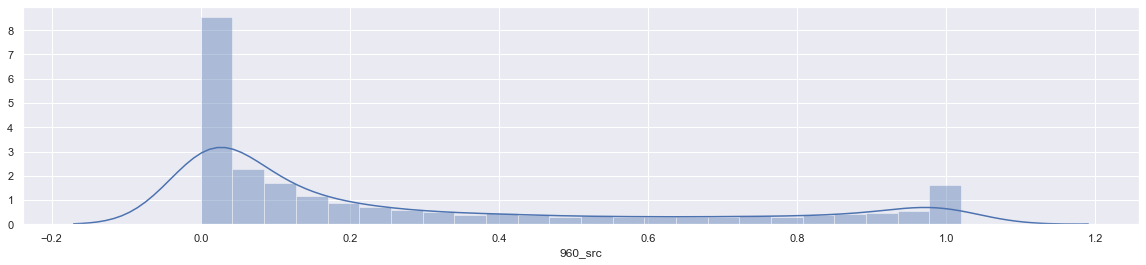

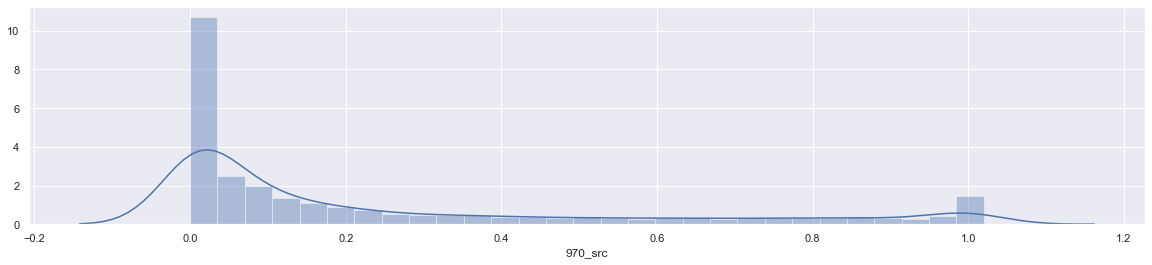

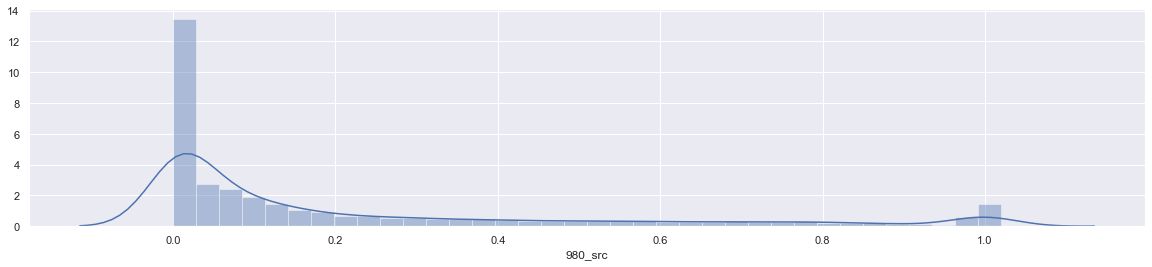

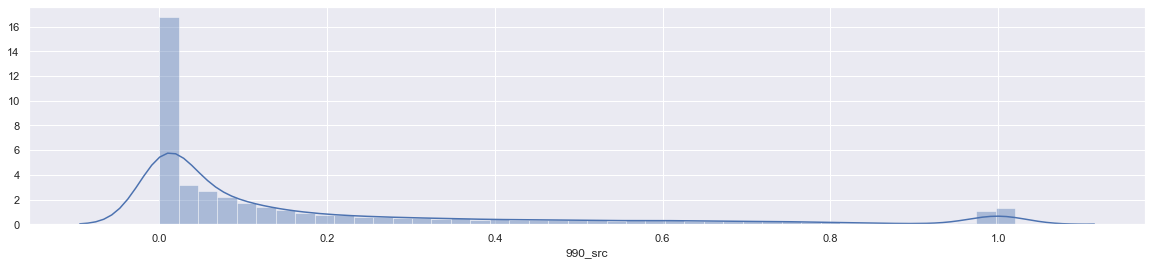

In [28]:
columns = X_train2.columns
sns.set()
for col in columns:
    fig,ax = plt.subplots(1, 1, figsize=(20,4))
    sns.distplot(train[col])

In [29]:
train_src = train.filter(regex='_src$', axis=1)
test_src = test.filter(regex='_src$', axis=1)

# src변수 5개씩 잘라 평균값내서 mean_src 추가
# 5개씩 가장 분포가 비슷해보여서
train_copy = train.copy()
test_copy = test.copy()

for idx in range(0,31,5):
    avg = []
    for i in range(len(train_src)):
        avg.append(train_src.iloc[i, idx:idx+5].mean())
    train_copy[f'{int(idx/5)+1}_mean_src'] = avg

In [30]:
# test 
for idx in range(0,31,5):
    avg = []
    for i in range(len(test_src)):
        avg.append(test_src.iloc[i, idx:idx+5].mean())
    test_copy[f'{int(idx/5)+1}_mean_src'] = avg

In [31]:
# _src 변수 제거
train_copy2 = train_copy.copy()
drops = train_copy.loc[:, '650_src':'990_src'].columns
train_copy2.drop(drops, axis=1, inplace=True)
train_copy2

test_copy2 = test_copy.copy()
drops = test_copy.loc[:, '650_src':'990_src'].columns
test_copy2.drop(drops, axis=1, inplace=True)
test_copy2

,id,rho,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,...,970_dst,980_dst,990_dst,1_mean_src,2_mean_src,3_mean_src,4_mean_src,5_mean_src,6_mean_src,7_mean_src
0,10000.0,15.0,0.000000e+00,3.514159e-15,7.028318e-15,1.199001e-14,1.695171e-14,2.191340e-14,2.204989e-14,0.000000e+00,...,0.000000e+00,3.660118e-14,7.320236e-14,0.327742,0.818208,0.928910,0.474830,0.115444,0.008526,0.010282
1,10001.0,15.0,1.005000e-03,3.744801e-13,1.190392e-14,9.131521e-13,1.796724e-14,1.081485e-14,0.000000e+00,0.000000e+00,...,7.348414e-14,1.259055e-13,2.349874e-13,0.674538,0.966296,0.703610,0.274916,0.054558,0.006698,0.005044
2,10002.0,10.0,1.732202e-12,1.827363e-11,1.332869e-11,2.641682e-12,3.498661e-12,1.466659e-11,2.981251e-11,2.764069e-11,...,1.219010e-11,1.219010e-11,1.219010e-11,0.640612,0.965524,0.715162,0.365762,0.186098,0.119234,0.076502
3,10003.0,10.0,0.000000e+00,0.000000e+00,0.000000e+00,2.713471e-12,6.567726e-12,2.069053e-12,3.467277e-12,0.000000e+00,...,3.304247e-12,4.106134e-11,4.106134e-11,0.111470,0.408918,0.815046,0.224370,0.081134,0.039940,0.015586
4,10004.0,25.0,0.000000e+00,4.030214e-17,3.265115e-17,2.500016e-17,0.000000e+00,0.000000e+00,0.000000e+00,3.969590e-17,...,0.000000e+00,1.910775e-16,2.215673e-15,0.005574,0.005212,0.001524,0.042110,0.366138,0.891932,0.897710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,19995.0,15.0,0.000000e+00,1.059879e-13,7.949091e-14,5.299394e-14,2.649697e-14,0.000000e+00,0.000000e+00,0.000000e+00,...,1.472213e-13,1.479745e-12,5.391520e-12,0.050480,0.084912,0.135508,0.278714,0.644262,0.928646,0.502880
9996,19996.0,25.0,0.000000e+00,0.000000e+00,5.283427e-19,3.519532e-19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.420572e-18,3.928314e-18,2.586781e-17,0.031742,0.197962,0.590580,0.956068,0.832154,0.396366,0.096008
9997,19997.0,15.0,1.452606e-15,4.033172e-15,2.832304e-15,0.000000e+00,0.000000e+00,8.643718e-14,1.728744e-13,2.593115e-13,...,1.436617e-15,0.000000e+00,1.743751e-13,0.008934,0.664596,0.344328,0.010588,0.005526,0.005862,0.003418
9998,19998.0,20.0,1.204500e-02,3.117827e-18,1.108607e-17,2.708993e-18,0.000000e+00,1.680228e-17,0.000000e+00,2.040947e-18,...,4.489194e-18,2.892986e-17,2.892986e-17,0.094934,0.258996,0.819272,0.498574,0.150556,0.060576,0.033754


In [32]:
# _src 변수 제거한 후 다중공선성
feature_columns = list(train_copy2.columns.difference(['id','hhb','hbo2','ca','na']))

vif3 = pd.DataFrame()
vif3['VIF Factor'] = [variance_inflation_factor(train_copy2[feature_columns].values, i) for i in range(train_copy2[feature_columns].shape[1])]
vif3['features'] = train_copy2[feature_columns].columns

vif3.sort_values(by='VIF Factor', ascending=False)

,VIF Factor,features
24,989.989095,820_dst
25,854.900479,830_dst
23,782.108571,810_dst
27,770.159699,850_dst
26,735.941545,840_dst
22,567.942679,800_dst
20,521.015484,790_dst
28,435.220412,860_dst
29,322.447552,870_dst
19,306.553666,780_dst


In [33]:
# src - dst 변수 추가
src_list = train_copy.loc[:, '650_src':'990_src'].columns
dst_list = train_copy.loc[:, '650_dst':'990_dst'].columns

gap_feature_names=[]
for i in range(650, 1000, 10):
    gap_feature_names.append(str(i) + '_gap')

gap = pd.DataFrame(np.array(train_copy[src_list]) - np.array(train_copy[dst_list]), columns=gap_feature_names, index=train_copy.index)

train_copy = pd.concat((train_copy, gap), axis=1)
train_copy

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,...,900_gap,910_gap,920_gap,930_gap,940_gap,950_gap,960_gap,970_gap,980_gap,990_gap
0,0.0,25.0,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,...,0.14493,0.13150,0.12442,1.078600e-01,0.11984,0.09851,1.096500e-01,0.07424,0.07777,0.05536
1,1.0,10.0,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,...,0.41456,0.63716,0.84230,9.748000e-01,0.99803,0.97146,8.704500e-01,0.75330,0.63414,0.53699
2,2.0,25.0,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,...,0.46222,0.39113,0.27879,1.907000e-01,0.16603,0.11617,6.744000e-02,0.02343,0.03926,-5.28864
3,3.0,10.0,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,...,0.17876,0.15139,0.15656,1.339200e-01,0.14247,0.10126,9.928000e-02,0.09239,0.10523,-2.77151
4,4.0,15.0,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,...,0.98300,1.00616,0.99045,1.013210e+00,1.01559,1.01072,9.943900e-01,0.98597,-2.99111,-6.96588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995.0,15.0,0.23929,0.30265,0.39929,0.51000,0.64072,0.77328,0.86722,0.95891,...,0.00000,0.00317,0.00811,-1.686503e-15,0.01942,0.00000,-5.516467e-16,0.01132,0.00731,0.01579
9996,9996.0,20.0,0.02583,0.00946,0.03650,0.01380,0.04093,0.04363,0.03260,0.05282,...,0.89597,0.69515,0.53156,4.028200e-01,0.30653,0.22199,1.717800e-01,0.15614,0.12397,0.09550
9997,9997.0,10.0,0.57589,0.62976,0.70571,0.77248,0.85402,0.92796,0.97691,0.98933,...,0.19588,0.17659,0.17717,1.467000e-01,0.14668,0.11504,1.113300e-01,0.12952,0.11553,0.11319
9998,9998.0,15.0,1.01477,1.01504,0.99125,0.98747,1.00717,1.01434,0.99529,1.01322,...,0.98012,1.00746,1.00718,1.000170e+00,0.98364,0.98014,9.955900e-01,1.01426,1.01546,1.00357


In [34]:
# test
src_list_test = test_copy.loc[:, '650_src':'990_src'].columns
dst_list_test = test_copy.loc[:, '650_dst':'990_dst'].columns

gap_feature_names=[]
for i in range(650, 1000, 10):
    gap_feature_names.append(str(i) + '_gap')

gap = pd.DataFrame(np.array(test_copy[src_list_test]) - np.array(test_copy[dst_list_test]), columns=gap_feature_names, index=test_copy.index)

test_copy = pd.concat((test_copy, gap), axis=1)
test_copy

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,...,900_gap,910_gap,920_gap,930_gap,940_gap,950_gap,960_gap,970_gap,980_gap,990_gap
0,10000.0,15.0,0.15406,0.23275,0.30977,0.42949,0.51264,0.62558,0.74340,0.85418,...,0.02841,0.01290,0.00132,0.00000,0.000000e+00,0.01904,-1.429966e-14,1.952000e-02,-3.660118e-14,0.01285
1,10001.0,15.0,0.48552,0.56939,0.67575,0.79089,0.85114,0.92581,0.98071,0.98177,...,0.01144,0.00703,0.00096,0.01406,-4.825731e-14,0.00223,1.188000e-02,-7.348414e-14,9.100000e-03,0.00201
2,10002.0,10.0,0.46883,0.56085,0.62442,0.73172,0.81724,0.91517,0.94801,0.99108,...,0.13508,0.14524,0.10918,0.10280,1.038700e-01,0.09468,6.623000e-02,8.721000e-02,6.559000e-02,0.06880
3,10003.0,10.0,0.06905,0.07517,0.10226,0.14905,0.16182,0.19659,0.26085,0.36753,...,0.04793,0.03783,0.04006,0.02746,4.642000e-02,0.00630,1.501000e-02,1.071000e-02,3.310000e-02,0.01281
4,10004.0,25.0,0.00253,0.00757,0.01649,0.00128,0.00000,0.00000,0.00105,0.01975,...,0.72828,0.83838,0.92615,0.96783,9.990200e-01,1.00555,9.513800e-01,9.124300e-01,8.565600e-01,0.76263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,19995.0,15.0,0.04334,0.03279,0.05853,0.04070,0.07704,0.07859,0.06168,0.08903,...,0.94957,1.00150,0.96775,0.92453,7.998800e-01,0.68060,5.934100e-01,4.773700e-01,4.215000e-01,0.34152
9996,19996.0,25.0,0.00020,0.02009,0.01726,0.03816,0.08300,0.08681,0.15300,0.18099,...,0.57224,0.49234,0.38224,0.31815,2.168600e-01,0.16377,1.363500e-01,1.067500e-01,4.907000e-02,0.02410
9997,19997.0,15.0,0.00000,0.00000,0.00120,0.00000,0.04347,0.14882,0.40883,0.80365,...,0.00000,0.00000,0.00234,0.01931,7.660000e-03,0.00664,9.200000e-04,-1.436617e-15,0.000000e+00,0.00953
9998,19998.0,20.0,0.08390,0.05690,0.08343,0.12324,0.12720,0.16732,0.18149,0.23766,...,0.07686,0.08491,0.07192,0.03477,3.442000e-02,0.05455,4.825000e-02,2.415000e-02,1.773000e-02,0.02409


In [35]:
# 다시 _src 변수 제거 후 다중공선성 확인
feature_columns = list(train_copy.columns.difference(['id','hhb','hbo2','ca','na']))

vif4 = pd.DataFrame()
vif4['VIF Factor'] = [variance_inflation_factor(train_copy[feature_columns].values, i) for i in range(train_copy[feature_columns].shape[1])]
vif4['features'] = train_copy[feature_columns].columns

vif4.sort_values(by='VIF Factor', ascending=False)

,VIF Factor,features
94,inf,940_dst
21,inf,700_dst
14,2.251800e+15,680_dst
17,6.928615e+14,690_dst
15,6.004800e+14,680_gap
...,...,...
27,5.653740e+10,720_dst
33,4.653032e+10,740_dst
30,1.756104e+10,730_dst
24,5.432956e+09,710_dst


In [37]:
# _dst 변수 제거
drops = train_copy.loc[:, '650_dst':'990_dst'].columns
train_copy3 = train_copy2.drop(drops, axis=1)

feature_columns = list(train_copy3.columns.difference(['id','hhb','hbo2','ca','na']))

vif5 = pd.DataFrame()
vif5['VIF Factor'] = [variance_inflation_factor(train_copy3[feature_columns].values, i) for i in range(train_copy3[feature_columns].shape[1])]
vif5['features'] = train_copy3[feature_columns].columns

vif5.sort_values(by='VIF Factor', ascending=False)

,VIF Factor,features
5,26.480000,6_mean_src
3,24.318379,4_mean_src
4,24.039166,5_mean_src
1,23.637430,2_mean_src
2,23.238942,3_mean_src
6,10.057042,7_mean_src
0,9.022894,1_mean_src
7,5.023656,rho


In [38]:
train_2 = train_copy2
test_2 = test_copy.drop(src_list_test, axis=1)
display(train_2, test_2)

,id,rho,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,...,hbo2,ca,na,1_mean_src,2_mean_src,3_mean_src,4_mean_src,5_mean_src,6_mean_src,7_mean_src
0,0.0,25.0,2.447758e-18,1.894578e-18,0.000000e+00,6.412913e-18,1.098559e-17,8.907142e-19,4.453571e-19,0.000000e+00,...,4.32,8.92,4.29,0.516006,0.901106,0.843100,0.448354,0.244280,0.125710,0.083106
1,1.0,10.0,0.000000e+00,0.000000e+00,0.000000e+00,1.995530e-10,1.025259e-10,0.000000e+00,0.000000e+00,0.000000e+00,...,2.83,7.25,4.64,0.003626,0.007180,0.005700,0.002976,0.073700,0.773370,0.753268
2,2.0,25.0,1.677445e-19,3.763590e-20,1.881795e-20,0.000000e+00,2.993884e-19,5.987767e-19,8.981651e-19,1.944683e-19,...,3.00,8.40,5.16,0.030316,0.197132,0.587660,0.955088,0.782144,0.297774,0.055532
3,3.0,10.0,4.044975e-11,4.695169e-11,5.345363e-11,9.106886e-12,1.881458e-11,3.617201e-11,7.909656e-13,7.958742e-11,...,4.01,5.05,4.35,0.358620,0.724094,0.946192,0.589846,0.276938,0.152620,0.092330
4,4.0,15.0,4.784751e-14,2.392375e-14,0.000000e+00,1.153089e-13,0.000000e+00,0.000000e+00,1.056991e-13,0.000000e+00,...,4.41,10.78,2.42,1.003940,1.003276,1.005796,0.991210,1.000904,1.001682,1.000818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995.0,15.0,2.728013e-15,1.438586e-14,0.000000e+00,0.000000e+00,1.941750e-14,3.883500e-14,1.111576e-14,4.196881e-14,...,4.11,12.31,0.10,0.418390,0.917324,0.793066,0.275404,0.034524,0.006140,0.006884
9996,9996.0,20.0,4.775000e-02,3.021131e-17,0.000000e+00,0.000000e+00,0.000000e+00,8.445801e-18,2.316884e-17,3.789188e-17,...,4.11,10.46,3.12,0.025304,0.047922,0.074426,0.196086,0.729840,0.566406,0.153876
9997,9997.0,10.0,7.248393e-12,0.000000e+00,2.125747e-11,1.364016e-11,1.018564e-11,0.000000e+00,0.000000e+00,5.944397e-12,...,3.20,10.45,2.06,0.707572,0.975064,0.796842,0.471448,0.269042,0.168604,0.116922
9998,9998.0,15.0,1.629438e-13,8.912821e-14,1.531261e-14,8.313464e-14,3.306053e-13,0.000000e+00,0.000000e+00,1.108741e-13,...,4.06,11.28,4.03,1.003140,1.008004,0.994262,1.000612,1.001884,0.995714,1.001804


,id,rho,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,...,900_gap,910_gap,920_gap,930_gap,940_gap,950_gap,960_gap,970_gap,980_gap,990_gap
0,10000.0,15.0,0.000000e+00,3.514159e-15,7.028318e-15,1.199001e-14,1.695171e-14,2.191340e-14,2.204989e-14,0.000000e+00,...,0.02841,0.01290,0.00132,0.00000,0.000000e+00,0.01904,-1.429966e-14,1.952000e-02,-3.660118e-14,0.01285
1,10001.0,15.0,1.005000e-03,3.744801e-13,1.190392e-14,9.131521e-13,1.796724e-14,1.081485e-14,0.000000e+00,0.000000e+00,...,0.01144,0.00703,0.00096,0.01406,-4.825731e-14,0.00223,1.188000e-02,-7.348414e-14,9.100000e-03,0.00201
2,10002.0,10.0,1.732202e-12,1.827363e-11,1.332869e-11,2.641682e-12,3.498661e-12,1.466659e-11,2.981251e-11,2.764069e-11,...,0.13508,0.14524,0.10918,0.10280,1.038700e-01,0.09468,6.623000e-02,8.721000e-02,6.559000e-02,0.06880
3,10003.0,10.0,0.000000e+00,0.000000e+00,0.000000e+00,2.713471e-12,6.567726e-12,2.069053e-12,3.467277e-12,0.000000e+00,...,0.04793,0.03783,0.04006,0.02746,4.642000e-02,0.00630,1.501000e-02,1.071000e-02,3.310000e-02,0.01281
4,10004.0,25.0,0.000000e+00,4.030214e-17,3.265115e-17,2.500016e-17,0.000000e+00,0.000000e+00,0.000000e+00,3.969590e-17,...,0.72828,0.83838,0.92615,0.96783,9.990200e-01,1.00555,9.513800e-01,9.124300e-01,8.565600e-01,0.76263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,19995.0,15.0,0.000000e+00,1.059879e-13,7.949091e-14,5.299394e-14,2.649697e-14,0.000000e+00,0.000000e+00,0.000000e+00,...,0.94957,1.00150,0.96775,0.92453,7.998800e-01,0.68060,5.934100e-01,4.773700e-01,4.215000e-01,0.34152
9996,19996.0,25.0,0.000000e+00,0.000000e+00,5.283427e-19,3.519532e-19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.57224,0.49234,0.38224,0.31815,2.168600e-01,0.16377,1.363500e-01,1.067500e-01,4.907000e-02,0.02410
9997,19997.0,15.0,1.452606e-15,4.033172e-15,2.832304e-15,0.000000e+00,0.000000e+00,8.643718e-14,1.728744e-13,2.593115e-13,...,0.00000,0.00000,0.00234,0.01931,7.660000e-03,0.00664,9.200000e-04,-1.436617e-15,0.000000e+00,0.00953
9998,19998.0,20.0,1.204500e-02,3.117827e-18,1.108607e-17,2.708993e-18,0.000000e+00,1.680228e-17,0.000000e+00,2.040947e-18,...,0.07686,0.08491,0.07192,0.03477,3.442000e-02,0.05455,4.825000e-02,2.415000e-02,1.773000e-02,0.02409


In [39]:
train_copy

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,...,900_gap,910_gap,920_gap,930_gap,940_gap,950_gap,960_gap,970_gap,980_gap,990_gap
0,0.0,25.0,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,...,0.14493,0.13150,0.12442,1.078600e-01,0.11984,0.09851,1.096500e-01,0.07424,0.07777,0.05536
1,1.0,10.0,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,...,0.41456,0.63716,0.84230,9.748000e-01,0.99803,0.97146,8.704500e-01,0.75330,0.63414,0.53699
2,2.0,25.0,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,...,0.46222,0.39113,0.27879,1.907000e-01,0.16603,0.11617,6.744000e-02,0.02343,0.03926,-5.28864
3,3.0,10.0,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,...,0.17876,0.15139,0.15656,1.339200e-01,0.14247,0.10126,9.928000e-02,0.09239,0.10523,-2.77151
4,4.0,15.0,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,...,0.98300,1.00616,0.99045,1.013210e+00,1.01559,1.01072,9.943900e-01,0.98597,-2.99111,-6.96588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995.0,15.0,0.23929,0.30265,0.39929,0.51000,0.64072,0.77328,0.86722,0.95891,...,0.00000,0.00317,0.00811,-1.686503e-15,0.01942,0.00000,-5.516467e-16,0.01132,0.00731,0.01579
9996,9996.0,20.0,0.02583,0.00946,0.03650,0.01380,0.04093,0.04363,0.03260,0.05282,...,0.89597,0.69515,0.53156,4.028200e-01,0.30653,0.22199,1.717800e-01,0.15614,0.12397,0.09550
9997,9997.0,10.0,0.57589,0.62976,0.70571,0.77248,0.85402,0.92796,0.97691,0.98933,...,0.19588,0.17659,0.17717,1.467000e-01,0.14668,0.11504,1.113300e-01,0.12952,0.11553,0.11319
9998,9998.0,15.0,1.01477,1.01504,0.99125,0.98747,1.00717,1.01434,0.99529,1.01322,...,0.98012,1.00746,1.00718,1.000170e+00,0.98364,0.98014,9.955900e-01,1.01426,1.01546,1.00357


In [40]:
test_copy

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,...,900_gap,910_gap,920_gap,930_gap,940_gap,950_gap,960_gap,970_gap,980_gap,990_gap
0,10000.0,15.0,0.15406,0.23275,0.30977,0.42949,0.51264,0.62558,0.74340,0.85418,...,0.02841,0.01290,0.00132,0.00000,0.000000e+00,0.01904,-1.429966e-14,1.952000e-02,-3.660118e-14,0.01285
1,10001.0,15.0,0.48552,0.56939,0.67575,0.79089,0.85114,0.92581,0.98071,0.98177,...,0.01144,0.00703,0.00096,0.01406,-4.825731e-14,0.00223,1.188000e-02,-7.348414e-14,9.100000e-03,0.00201
2,10002.0,10.0,0.46883,0.56085,0.62442,0.73172,0.81724,0.91517,0.94801,0.99108,...,0.13508,0.14524,0.10918,0.10280,1.038700e-01,0.09468,6.623000e-02,8.721000e-02,6.559000e-02,0.06880
3,10003.0,10.0,0.06905,0.07517,0.10226,0.14905,0.16182,0.19659,0.26085,0.36753,...,0.04793,0.03783,0.04006,0.02746,4.642000e-02,0.00630,1.501000e-02,1.071000e-02,3.310000e-02,0.01281
4,10004.0,25.0,0.00253,0.00757,0.01649,0.00128,0.00000,0.00000,0.00105,0.01975,...,0.72828,0.83838,0.92615,0.96783,9.990200e-01,1.00555,9.513800e-01,9.124300e-01,8.565600e-01,0.76263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,19995.0,15.0,0.04334,0.03279,0.05853,0.04070,0.07704,0.07859,0.06168,0.08903,...,0.94957,1.00150,0.96775,0.92453,7.998800e-01,0.68060,5.934100e-01,4.773700e-01,4.215000e-01,0.34152
9996,19996.0,25.0,0.00020,0.02009,0.01726,0.03816,0.08300,0.08681,0.15300,0.18099,...,0.57224,0.49234,0.38224,0.31815,2.168600e-01,0.16377,1.363500e-01,1.067500e-01,4.907000e-02,0.02410
9997,19997.0,15.0,0.00000,0.00000,0.00120,0.00000,0.04347,0.14882,0.40883,0.80365,...,0.00000,0.00000,0.00234,0.01931,7.660000e-03,0.00664,9.200000e-04,-1.436617e-15,0.000000e+00,0.00953
9998,19998.0,20.0,0.08390,0.05690,0.08343,0.12324,0.12720,0.16732,0.18149,0.23766,...,0.07686,0.08491,0.07192,0.03477,3.442000e-02,0.05455,4.825000e-02,2.415000e-02,1.773000e-02,0.02409


In [41]:
# 정규화
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

train_copy2 = train_copy.copy()
test_copy2 = test_copy.copy()

scaler = StandardScaler()
m_scaler = MinMaxScaler()

src_col = train_copy2.filter(regex='_src$', axis=1).columns
dst_col = train_copy2.filter(regex='_dst$', axis=1).columns
gap_col = train_copy2.filter(regex='_gap$', axis=1).columns

# src_col, gap_col
train_copy2[src_col] = scaler.fit_transform(train_copy2[src_col])
test_copy2[src_col] = scaler.transform(test_copy2[src_col])
train_copy2[gap_col] = scaler.fit_transform(train_copy2[gap_col])
test_copy2[gap_col] = scaler.transform(test_copy2[gap_col])

# dst_col
train_copy2[dst_col] = m_scaler.fit_transform(train_copy2[dst_col])
test_copy2[dst_col] = m_scaler.transform(test_copy2[dst_col])

# 4. 모델 학습 및 검증

In [42]:
x_train = train.loc[:, 'rho':'990_dst']
y_train = train.loc[:, 'hhb':'na']
test.drop('id', axis=1, inplace=True)

In [43]:
train_copy = train.copy()
test_copy = test.copy()

ntrain = train_copy.shape[0]
ntest = test_copy.shape[0]

all_data = pd.concat((train_copy, test_copy)).reset_index(drop=True)
all_data.drop(['id', 'hhb', 'hbo2', 'ca', 'na'], axis=1, inplace=True)
all_data.head()

,650_dst,650_src,660_dst,660_src,670_dst,670_src,680_dst,680_src,690_dst,690_src,...,950_src,960_dst,960_src,970_dst,970_src,980_dst,980_src,990_dst,990_src,rho
0,2.447758e-18,0.37950,1.894578e-18,0.42993,0.000000e+00,0.52076,6.412913e-18,0.57166,1.098559e-17,0.67818,...,0.09851,5.337522e-19,0.10965,1.067504e-18,0.07424,5.998949e-18,0.07777,4.378513e-17,0.05536,25.0
1,0.000000e+00,0.00000,0.000000e+00,0.00000,0.000000e+00,0.01813,1.995530e-10,0.00000,1.025259e-10,0.00000,...,0.97146,2.130547e-09,0.87045,5.920319e-09,0.75330,9.710091e-09,0.63414,4.855046e-09,0.53699,10.0
2,1.677445e-19,0.00000,3.763590e-20,0.03289,1.881795e-20,0.02416,0.000000e+00,0.03610,2.993884e-19,0.05843,...,0.11617,0.000000e+00,0.06744,0.000000e+00,0.02343,1.329725e-18,0.03926,5.320000e+00,0.03136,25.0
3,4.044975e-11,0.27503,4.695169e-11,0.31281,5.345363e-11,0.32898,9.106886e-12,0.41041,1.881458e-11,0.46587,...,0.10126,7.782625e-11,0.09928,2.433592e-10,0.09239,4.088921e-10,0.10523,2.835000e+00,0.06349,10.0
4,4.784751e-14,1.01521,2.392375e-14,1.00872,0.000000e+00,0.98930,1.153089e-13,0.98874,0.000000e+00,1.01773,...,1.01072,1.103571e-13,0.99439,1.330237e-13,0.98597,3.990000e+00,0.99889,7.980000e+00,1.01412,15.0


In [44]:
# skew()함수 이용해 모든 숫자형 변수들의 skew 확인

from scipy.stats import skew

skewed_feats = all_data.apply(
    lambda x: skew(x.dropna())).sort_values(ascending=False)

print("\nSkew in all data: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(15)


Skew in all data: 



,Skew
940_dst,141.410749
700_dst,116.509600
690_dst,90.490380
950_dst,79.764179
960_dst,58.165142
680_dst,57.833830
710_dst,51.103984
730_dst,31.835651
720_dst,29.616548
670_dst,28.832798


In [45]:
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

# xgboost (with skew)

In [46]:
train_skew = all_data[:ntrain]
test_skew = all_data[ntrain:]

train_skew.shape, test_skew.shape

((10000, 71), (10000, 71))

In [47]:
x_train.head()

,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,...,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
0,25.0,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,0.96333,...,3.076794e-18,3.527371e-18,2.086464e-18,6.455564e-19,3.227782e-19,0.000000e+00,5.337522e-19,1.067504e-18,5.998949e-18,4.378513e-17
1,10.0,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,0.00000,...,2.647633e-09,3.940557e-09,5.233480e-09,1.264238e-08,1.343132e-08,6.112685e-09,2.130547e-09,5.920319e-09,9.710091e-09,4.855046e-09
2,25.0,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,0.25584,...,4.629125e-18,1.409413e-18,3.237480e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.329725e-18,5.320000e+00
3,10.0,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,0.79865,...,1.274876e-10,6.118947e-11,1.137891e-10,1.663888e-10,2.245998e-10,1.299511e-10,7.782625e-11,2.433592e-10,4.088921e-10,2.835000e+00
4,15.0,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,1.01564,...,0.000000e+00,7.688095e-15,1.537619e-14,4.996522e-14,1.457955e-13,8.769053e-14,1.103571e-13,1.330237e-13,3.990000e+00,7.980000e+00


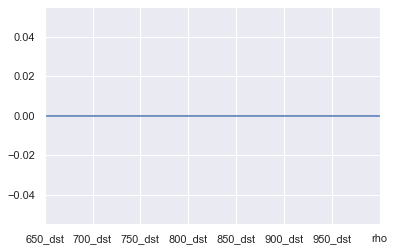

In [48]:
train_skew.isnull().sum().plot()

In [49]:
test.head()

,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,...,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
0,15.0,0.15406,0.23275,0.30977,0.42949,0.51264,0.62558,0.74340,0.85418,0.90815,...,0.000000e+00,0.000000e+00,1.432248e-14,0.000000e+00,0.000000e+00,6.332117e-15,1.429966e-14,0.000000e+00,3.660118e-14,7.320236e-14
1,15.0,0.48552,0.56939,0.67575,0.79089,0.85114,0.92581,0.98071,0.98177,0.98678,...,1.036013e-13,6.595554e-14,2.830975e-14,1.114337e-13,4.825731e-14,3.554108e-14,2.282485e-14,7.348414e-14,1.259055e-13,2.349874e-13
2,10.0,0.46883,0.56085,0.62442,0.73172,0.81724,0.91517,0.94801,0.99108,1.01261,...,1.325728e-11,1.386598e-11,1.447468e-11,1.508338e-11,1.569208e-11,6.242378e-12,9.216241e-12,1.219010e-11,1.219010e-11,1.219010e-11
3,10.0,0.06905,0.07517,0.10226,0.14905,0.16182,0.19659,0.26085,0.36753,0.51432,...,1.651177e-11,7.282747e-12,5.010879e-12,1.036055e-11,1.571023e-11,0.000000e+00,0.000000e+00,3.304247e-12,4.106134e-11,4.106134e-11
4,25.0,0.00253,0.00757,0.01649,0.00128,0.00000,0.00000,0.00105,0.01975,0.00000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.732057e-17,4.110605e-17,0.000000e+00,0.000000e+00,1.910775e-16,2.215673e-15


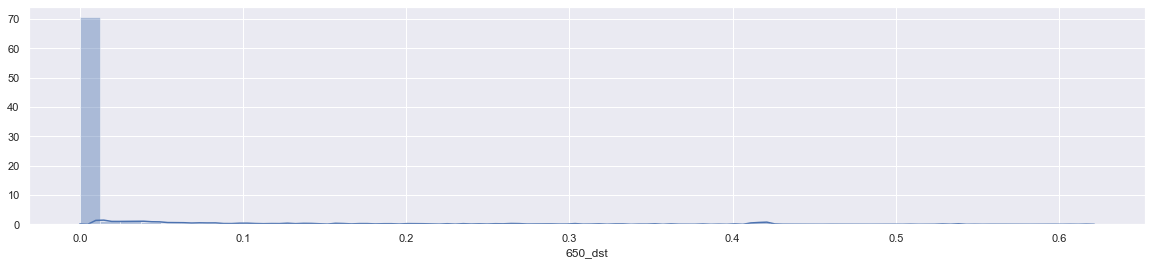

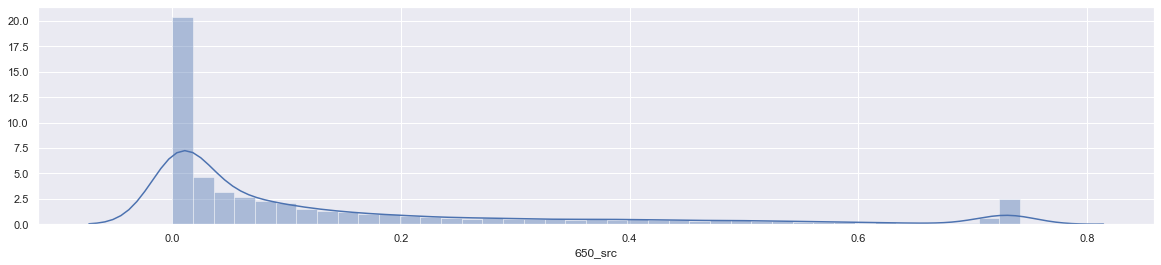

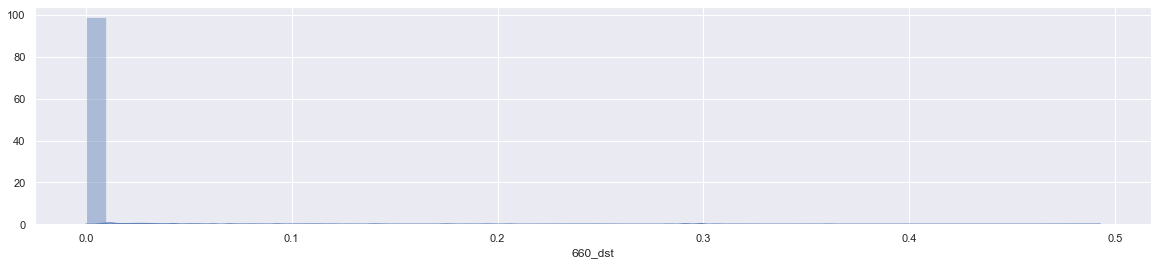

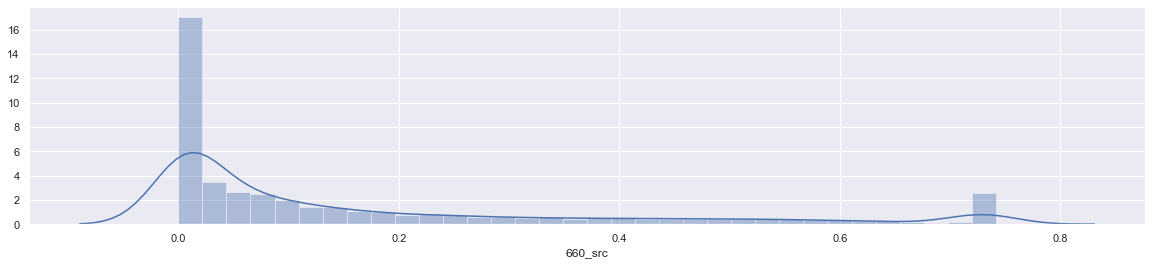

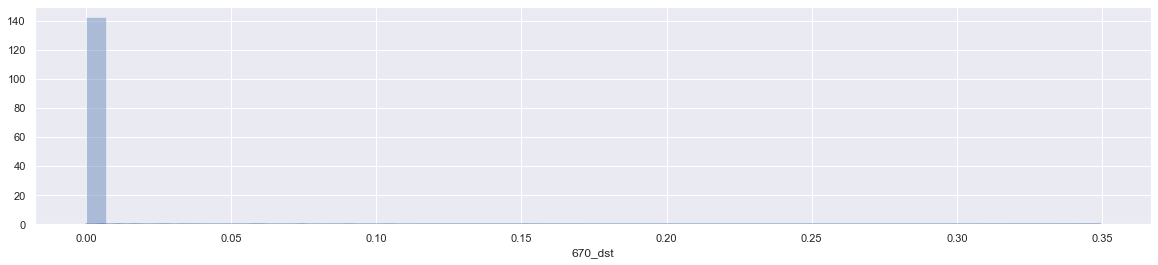

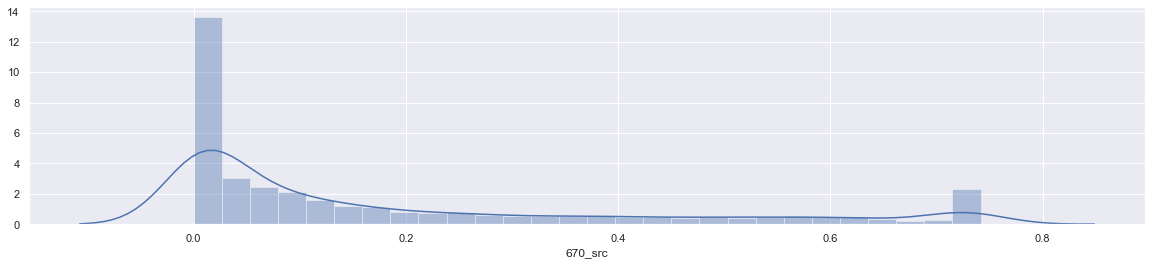

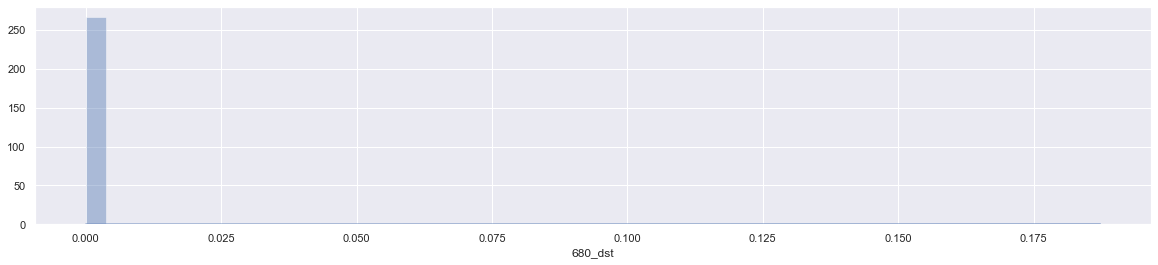

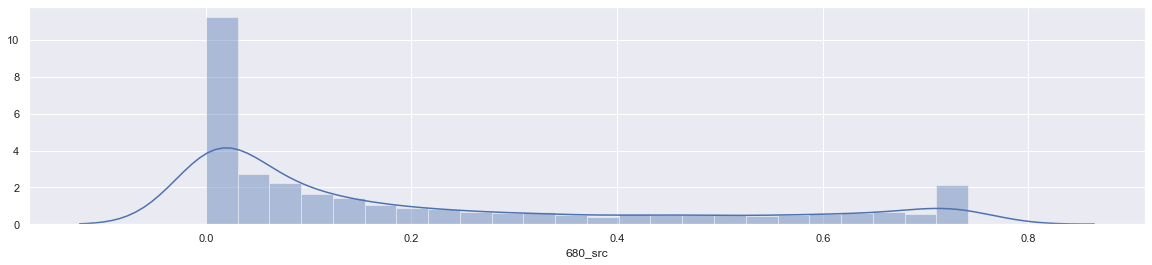

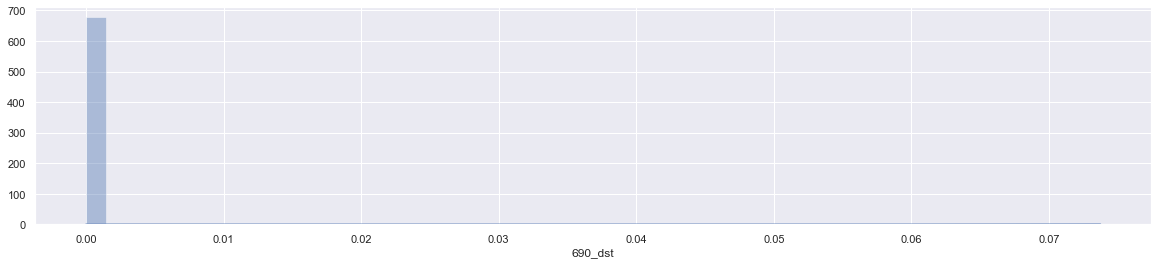

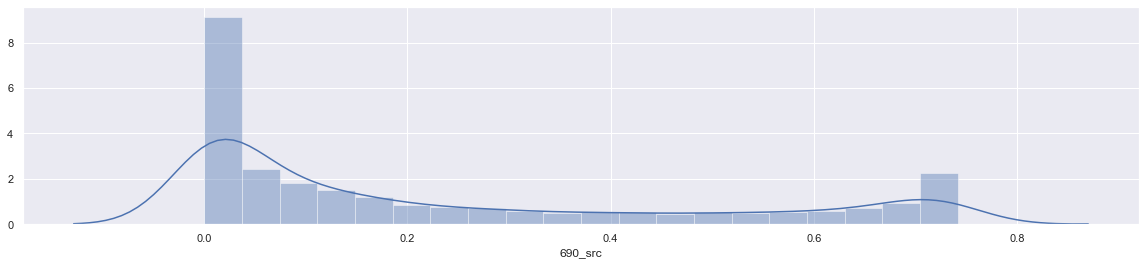

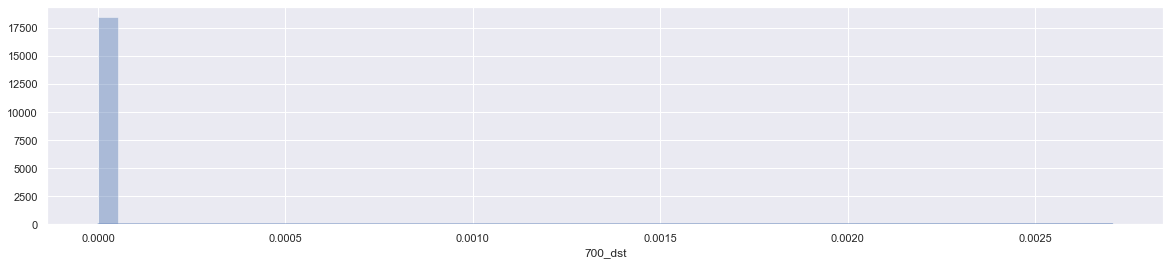

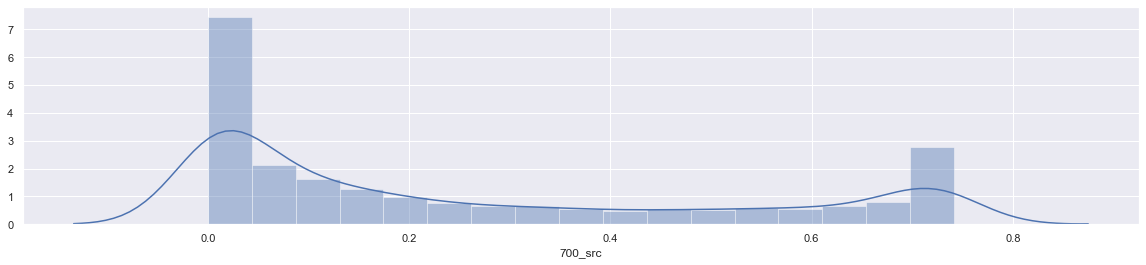

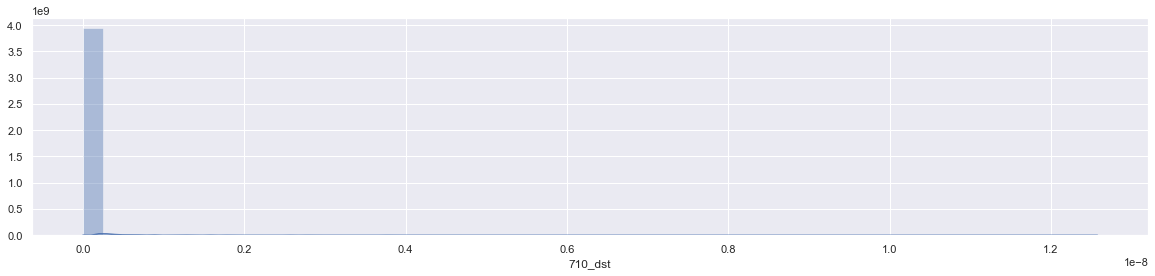

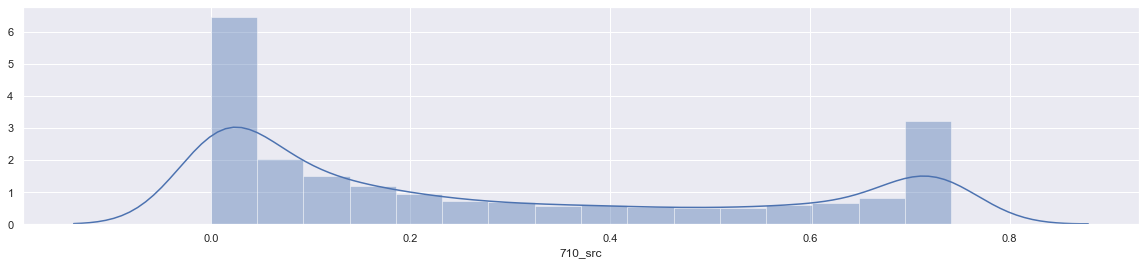

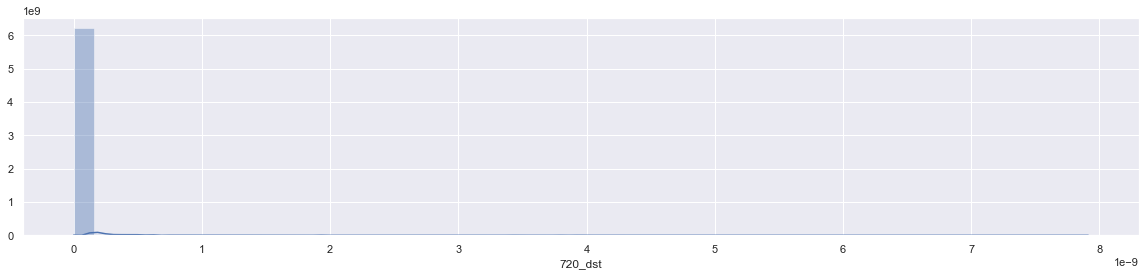

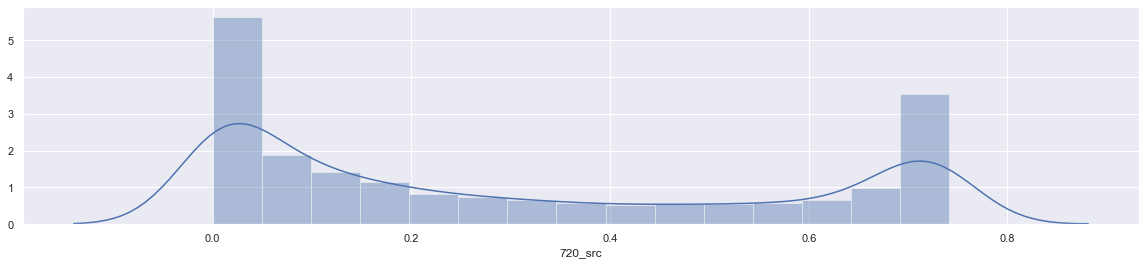

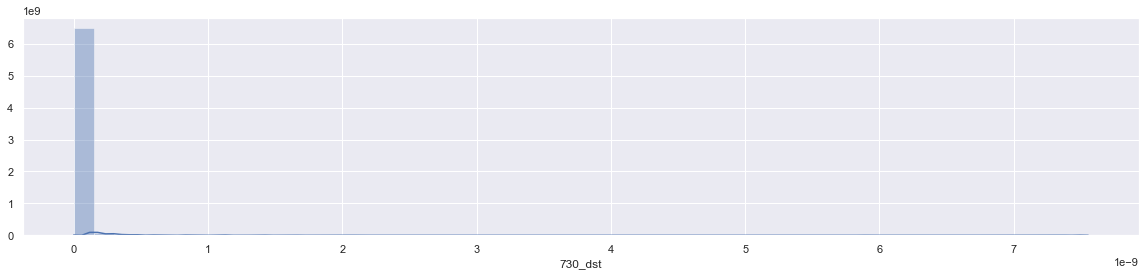

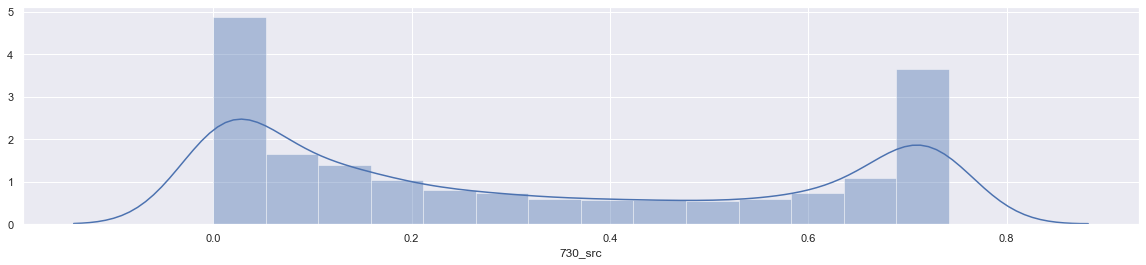

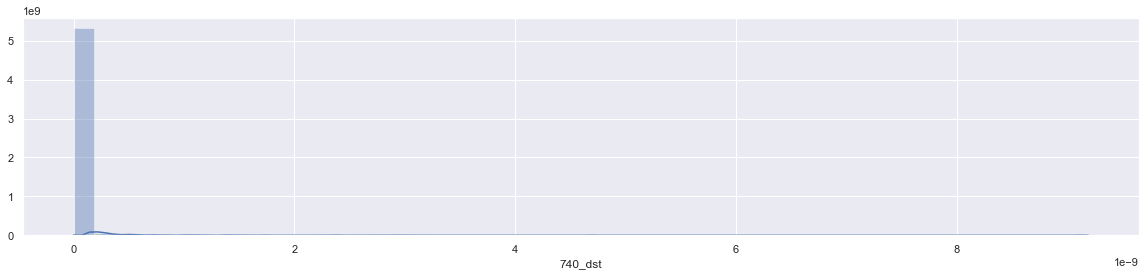

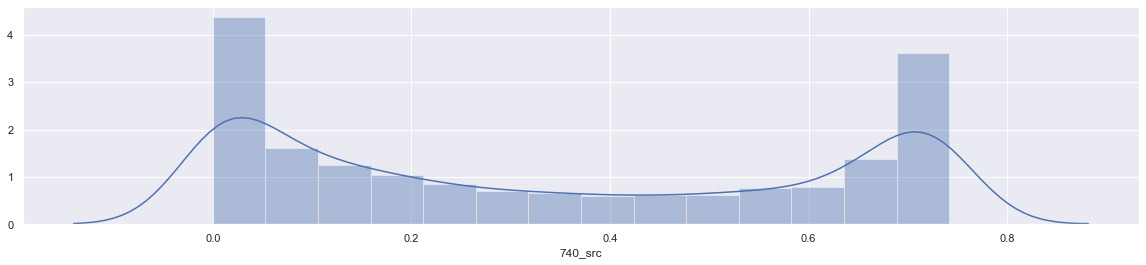

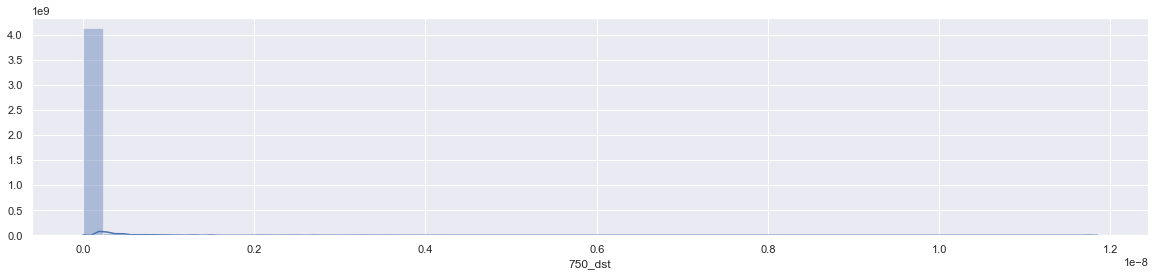

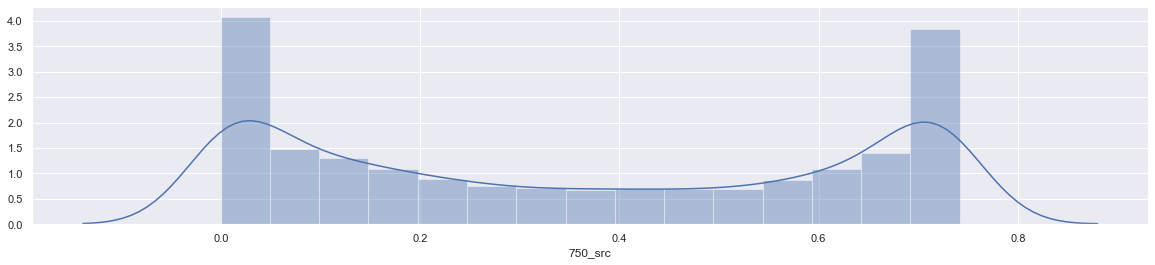

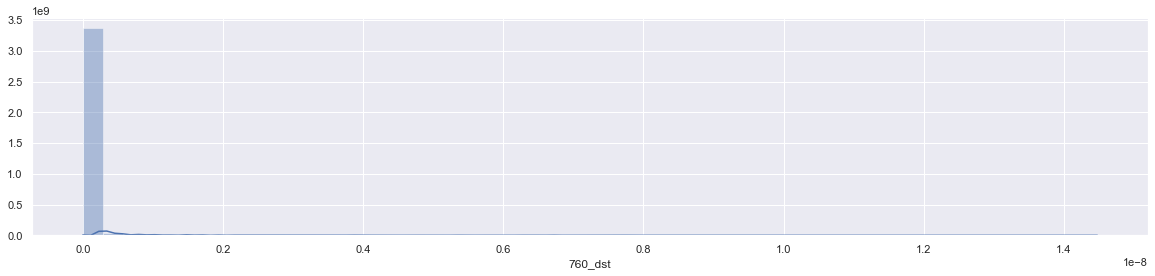

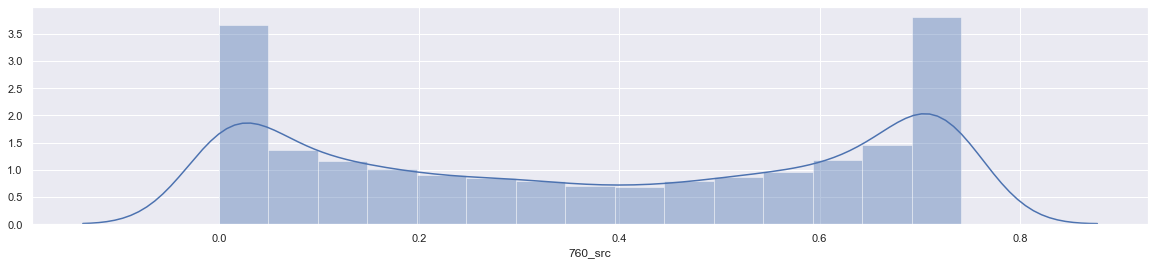

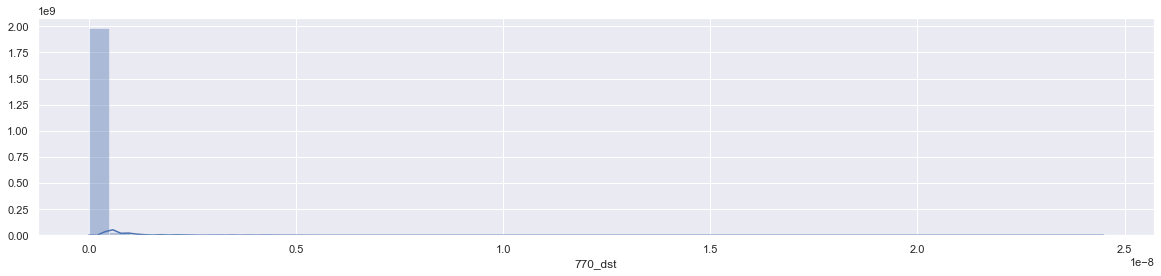

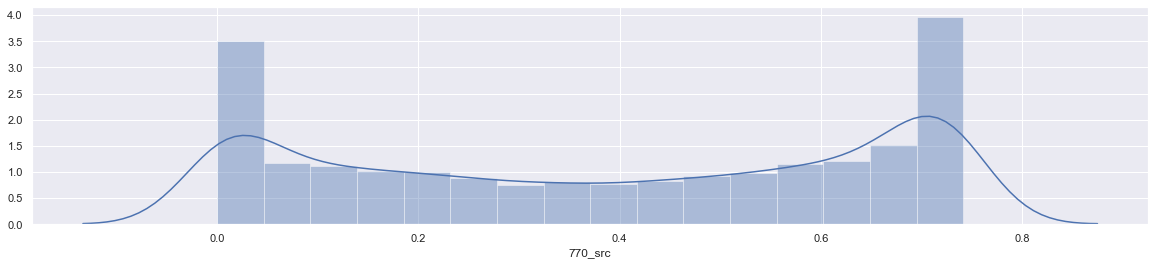

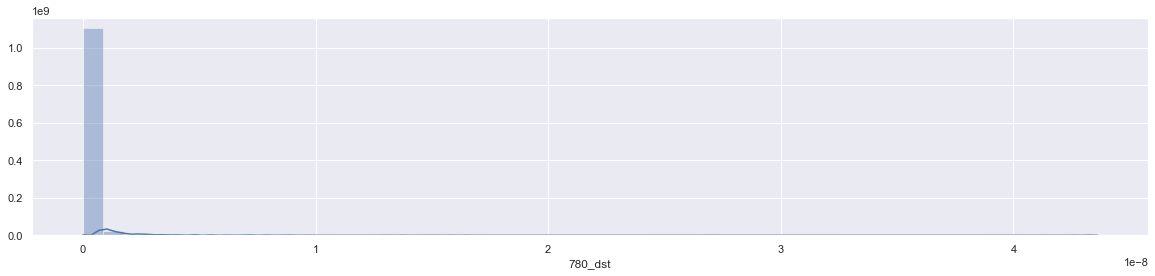

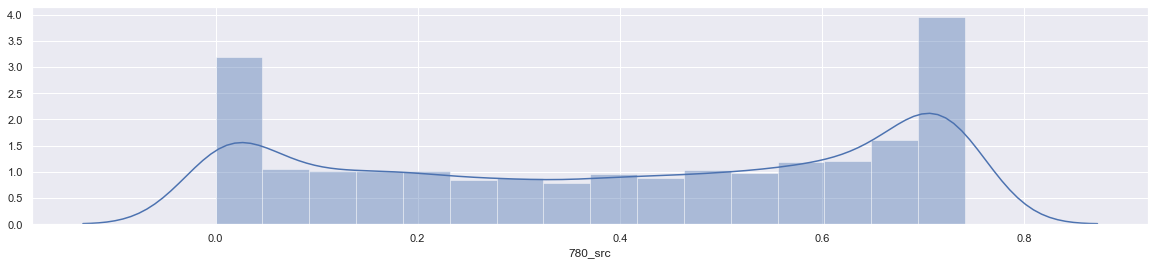

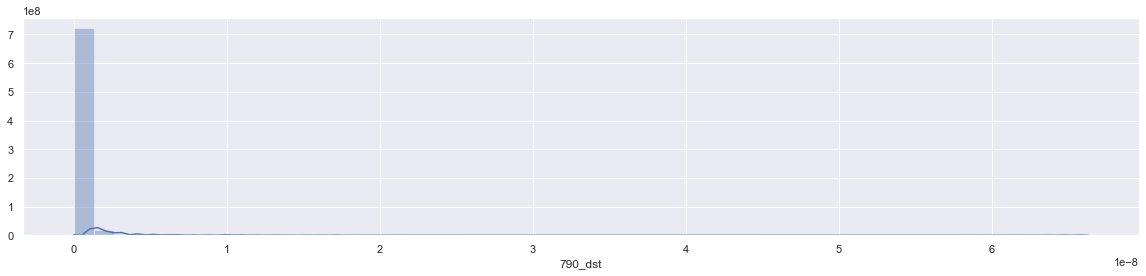

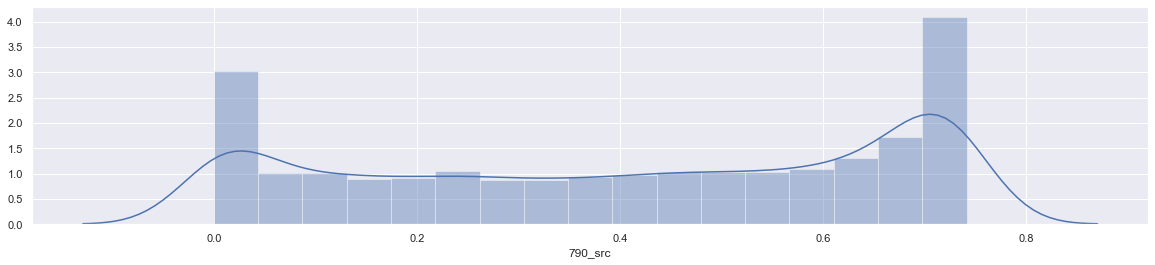

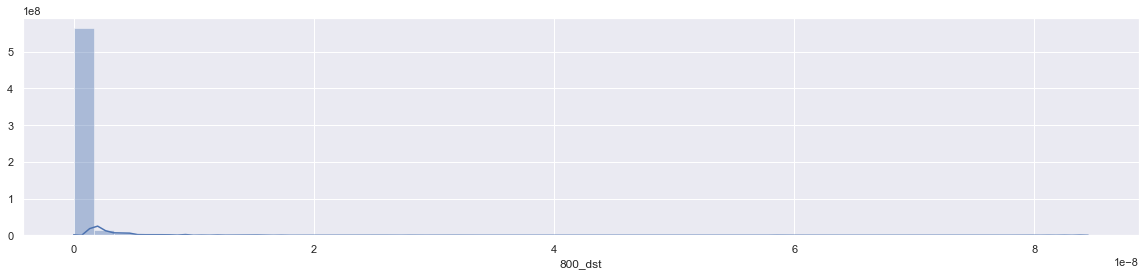

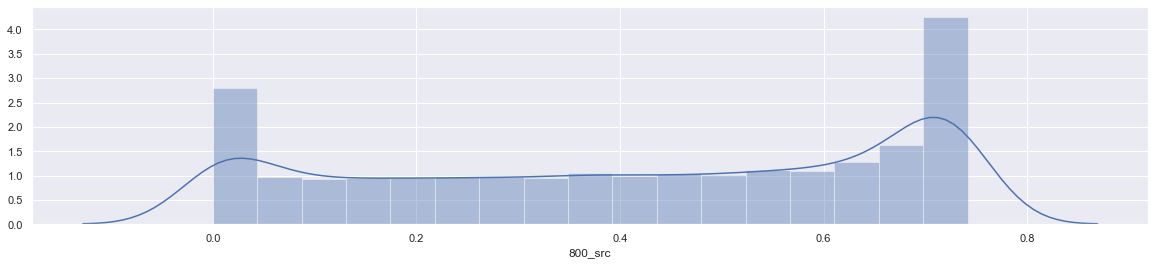

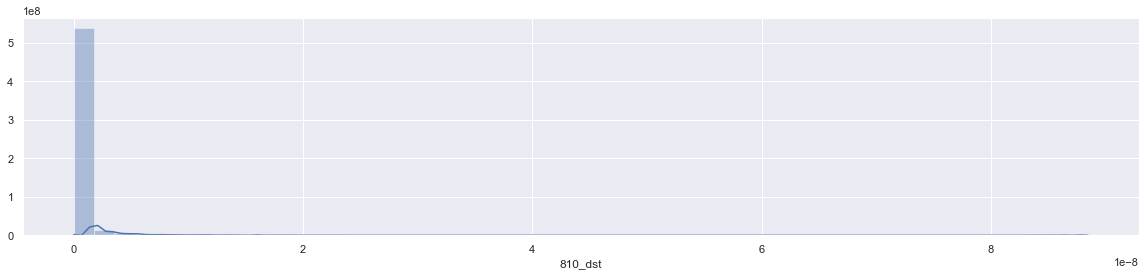

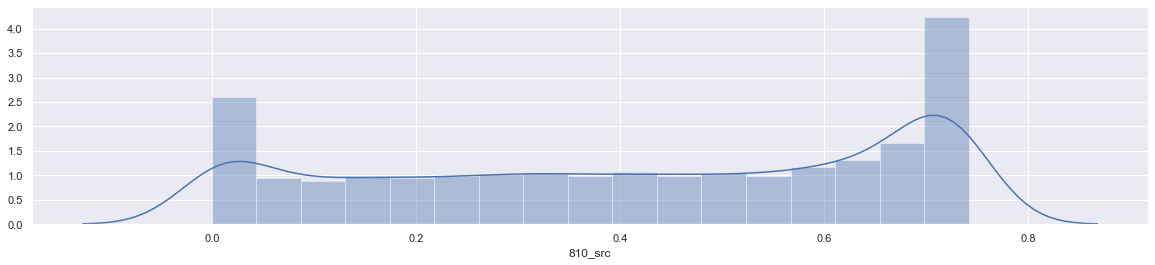

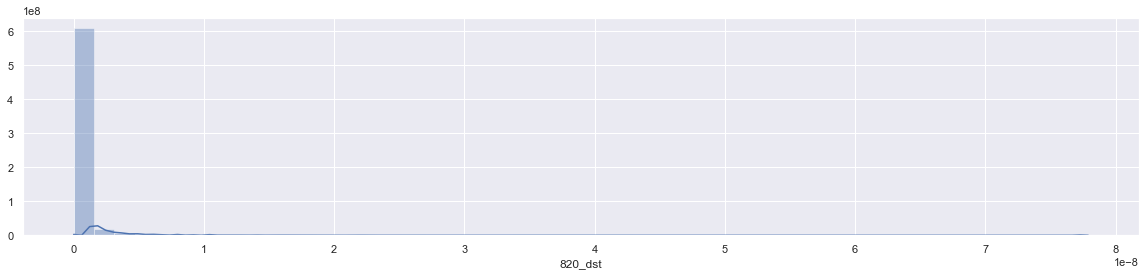

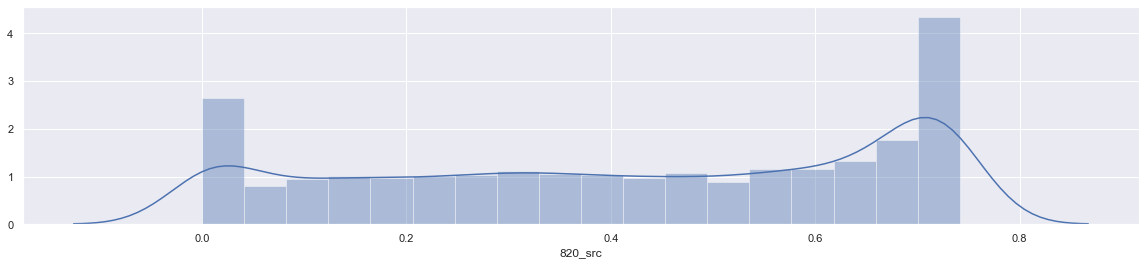

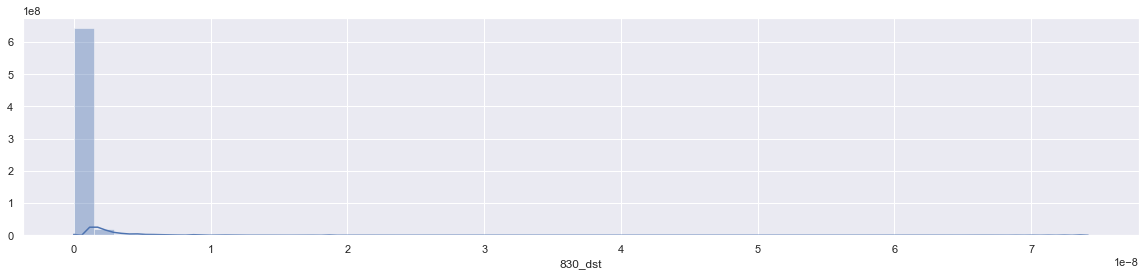

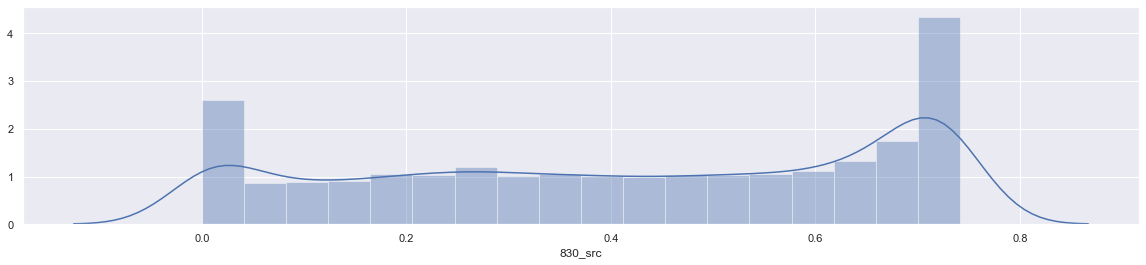

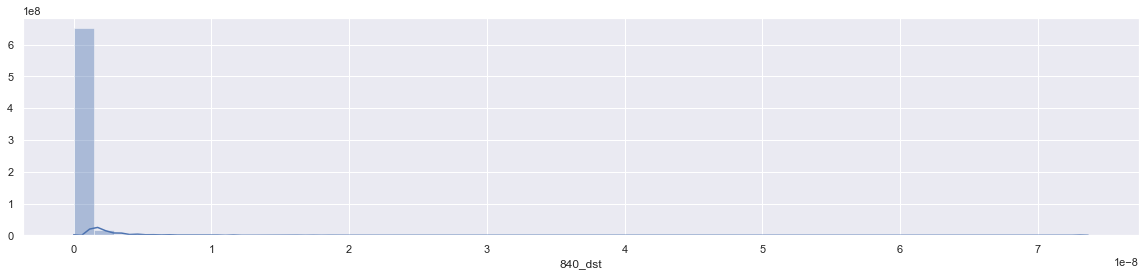

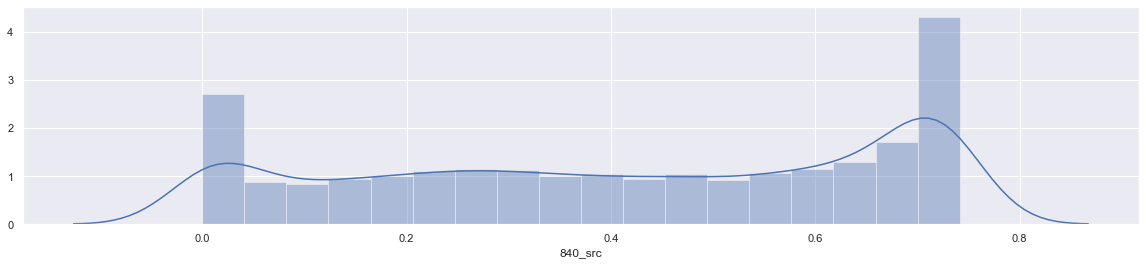

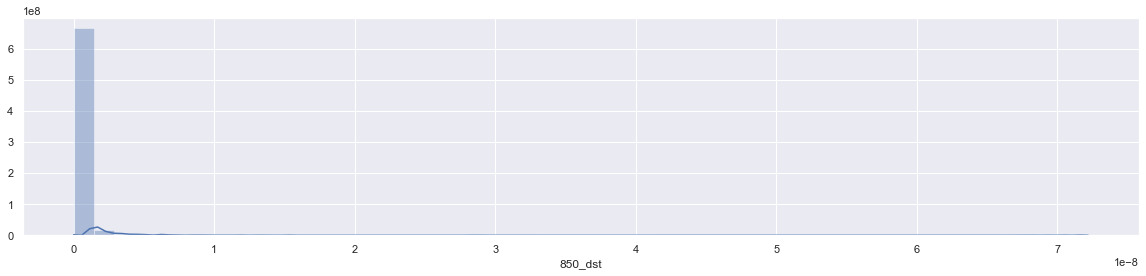

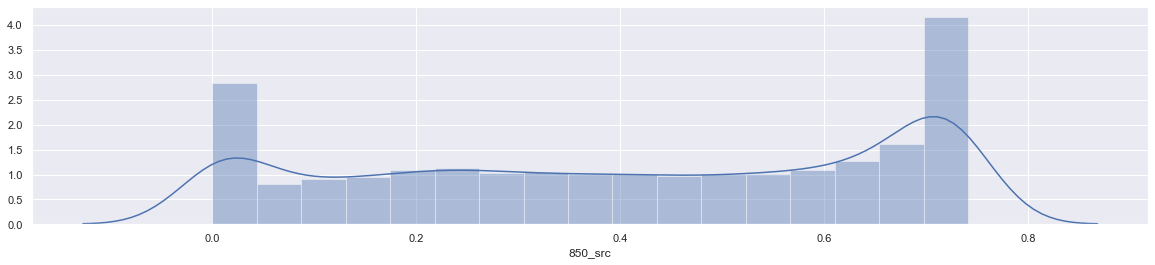

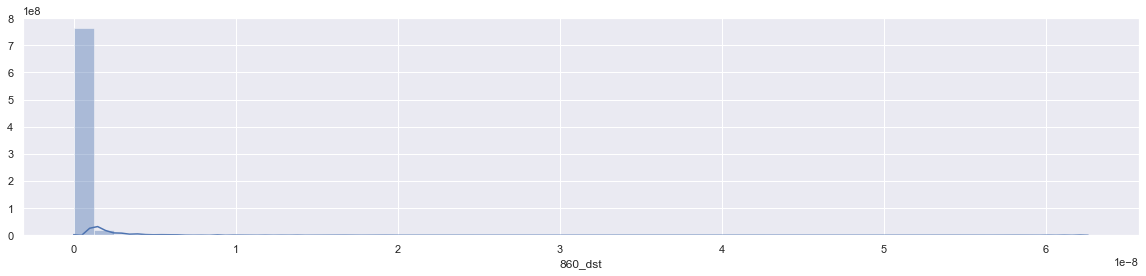

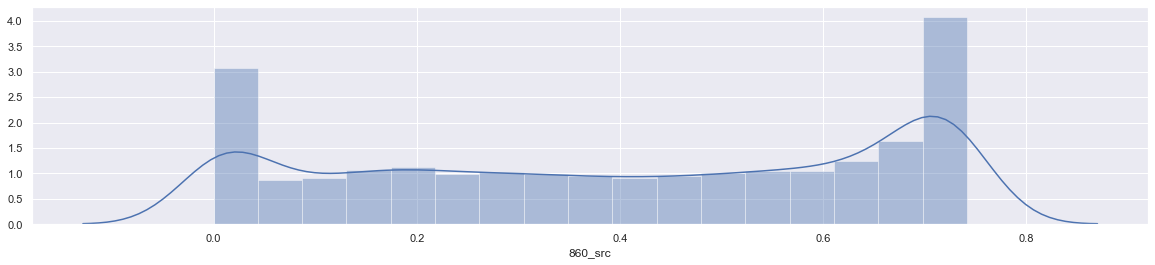

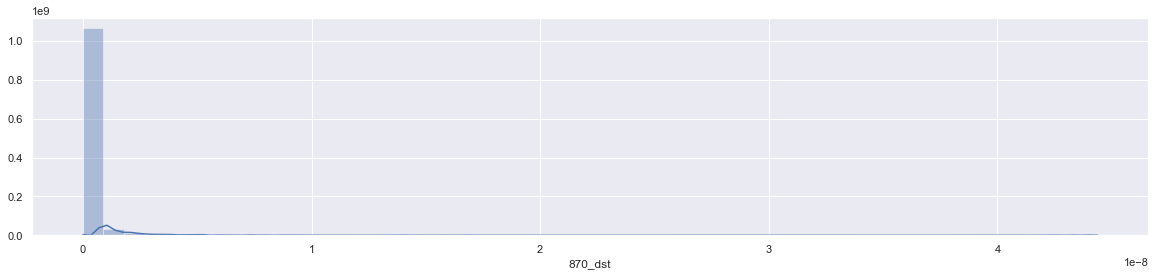

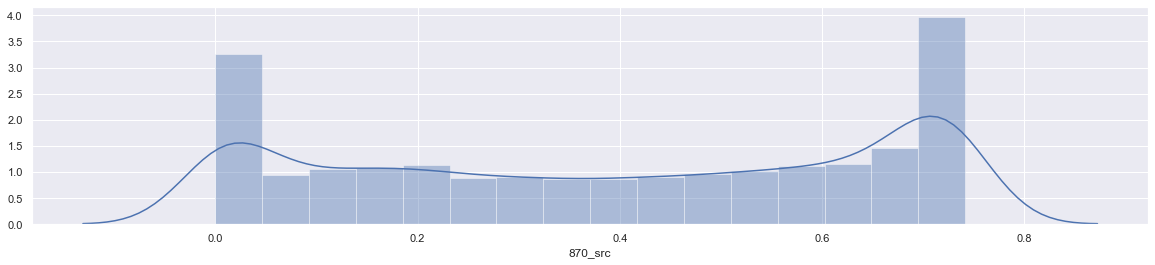

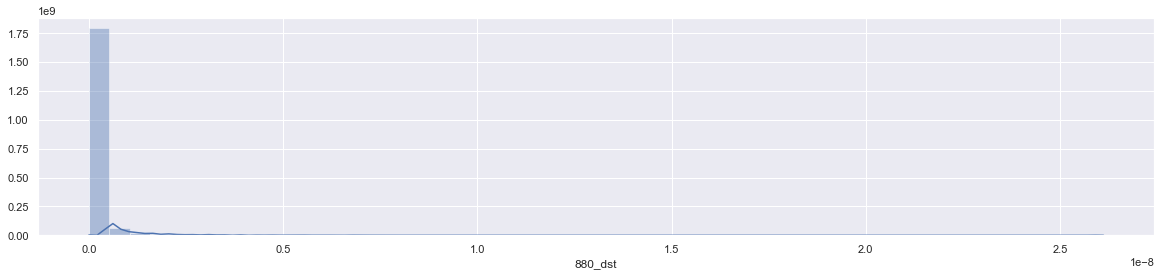

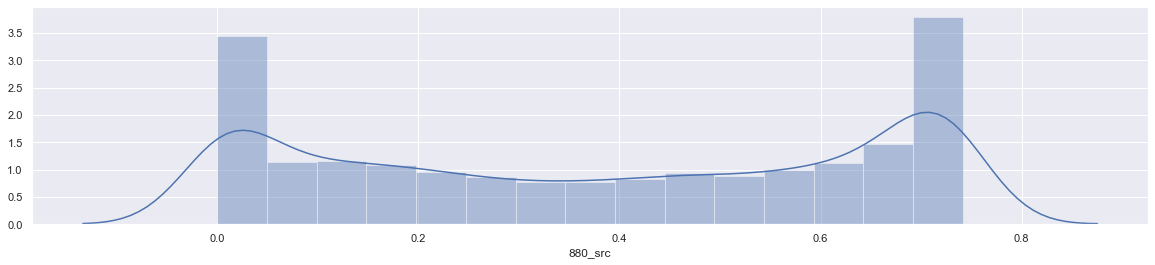

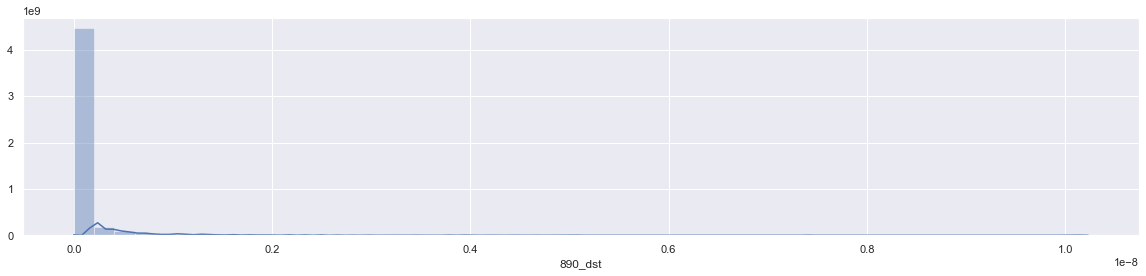

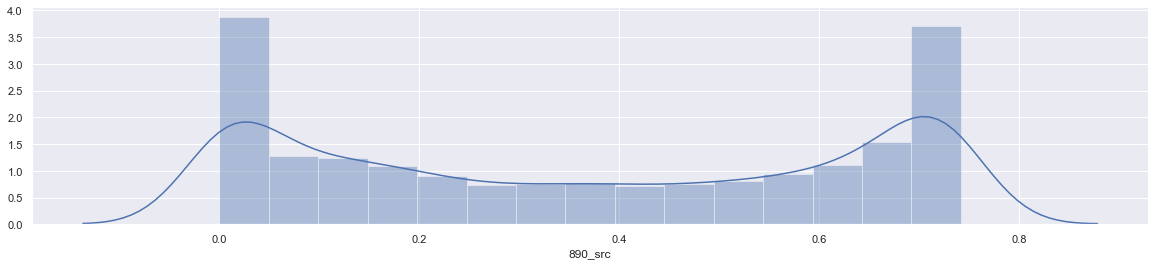

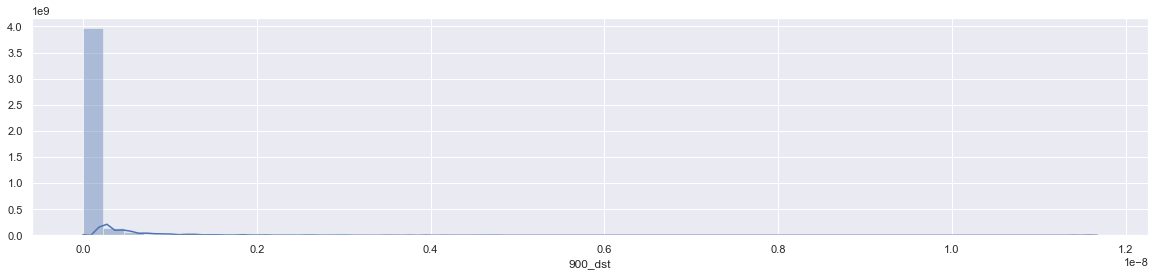

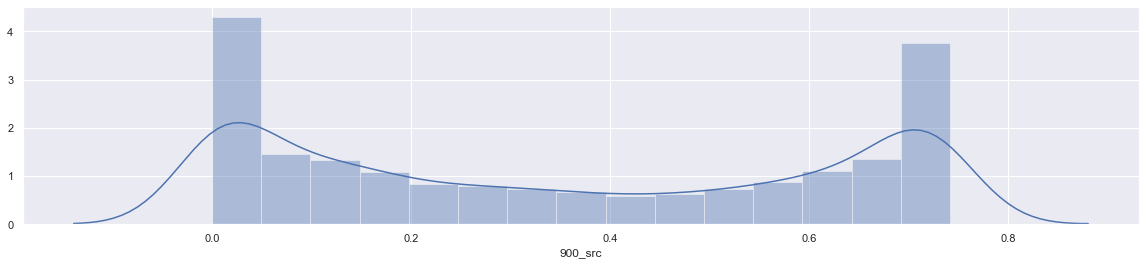

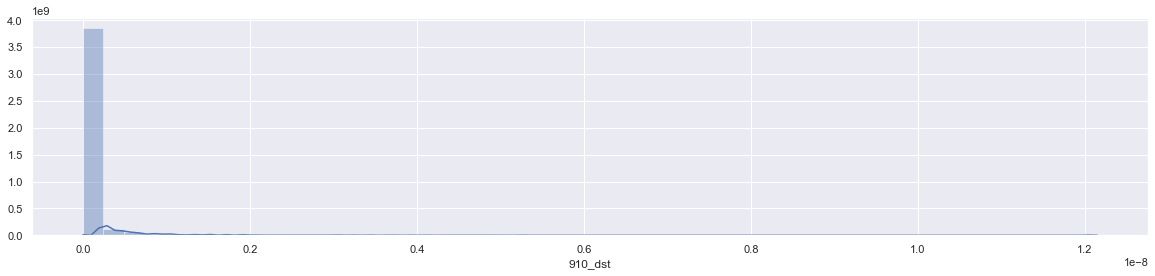

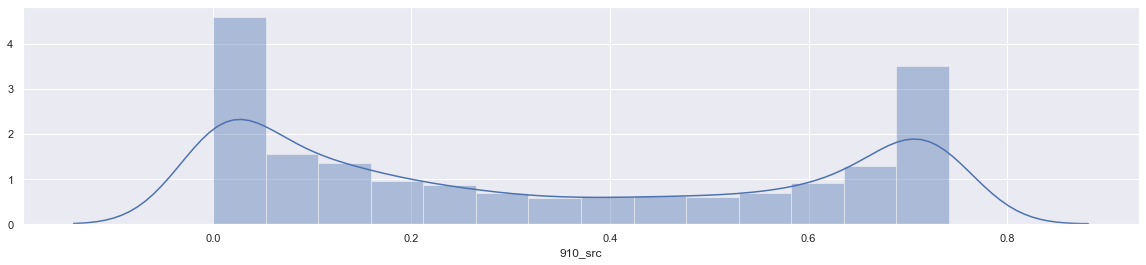

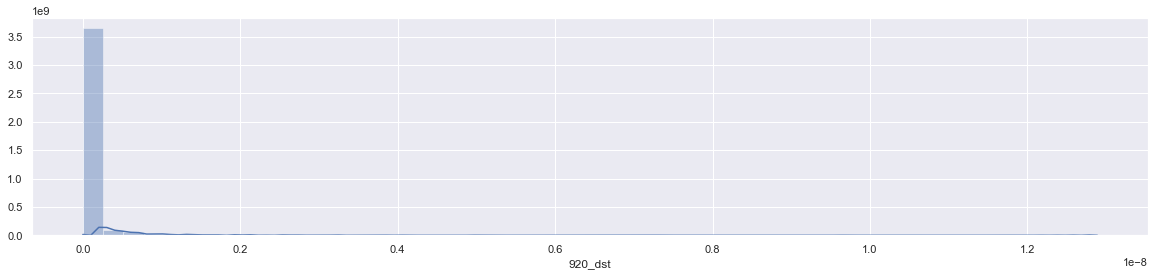

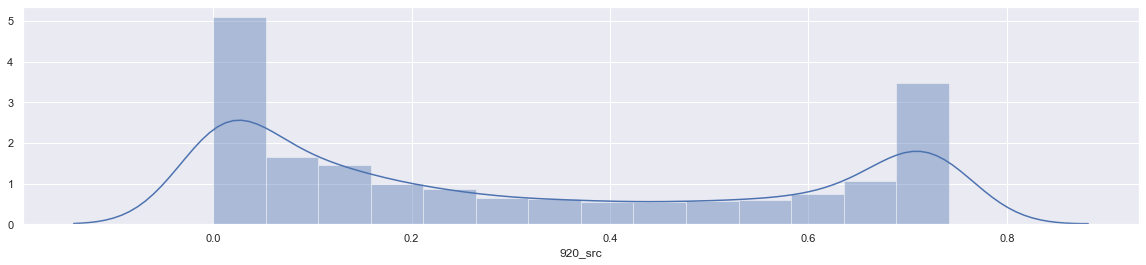

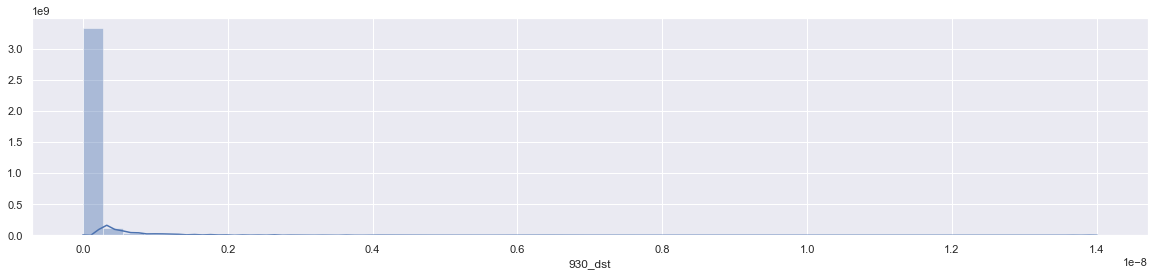

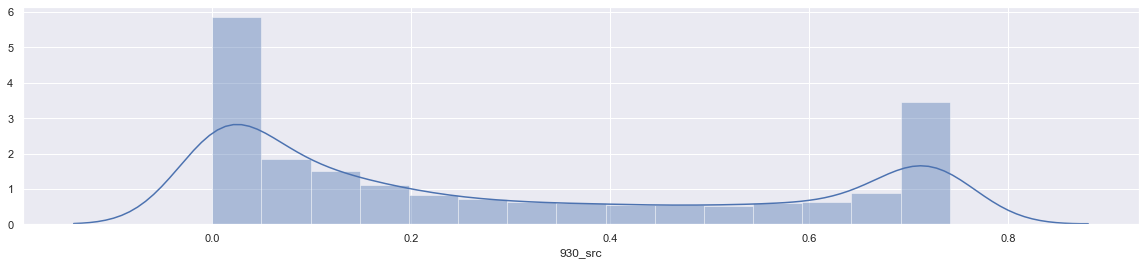

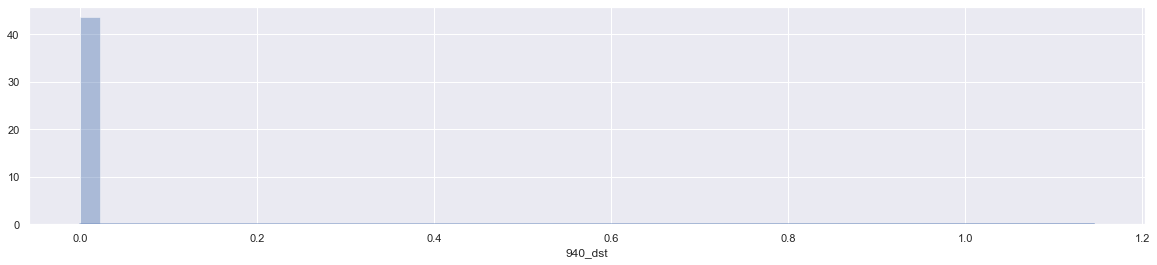

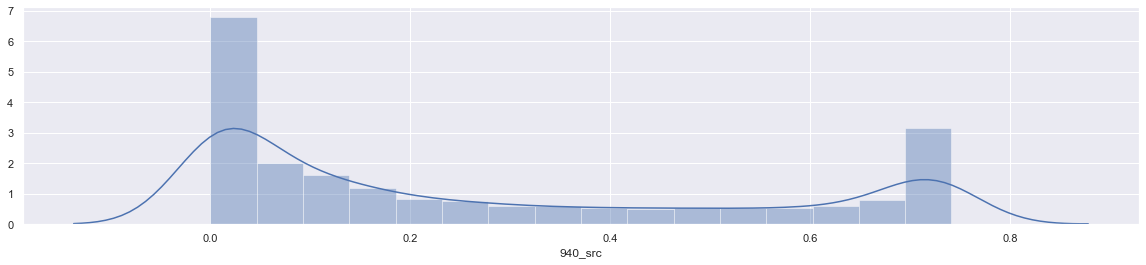

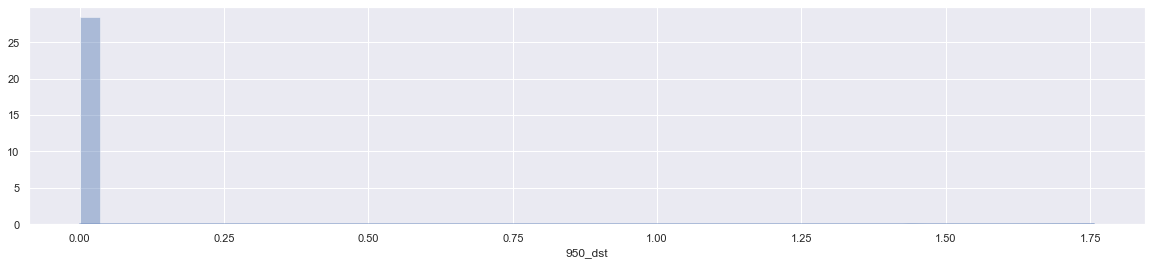

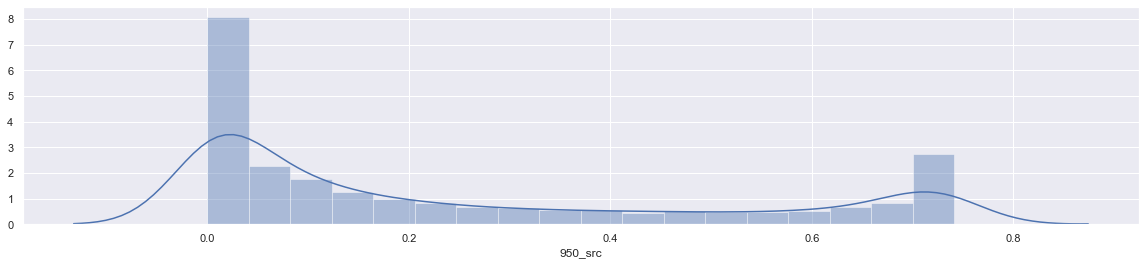

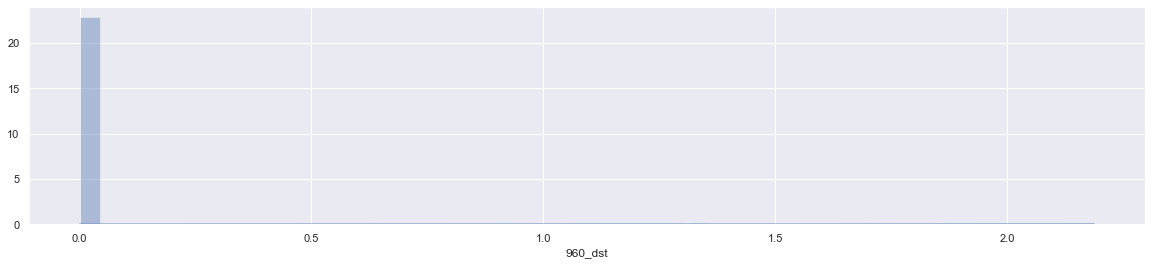

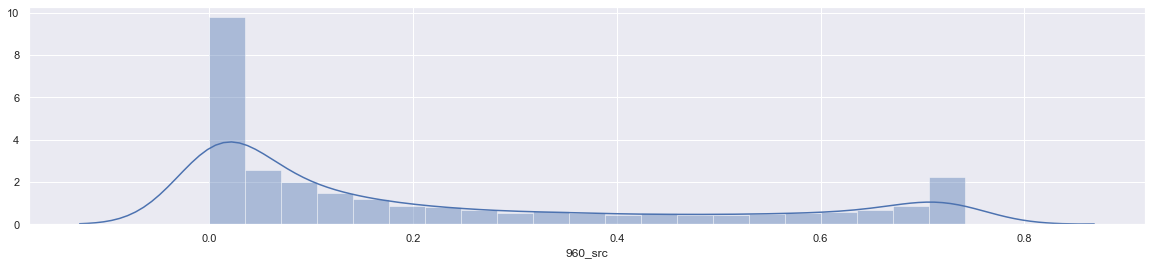

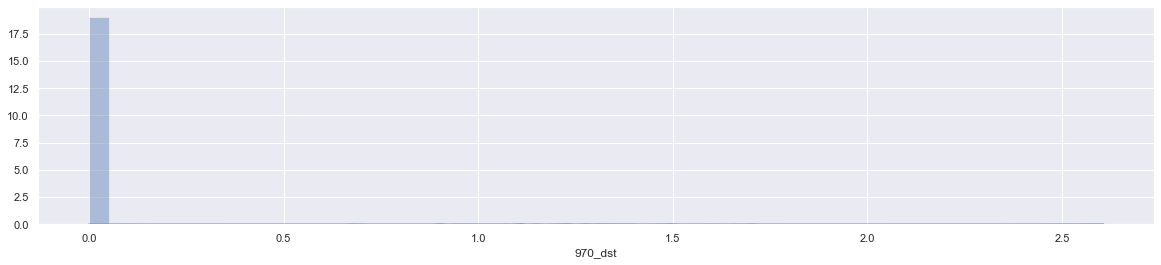

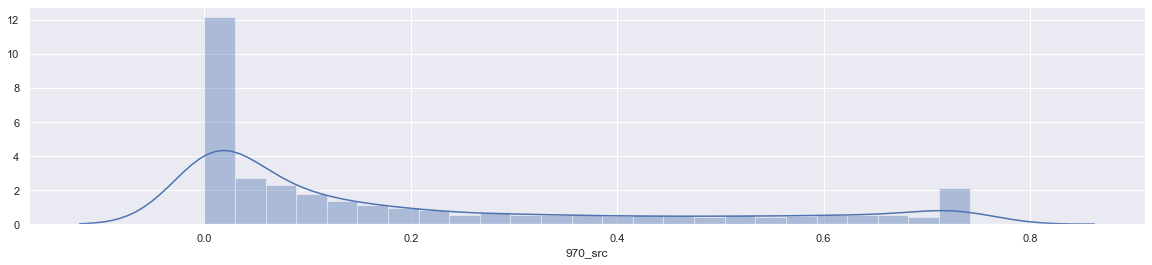

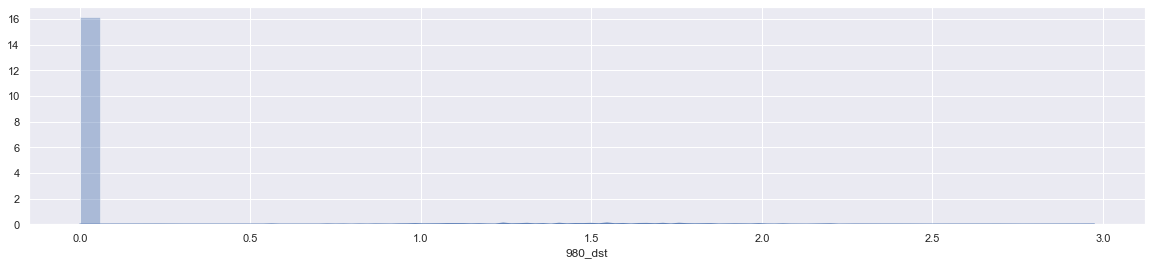

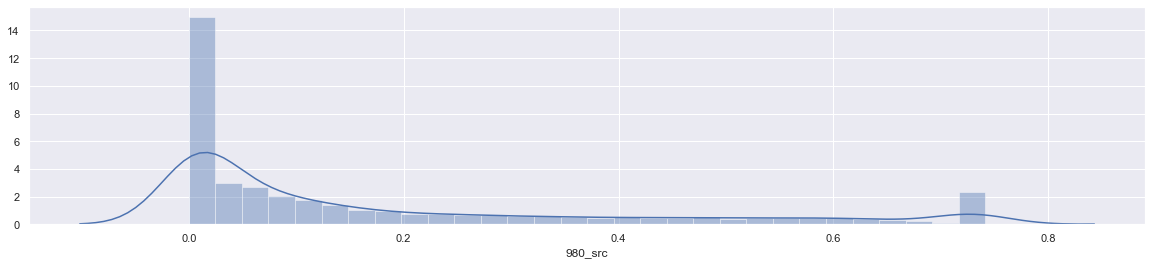

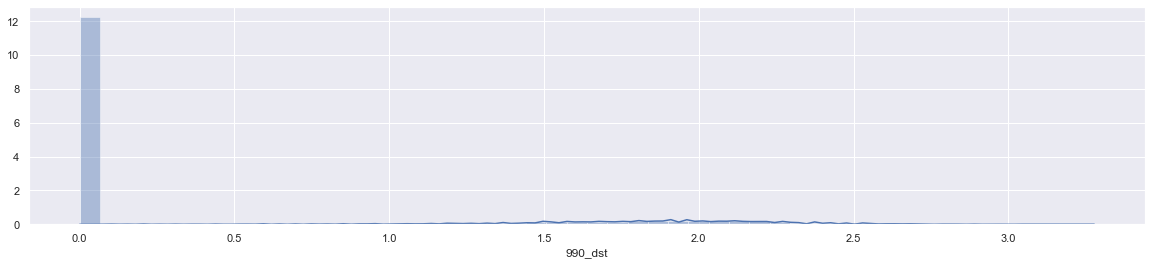

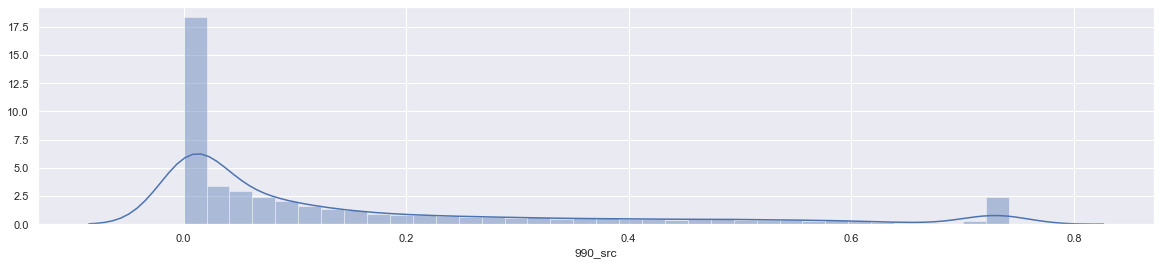

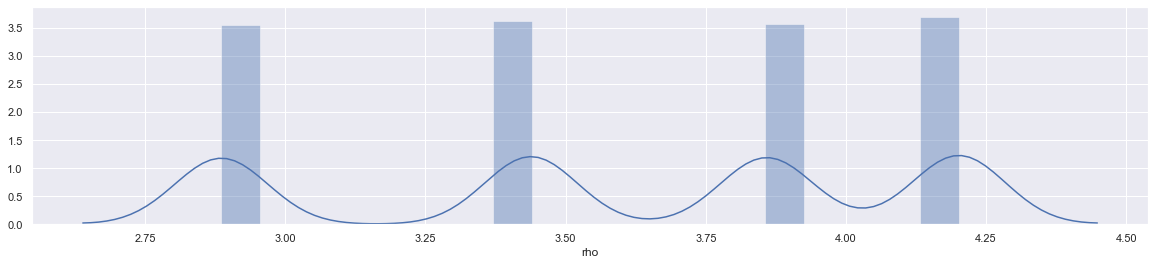

In [50]:
sns.set()
for col in train_skew.columns:
    fig,ax = plt.subplots(1, 1, figsize=(20,4))
    sns.distplot(train_skew[col])

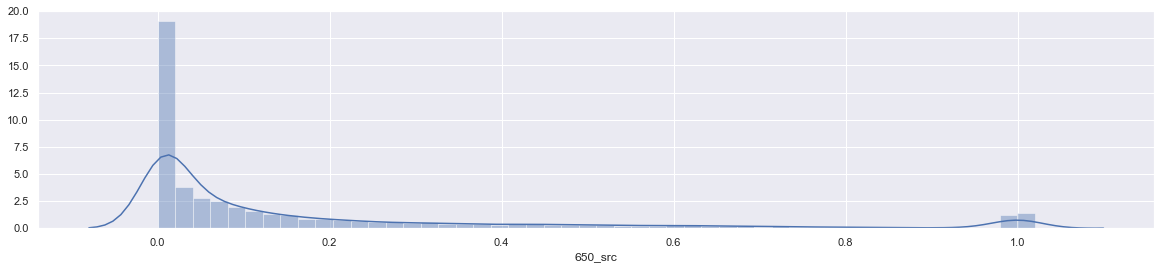

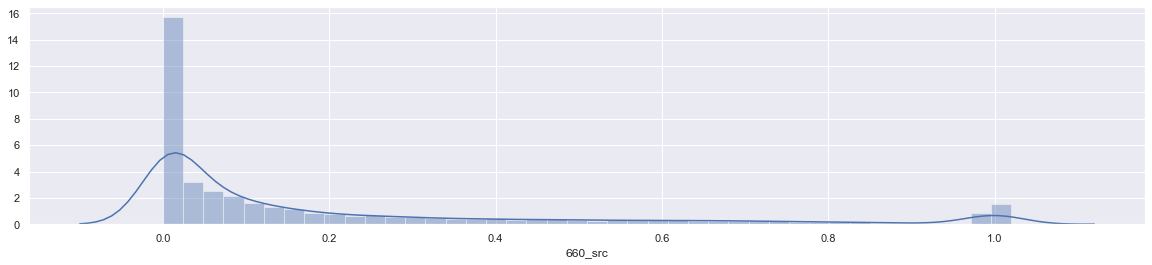

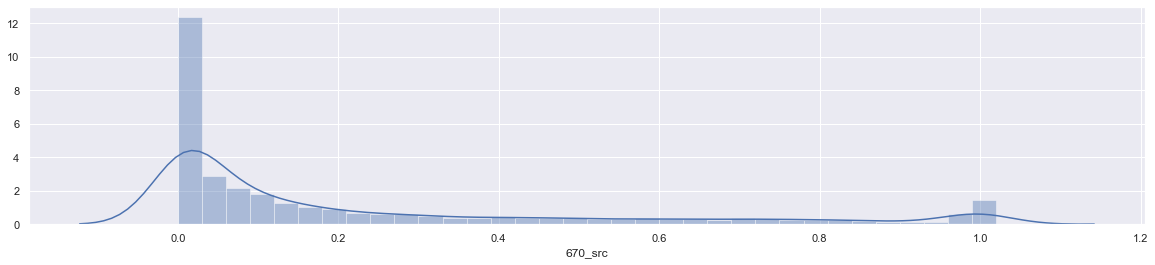

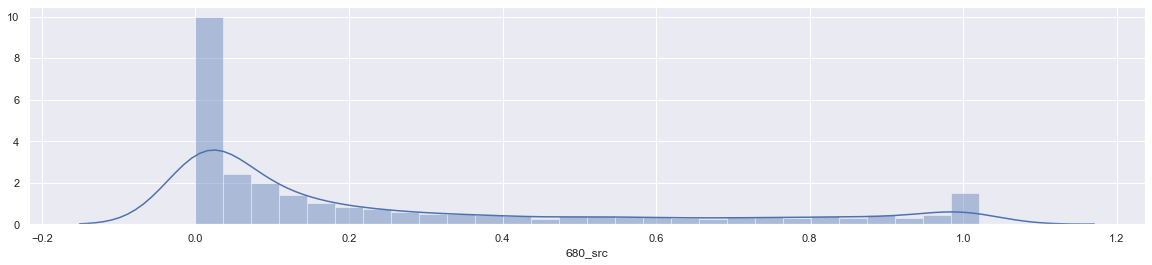

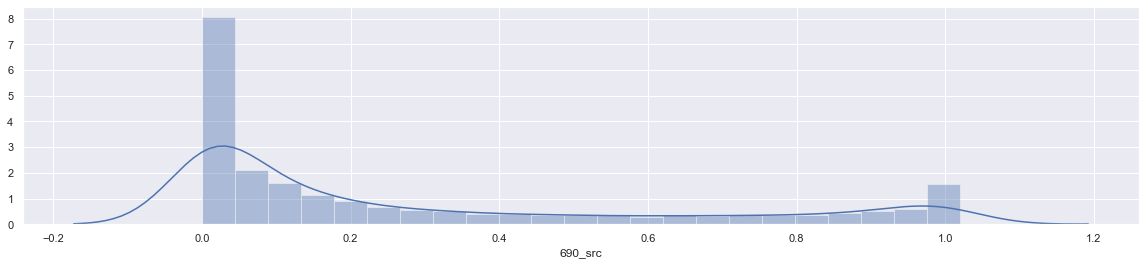

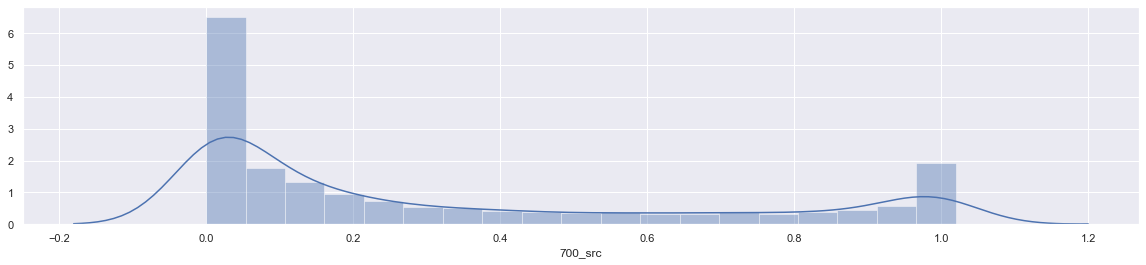

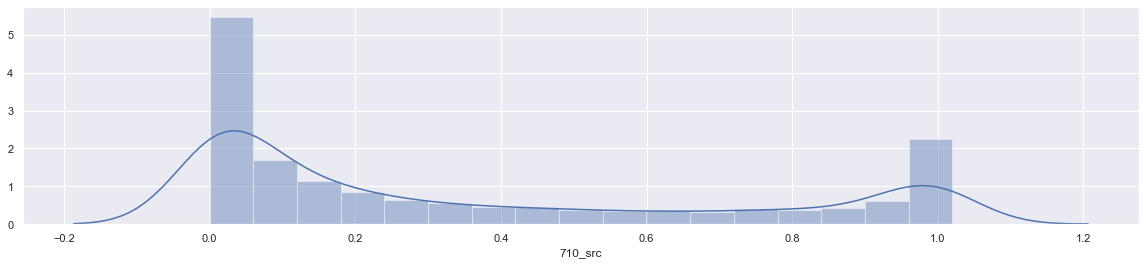

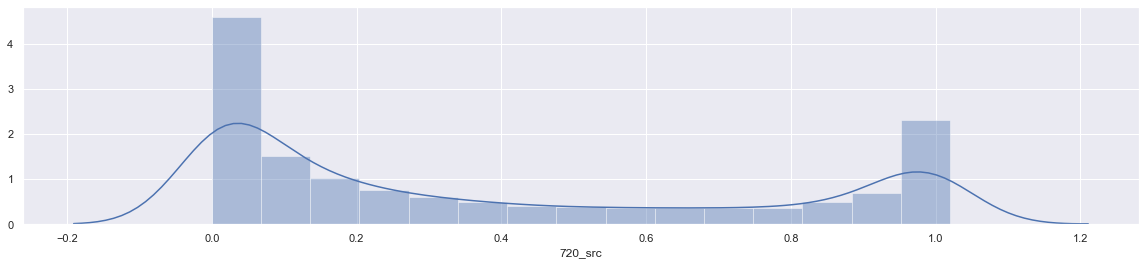

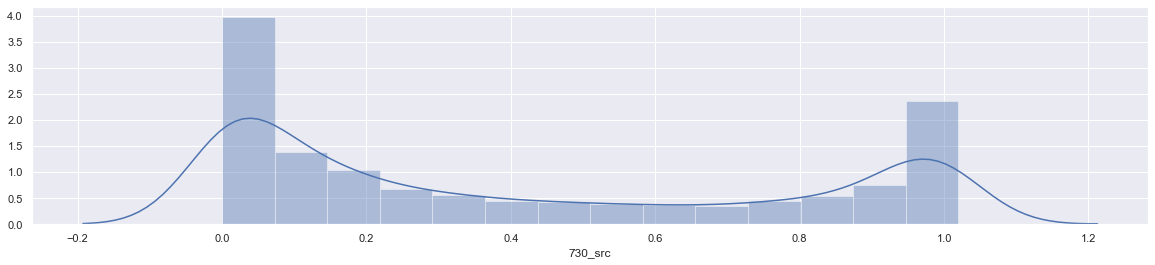

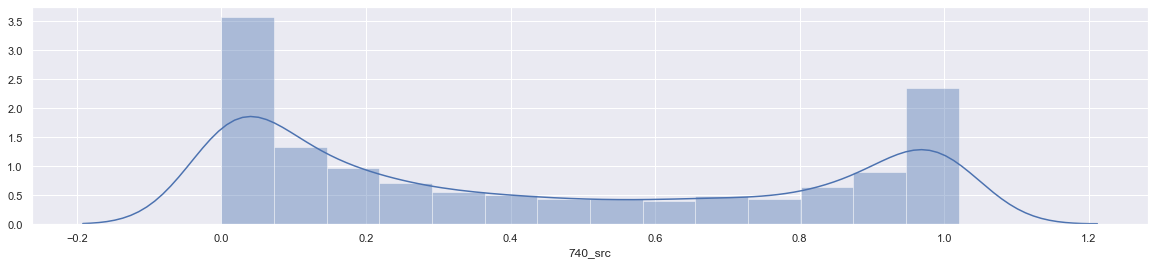

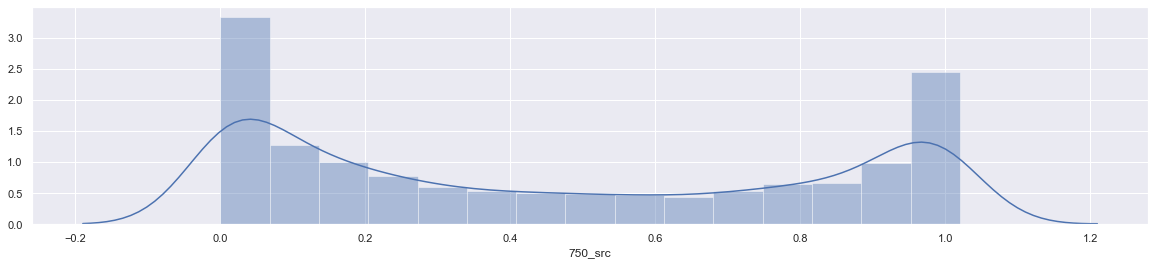

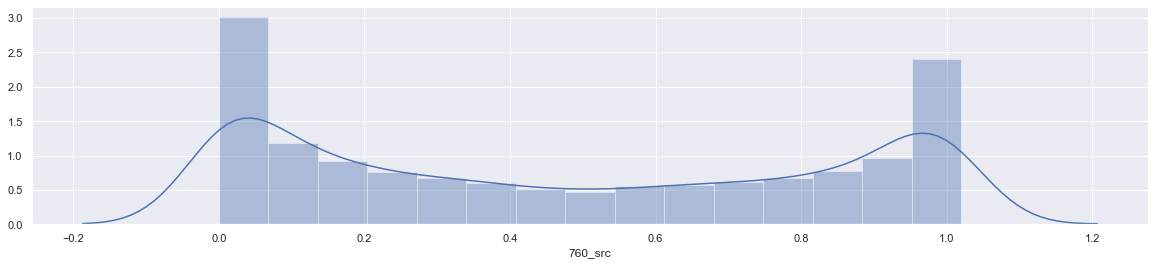

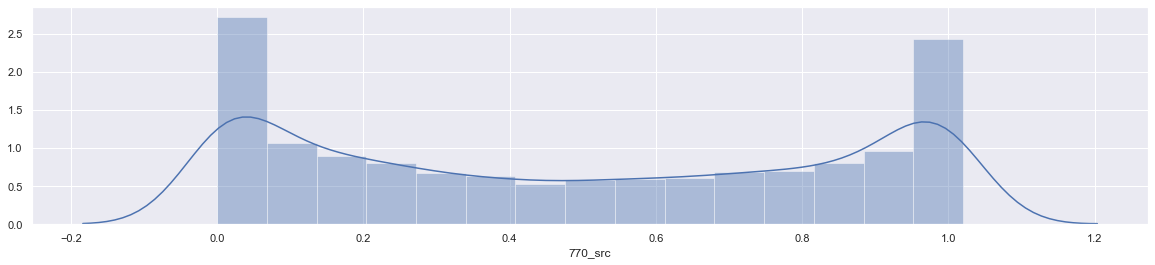

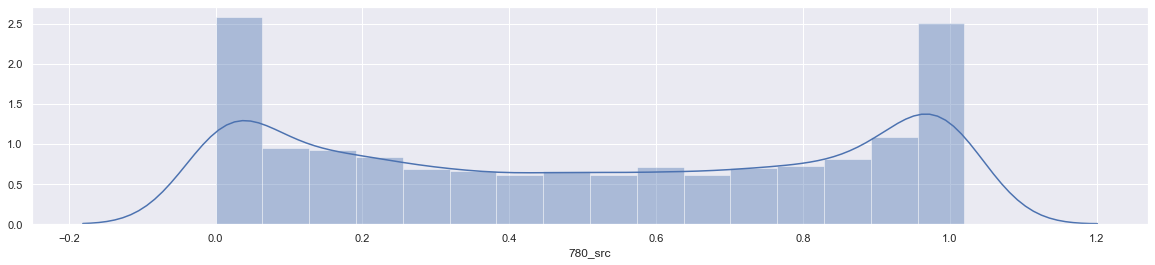

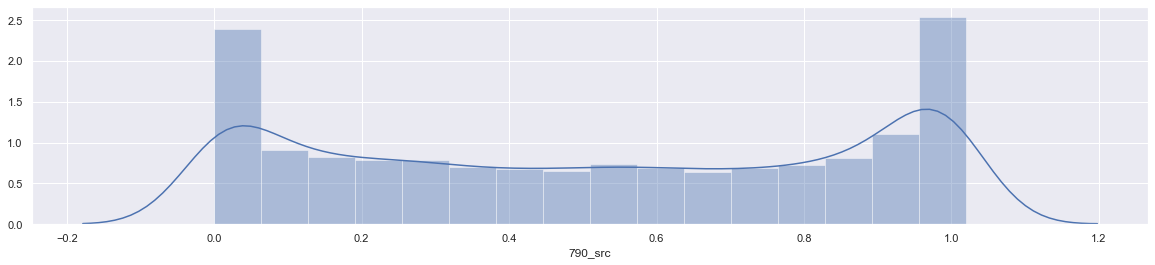

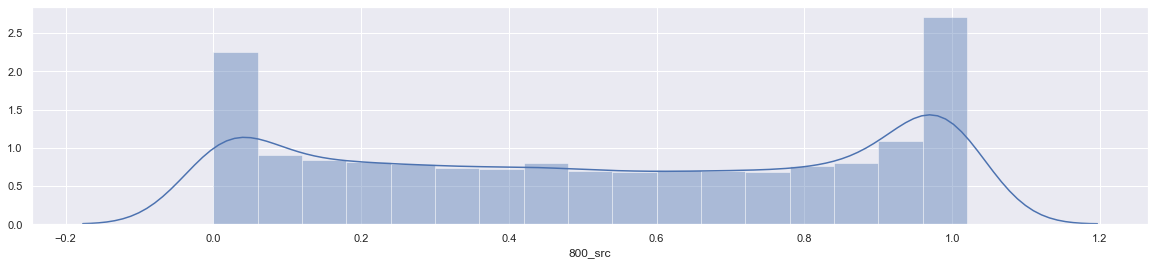

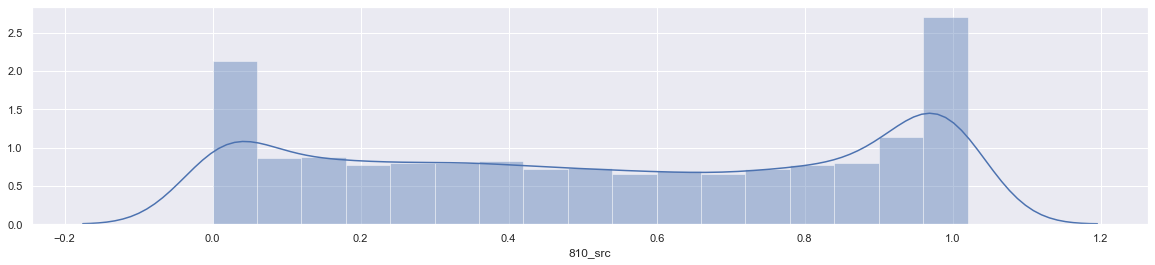

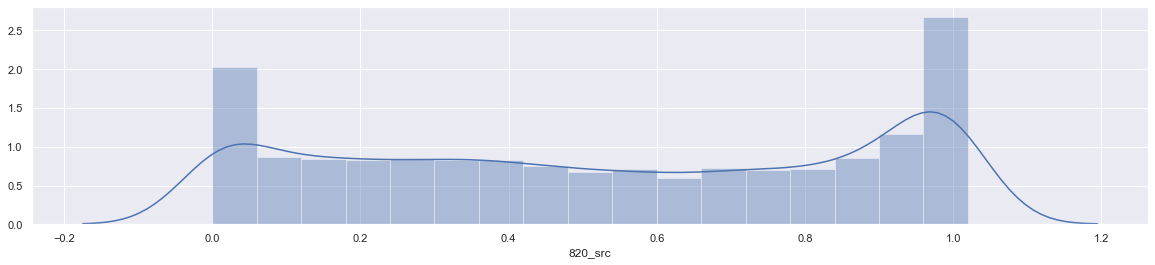

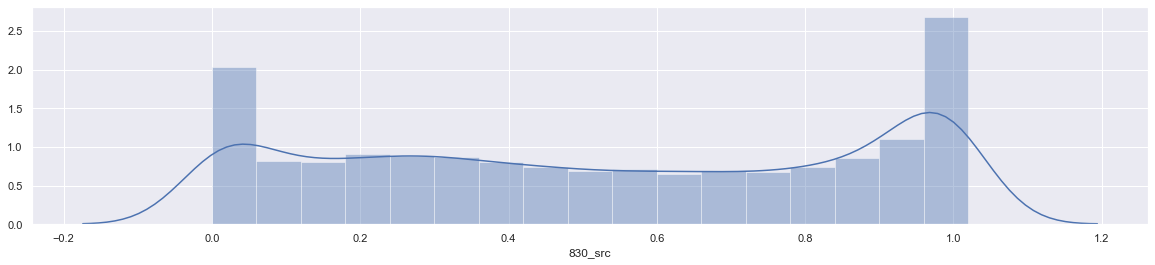

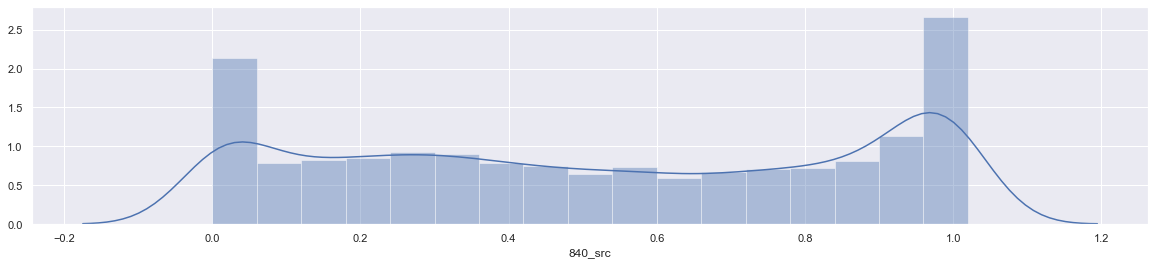

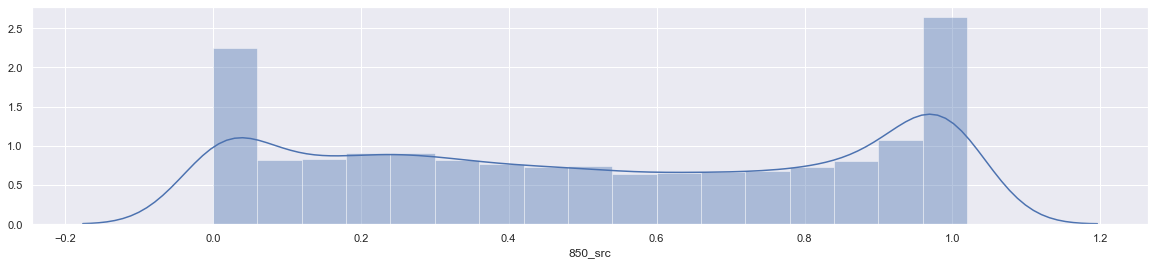

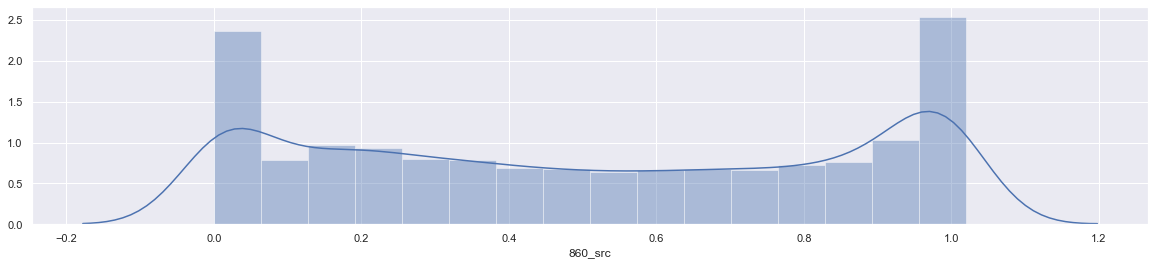

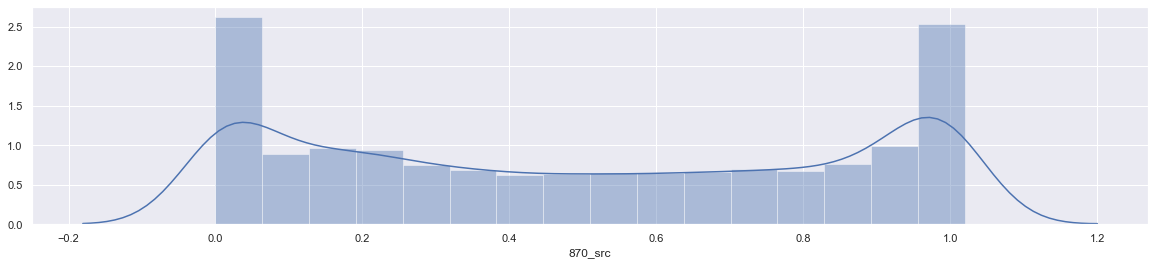

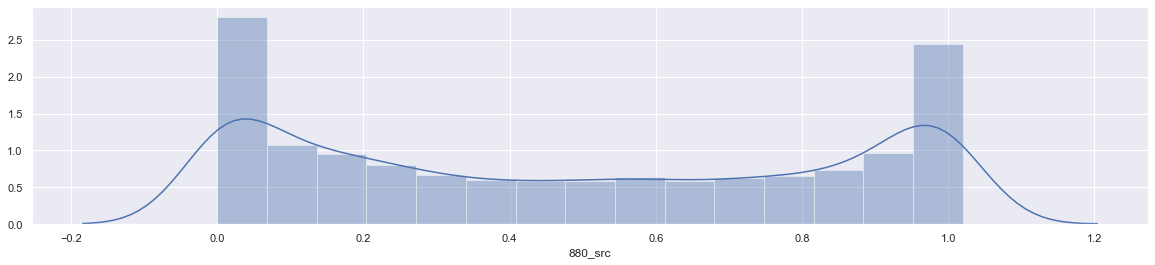

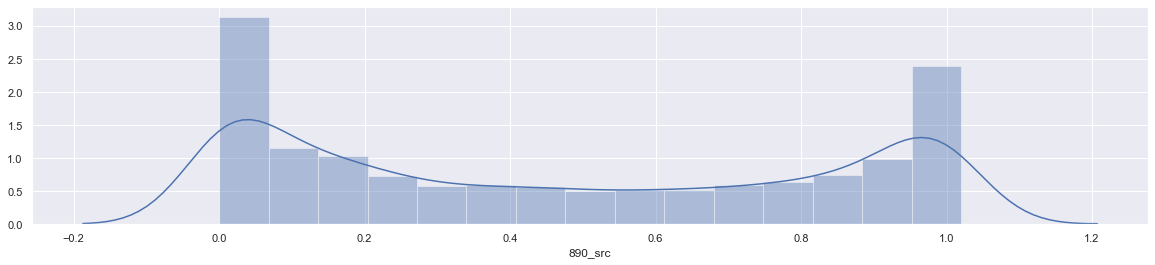

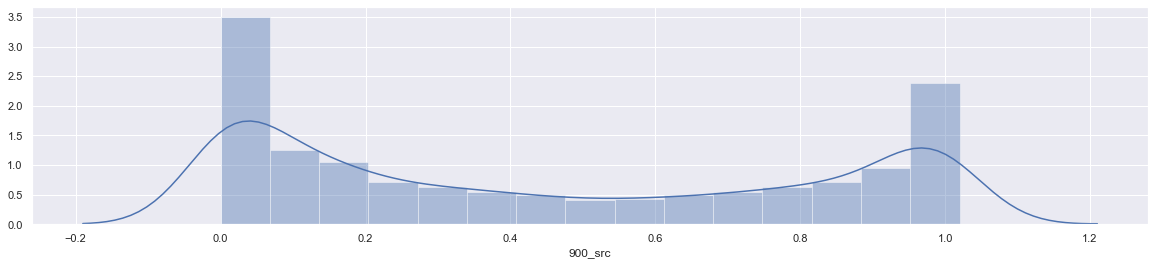

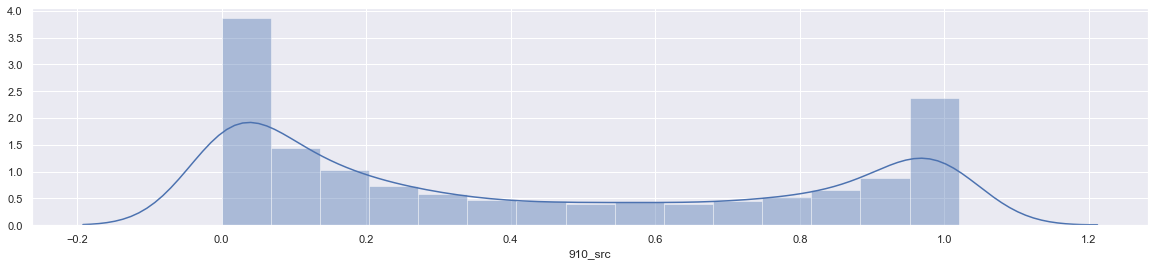

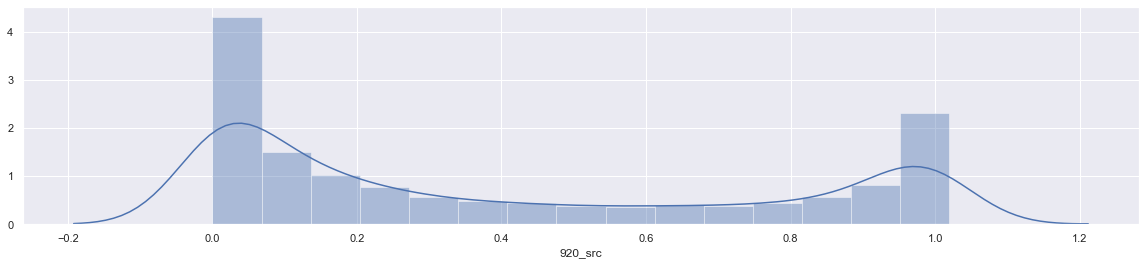

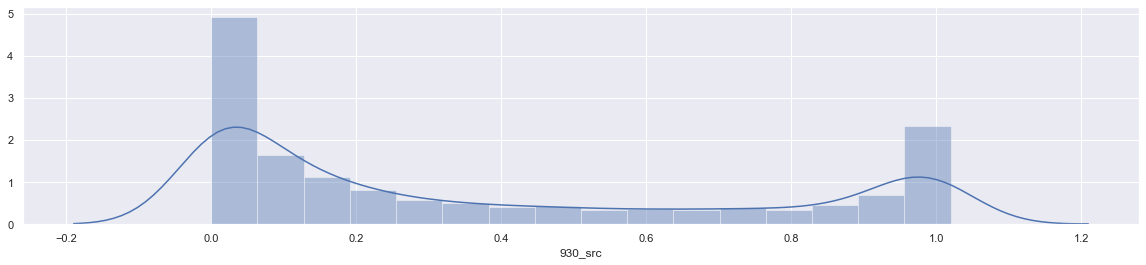

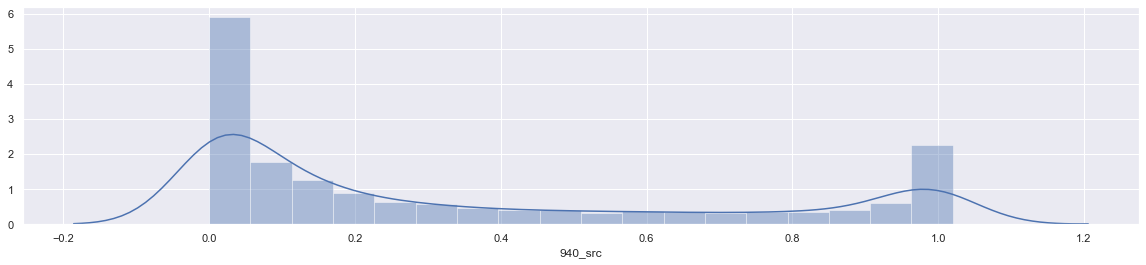

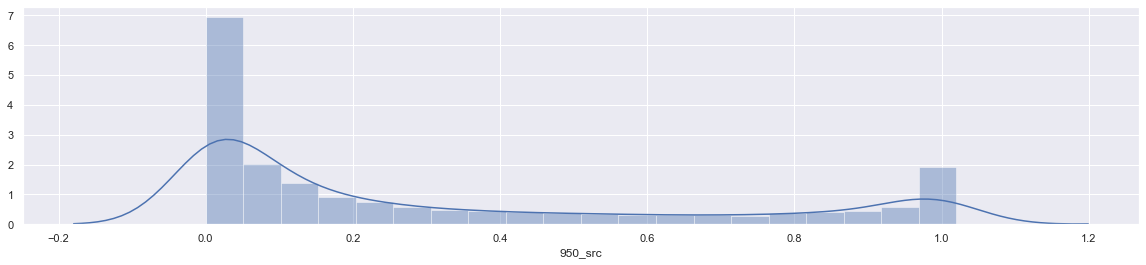

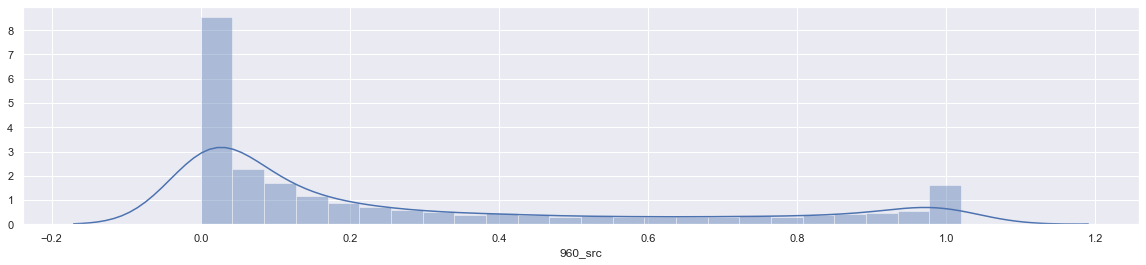

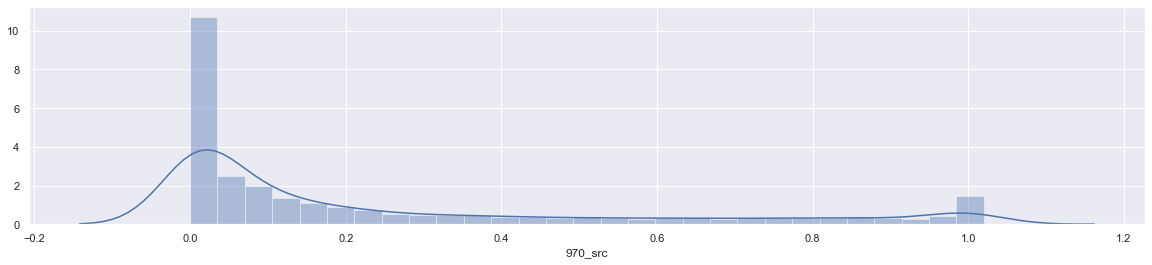

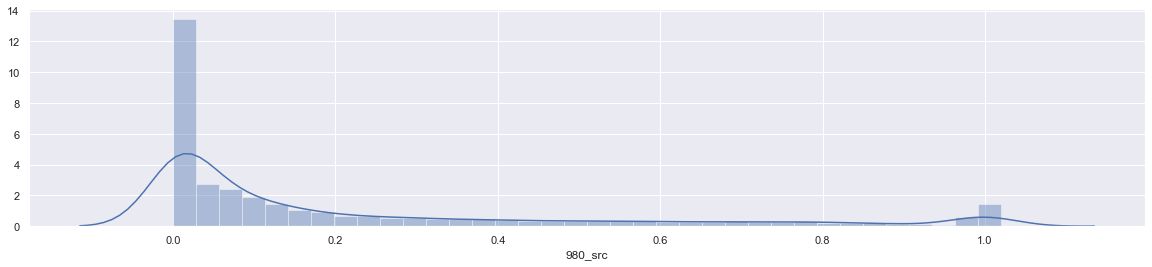

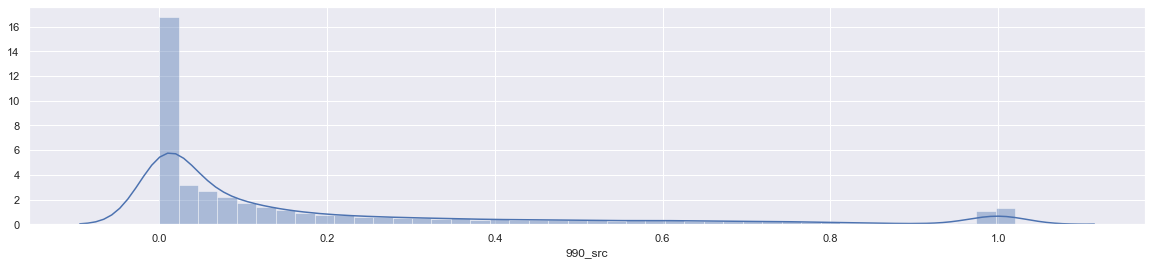

In [51]:
sns.set()
for col in columns:
    fig,ax = plt.subplots(1, 1, figsize=(20,4))
    sns.distplot(train[col])

In [142]:
# skew까지 하고 나서 xgboost_2

def train_model(x_data, y_data, k=5):
    models = []
    
    k_fold = KFold(n_splits=k, shuffle=True, random_state=123)
    
    for train_idx, val_idx in k_fold.split(x_data):
        x_train, y_train = x_data.iloc[train_idx], y_data[train_idx]
        x_val, y_val = x_data.iloc[val_idx], y_data[val_idx]
    
        d_train = xgb.DMatrix(data = x_train, label = y_train)
        d_val = xgb.DMatrix(data = x_val, label = y_val)
        
        wlist = [(d_train, 'train'), (d_val, 'eval')]
        
        params = {
            'max_depth': 7,
            'learning_rate' : 0.3,
            'objective': 'reg:squarederror',
            'eval_metric': 'mae',
            'subsample' : 0.5,
            'colsample_bytree': 0.8,
            'seed': 777
            }

        model = xgb.train(params=params, dtrain=d_train, num_boost_round=1000, early_stopping_rounds=100, verbose_eval=500, evals=wlist)
        models.append(model)
    
    return models

In [45]:
test_skew.head()

,650_dst,650_src,660_dst,660_src,670_dst,670_src,680_dst,680_src,690_dst,690_src,...,950_src,960_dst,960_src,970_dst,970_src,980_dst,980_src,990_dst,990_src,rho
10000,0.000000e+00,-0.100003,5.772480e-15,0.097134,1.731744e-14,0.236026,5.908564e-14,0.435195,2.227654e-13,0.520333,...,-1.511436,2.537328e-15,-1.529712,0.000000e+00,-1.147005,3.420671e-15,-1.204531,5.473074e-15,-0.962816,3.438110
10001,1.237485e-03,0.794859,6.151341e-13,0.871071,2.933070e-14,0.961805,4.499926e-12,1.043677,2.361108e-13,1.044661,...,-1.741046,4.050037e-15,-1.387656,9.156903e-15,-1.344016,1.176687e-14,-1.114783,1.756915e-14,-1.060683,3.438110
10002,2.134032e-12,0.762146,3.001690e-11,0.856236,3.284127e-11,0.881363,1.301796e-11,0.961334,4.597653e-11,1.000553,...,-0.872679,1.635328e-12,-0.920139,1.519016e-12,-0.665634,1.139262e-12,-0.687621,9.114097e-13,-0.567939,2.885846
10003,0.000000e+00,-0.503259,0.000000e+00,-0.563026,0.000000e+00,-0.517311,1.337172e-11,-0.401364,8.630767e-11,-0.452841,...,-1.679758,0.000000e+00,-1.353595,4.117442e-13,-1.230946,3.837508e-12,-0.911082,3.070007e-12,-0.963160,2.885846
10004,0.000000e+00,-0.974319,6.620170e-17,-1.044454,8.045087e-17,-1.091453,1.231984e-16,-1.406165,0.000000e+00,-1.636280,...,1.174242,0.000000e+00,1.188661,0.000000e+00,1.225299,1.785771e-17,1.243078,1.656578e-16,1.201379,4.201461


In [62]:
x_train_skew = train_skew
y_train_skew = train.loc[:, 'hhb':'na']

In [143]:
models = {}
for label in y_train_skew.columns:
    print('train column : ', label)
    models[label] = train_model(x_train_skew, y_train_skew[label])
    print('\n\n')

train column :  hhb
[0]	train-mae:5.30369	eval-mae:5.28915
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 100 rounds.
Stopping. Best iteration:
[80]	train-mae:0.34137	eval-mae:1.04827

[0]	train-mae:5.30914	eval-mae:5.25212
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 100 rounds.
Stopping. Best iteration:
[76]	train-mae:0.34327	eval-mae:1.02389

[0]	train-mae:5.29913	eval-mae:5.31300
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 100 rounds.
Stopping. Best iteration:
[54]	train-mae:0.46259	eval-mae:1.00727

[0]	train-mae:5.28216	eval-mae:5.31019
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 100 rounds.
Stopping. Best iteration:
[62]	train-mae:0.41137	eval-m

KeyboardInterrupt: 

In [208]:
# # bagging(데이터 복원추출) 후 lgb 적용 반복

# import random

# def train_model(x_data, y_data, k=5):
#     models = []
    
#     k_fold = KFold(n_splits=k, shuffle=True, random_state=123)
    
#     bagging_predict_model = []
    
#     for train_idx, val_idx in k_fold.split(x_data):
#         x_train, y_train = x_data.iloc[train_idx], y_data[train_idx]
#         x_val, y_val = x_data.iloc[val_idx], y_data[val_idx]
        
#         models = []

#         for _ in range(30): 
#             train_data_index = [train_data_index for train_data_index in range(x_train.shape[0])] # x_train 개수만큼
#             random_data_index = np.random.choice(train_data_index, x_train.shape[0]) #추출할 변수:train_data_index, 추출할 요소의 개수:x_train.shape[0]
            
#             val_data_index = [val_data_index for val_data_index in range(x_val.shape[0])]
#             random_data_index2 = np.random.choice(val_data_index, x_val.shape[0])
            
#             d_train = lgb.Dataset(data = x_train.iloc[random_data_index], label = y_train.iloc[random_data_index])
#             d_val = lgb.Dataset(data = x_val.iloc[random_data_index2], label = y_val.iloc[random_data_index2])

#             wlist = {}

#             params = {
#                 'objective': 'regression',
#                 'metric': 'mae',
#                 'seed':777,
#             }

#             model = lgb.train(params=params,
#                               train_set=d_train,
#                               num_boost_round=500,
#                               verbose_eval=100,
#                               evals_result=wlist)
            
#             models.append(model)
            
#             #predict1 = model.predict(lgb.Dataset(test))
#             #bagging_predict.append(predict1)
        
#         bagging_predict_model.append(models)
#         #bagging_predict_result.append(np.mean(bagging_predict))
        
#             #models.append(model)
    
#     return bagging_predict_model

In [209]:
# models_predict = {}
# for label in y_train.columns:
#     print('train column : ', label)
#     models_predict[label] = train_model(x_train, y_train[label])

train column :  hhb
train column :  hbo2
train column :  ca
train column :  na


In [213]:
# models_predict

{'hhb': [[<lightgbm.basic.Booster at 0x19ec27d4048>,
 'hbo2': [[<lightgbm.basic.Booster at 0x19ecff1a390>,
 'ca': [[<lightgbm.basic.Booster at 0x19ed0f5c860>,
 'na': [[<lightgbm.basic.Booster at 0x19ec2a2d748>,
   <lightgbm.basic.Booster at 0x19ed1dc66d8>]]}

In [234]:
# for col in models_predict:
#     print(col)
#     preds = []
#     for model_list in models_predict[col]:
#         for i in range(len(model_list)):
#             preds.append(model_list[i].predict(test))

#     preds_result = np.mean(preds, axis=0)
#     submission[col] = preds_result

hhb
hbo2
ca
na


In [235]:
# submission.head()

,id,hhb,hbo2,ca,na
0,10000,8.005074,4.474275,8.571544,3.569099
1,10001,5.473688,4.246903,8.571602,2.606729
2,10002,9.048577,4.801982,10.261452,3.535404
3,10003,7.702145,4.524639,11.151717,3.284557
4,10004,8.446068,3.281861,7.964039,4.134805


In [236]:
# submission.to_csv('4_Dacon_bio_lgb.csv', index=False)

- 리더보드 점수 : 1.4431578511

# LightGBM 2

In [247]:
# 2

def train_model(x_data, y_data, k=5):
    models = []
    
    k_fold = KFold(n_splits=k, shuffle=True, random_state=123)
    
    for train_idx, val_idx in k_fold.split(x_data):
  
        x_train, y_train = x_data.iloc[train_idx,:], y_data[train_idx]
        x_val, y_val = x_data.iloc[val_idx,:], y_data[val_idx]

        d_train = lgb.Dataset(data = np.array(x_train), label =(y_train))
 
        d_val = lgb.Dataset(data = np.array(x_val), label = np.array(y_val))

        wlist = {}
       
        params = {
            'max_depth':20,
            'learning_rate':0.1,
            'num_leaves':100,
            'objective':'regression',
            'metric':'mae',
            'seed':777,
            'feature_fraction':0.8,
            'bagging_fraction':0.8,
            'num_boost_round':10000,
            'early_stopping_rounds':50
            }

        model = lgb.train(params=params,
                          train_set=d_train,
                          valid_sets = [d_train, d_val],
                          valid_names = ['train', 'eval'],
                          verbose_eval=100,
                          evals_result=wlist)
        
        models.append(model)
    
    return models

In [242]:
models = {}
for label in y_train.columns:
    print('train column : ', label)
    models[label] = train_model(x_train, y_train[label])
    print('\n\n')

train column :  hhb
Training until validation scores don't improve for 50 rounds
[100]	train's l1: 0.301238	eval's l1: 0.83397
[200]	train's l1: 0.133277	eval's l1: 0.817526
[300]	train's l1: 0.0650926	eval's l1: 0.814635
[400]	train's l1: 0.0324323	eval's l1: 0.813546
[500]	train's l1: 0.0166278	eval's l1: 0.813111
Early stopping, best iteration is:
[492]	train's l1: 0.0176099	eval's l1: 0.813079
Training until validation scores don't improve for 50 rounds
[100]	train's l1: 0.302656	eval's l1: 0.804844
[200]	train's l1: 0.133875	eval's l1: 0.793798
[300]	train's l1: 0.0647607	eval's l1: 0.7906
[400]	train's l1: 0.0327476	eval's l1: 0.789846
Early stopping, best iteration is:
[389]	train's l1: 0.0353076	eval's l1: 0.789725
Training until validation scores don't improve for 50 rounds
[100]	train's l1: 0.302933	eval's l1: 0.803868
[200]	train's l1: 0.136594	eval's l1: 0.787226
[300]	train's l1: 0.0658296	eval's l1: 0.783811
[400]	train's l1: 0.0329956	eval's l1: 0.782195
[500]	train's l1

In [212]:
for col in models:
    preds = []
    for model in models[col]:
        preds.append(model.predict(test))
    pred = np.mean(preds, axis=0)

    submission[col] = pred

In [213]:
submission.head()

,id,hhb,hbo2,ca,na
0,10000,8.608163,4.514646,9.316729,3.779909
1,10001,6.492141,3.503804,8.572464,2.988432
2,10002,9.673231,5.440983,10.150897,4.139341
3,10003,8.484264,4.141213,10.538485,3.400969
4,10004,6.716666,3.517080,8.303691,4.209946


In [214]:
submission.to_csv('5_Dacon_bio_lgb2.csv', index=False)

- 리더보드 점수 : 1.1699360463

In [275]:
# 3

def train_model(x_data, y_data, k=5):
    models = []
    
    k_fold = KFold(n_splits=k, shuffle=True, random_state=123)
    
    for train_idx, val_idx in k_fold.split(x_data):
  
        x_train, y_train = x_data.iloc[train_idx,:], y_data[train_idx]
        x_val, y_val = x_data.iloc[val_idx,:], y_data[val_idx]

        d_train = lgb.Dataset(data = np.array(x_train), label =(y_train))
 
        d_val = lgb.Dataset(data = np.array(x_val), label = np.array(y_val))

        wlist = {}
       
        params = {
            'max_depth':25,
            'learning_rate':0.1,
            'num_leaves':110,
            'max_bin':250,
            'objective':'regression',
            'metric':'mae',
            'seed':777,
            'feature_fraction':0.6,
            'bagging_fraction':0.8,
            'num_boost_round':10000,
            'early_stopping_rounds':50
            }

        model = lgb.train(params=params,
                          train_set=d_train,
                          valid_sets = [d_train, d_val],
                          valid_names = ['train', 'eval'],
                          verbose_eval=100,
                          evals_result=wlist,)
        
        models.append(model)
    
    return models

In [276]:
models = {}
lgbm_oof_train = {}
lgbm_oof_test = {}
for label in y_train.columns:
    print('train column : ', label)
    models[label], lgbm_oof_train[label], lgbm_oof_test[label] = train_model(x_train, y_train[label])
    print('\n\n')

train column :  hhb
Training until validation scores don't improve for 50 rounds
[100]	train's l1: 0.282784	eval's l1: 0.835724
[200]	train's l1: 0.120687	eval's l1: 0.822888
[300]	train's l1: 0.0568216	eval's l1: 0.819739
[400]	train's l1: 0.0272408	eval's l1: 0.818601
Early stopping, best iteration is:
[431]	train's l1: 0.0218057	eval's l1: 0.818409
Training until validation scores don't improve for 50 rounds
[100]	train's l1: 0.287573	eval's l1: 0.813188
[200]	train's l1: 0.122656	eval's l1: 0.800472
[300]	train's l1: 0.0567516	eval's l1: 0.796883
[400]	train's l1: 0.0269037	eval's l1: 0.796152
[500]	train's l1: 0.0131713	eval's l1: 0.795618
[600]	train's l1: 0.0064816	eval's l1: 0.795553
[700]	train's l1: 0.00324381	eval's l1: 0.795383
Early stopping, best iteration is:
[723]	train's l1: 0.00277829	eval's l1: 0.795354
Training until validation scores don't improve for 50 rounds
[100]	train's l1: 0.285582	eval's l1: 0.818385
[200]	train's l1: 0.122623	eval's l1: 0.802993
[300]	train

In [277]:
for col in models:
    preds = []
    for model in models[col]:
        preds.append(model.predict(test))
    pred = np.mean(preds, axis=0)

    submission[col] = pred

In [278]:
submission.to_csv('7_Dacon_bio_lgb4.csv', index=False)

- 리더보드 점수 : 1.1615214245	

# LightGBM3 (skew & 변수 삭제/추가)

In [587]:
train_feature = train_copy2.columns.difference(['id','hhb','hbo2','ca','na'])
x_train2 = train_copy2[train_feature]
y_train2 = train_copy2.loc[:, 'hhb':'na']
test_2 = test_copy2.drop('id', axis=1)

display(x_train2)
display(y_train2)
display(test_2)

,1_mean_src,2_mean_src,3_mean_src,4_mean_src,5_mean_src,650_dst,650_gap,650_src,660_dst,660_gap,...,970_dst,970_gap,970_src,980_dst,980_gap,980_src,990_dst,990_gap,990_src,rho
0,0.934306,1.419557,1.011161,-0.232604,-0.730515,3.015579e-18,0.801001,0.730404,3.112100e-18,0.793821,...,1.330223e-19,-0.392589,-0.544647,5.606494e-19,-0.035314,-0.475339,3.273655e-18,0.374281,-0.495426,25.0
1,-0.754476,-1.025157,-1.382462,-1.582483,-1.227196,0.000000e+00,-0.579124,-0.660493,0.000000e+00,-0.696126,...,7.377344e-10,1.322693,1.581476,9.074851e-10,0.758796,1.383250,3.629941e-10,0.627384,1.216150,10.0
2,-0.666507,-0.505675,0.281011,1.303237,0.835591,2.066572e-19,-0.579124,-0.660493,6.182204e-20,-0.582143,...,0.000000e+00,-0.520933,-0.703732,1.242733e-19,-0.090279,-0.603984,3.977570e-01,-2.434066,-0.580715,25.0
3,0.415569,0.935464,1.305839,0.196239,-0.635424,4.983313e-11,0.421076,0.347514,7.712448e-11,0.387935,...,3.032513e-11,-0.346743,-0.487819,3.821421e-11,0.003880,-0.383607,2.119626e-01,-1.111279,-0.466534,10.0
4,2.542514,1.698972,1.476211,1.412718,1.472558,5.894699e-14,3.112884,3.060331,3.929799e-14,2.799651,...,1.657616e-14,1.910409,2.309962,3.728972e-01,-4.415545,2.601720,5.966355e-01,-3.315479,2.911735,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.612568,1.463910,0.868143,-0.756791,-1.341265,3.360847e-15,0.291100,0.216524,2.363071e-14,0.352725,...,1.207599e-16,-0.551523,-0.741648,1.300593e-16,-0.135882,-0.710715,4.082768e-15,0.353486,-0.636047,15.0
9996,-0.683026,-0.913735,-1.186016,-0.997193,0.683297,5.882686e-02,-0.658840,-0.565824,4.962615e-17,-0.663341,...,4.087594e-17,-0.185712,-0.288220,5.444249e-17,0.030628,-0.321005,3.159952e-16,0.395375,-0.352780,20.0
9997,1.565699,1.621818,0.878937,-0.162609,-0.658415,8.929848e-12,1.515211,1.450189,0.000000e+00,1.486343,...,9.877298e-12,-0.252954,-0.371566,1.405715e-11,0.018581,-0.349200,2.993388e-11,0.404671,-0.289915,10.0
9998,2.539877,1.711902,1.443242,1.441214,1.475412,2.007429e-13,3.111284,3.058718,1.464051e-13,2.821553,...,1.784184e-13,1.981869,2.398537,2.634445e-13,1.303057,2.657073,1.053265e-12,0.872578,2.874243,15.0


,hhb,hbo2,ca,na
0,5.59,4.32,8.92,4.29
1,0.00,2.83,7.25,4.64
2,10.64,3.00,8.40,5.16
3,5.67,4.01,5.05,4.35
4,11.97,4.41,10.78,2.42
...,...,...,...,...
9995,12.68,4.11,12.31,0.10
9996,8.46,4.11,10.46,3.12
9997,9.84,3.20,10.45,2.06
9998,6.38,4.06,11.28,4.03


,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,730_src,...,900_gap,910_gap,920_gap,930_gap,940_gap,950_gap,960_gap,970_gap,980_gap,990_gap
0,15.0,-0.095851,0.101236,0.261050,0.524367,0.650413,0.848059,1.050931,1.239170,1.296487,...,-1.116145,-1.088236,-1.051264,-0.990843,-0.928362,-0.809067,-0.780886,-0.530810,-0.146316,0.351941
1,15.0,1.118976,1.267507,1.455794,1.636938,1.639183,1.687436,1.691561,1.575788,1.502163,...,-1.161064,-1.103637,-1.052208,-0.953545,-0.928362,-0.855810,-0.747270,-0.580117,-0.133327,0.346245
2,10.0,1.057806,1.237921,1.288227,1.454783,1.540160,1.657689,1.603285,1.600350,1.569727,...,-0.833787,-0.741026,-0.768365,-0.718137,-0.647018,-0.598735,-0.593481,-0.359827,-0.052699,0.381344
3,10.0,-0.407419,-0.444691,-0.416368,-0.338968,-0.374344,-0.351302,-0.251735,-0.044750,0.266328,...,-1.064475,-1.022829,-0.949655,-0.917998,-0.802628,-0.844493,-0.738414,-0.553064,-0.099072,0.351920
4,25.0,-0.651220,-0.678888,-0.696365,-0.793879,-0.847026,-0.900924,-0.953078,-0.962291,-1.079002,...,0.736425,1.077511,1.374405,1.576602,1.777604,1.934112,1.911149,1.724650,1.076258,0.745961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15.0,-0.501648,-0.591514,-0.559125,-0.672524,-0.621989,-0.681204,-0.789404,-0.779511,-0.847953,...,1.322183,1.505476,1.483515,1.461737,1.238209,1.030527,0.898233,0.625703,0.455294,0.524662
9996,25.0,-0.659760,-0.635513,-0.693851,-0.680344,-0.604580,-0.658222,-0.542882,-0.536895,-0.441362,...,0.323384,0.169633,-0.052176,-0.146859,-0.340971,-0.406617,-0.395069,-0.310470,-0.076278,0.357853
9997,15.0,-0.660493,-0.705114,-0.746279,-0.797819,-0.720049,-0.484856,0.147744,1.105857,1.567582,...,-1.191346,-1.122081,-1.048588,-0.939618,-0.907614,-0.843547,-0.778283,-0.580117,-0.146316,0.350197
9998,20.0,-0.352993,-0.507987,-0.477839,-0.418424,-0.475470,-0.433134,-0.465972,-0.387384,-0.257475,...,-0.987896,-0.899309,-0.866092,-0.898606,-0.835132,-0.710324,-0.644358,-0.519115,-0.121009,0.357848


In [512]:
train_skew = x_train2.copy()
test_skew = test_2.copy()

ntrain = train_skew.shape[0]
ntest = test_skew.shape[0]

all_data = pd.concat((train_skew, test_skew)).reset_index(drop=True)
all_data.head()

,1_mean_src,2_mean_src,3_mean_src,4_mean_src,5_mean_src,650_dst,650_gap,660_dst,660_gap,670_dst,...,950_gap,960_dst,960_gap,970_dst,970_gap,980_dst,980_gap,990_dst,990_gap,rho
0,0.509382,0.888078,0.831963,0.442303,0.240300,-0.262033,0.801001,-0.110876,0.793821,-0.045925,...,-0.588085,-0.030114,-0.470619,-0.078456,-0.392589,-0.184944,-0.035314,-0.453210,0.374281,25.0
1,0.003579,0.007076,0.005625,0.002936,0.072499,-0.262033,-0.579124,-0.110876,-0.696126,-0.045925,...,1.839318,-0.030114,1.682149,-0.078456,1.322693,-0.184944,0.758796,-0.453210,0.627384,10.0
2,0.029927,0.194282,0.579897,0.942199,0.769400,-0.262033,-0.579124,-0.110876,-0.582143,-0.045925,...,-0.538978,-0.030114,-0.590057,-0.078456,-0.520933,-0.184944,-0.090279,2.377925,-2.434066,25.0
3,0.354016,0.713625,0.933694,0.581886,0.272426,-0.262033,0.421076,-0.110876,0.387935,-0.045925,...,-0.580438,-0.030114,-0.499962,-0.078456,-0.346743,-0.184944,0.003880,1.055487,-1.111279,10.0
4,0.991052,0.988771,0.992510,0.977833,0.984595,-0.262033,3.112884,-0.110876,2.799651,-0.045925,...,1.948488,-0.030114,2.032851,-0.078456,1.910409,6.092543,-4.415545,3.793492,-3.315479,15.0


In [513]:
# skew()함수 이용해 모든 숫자형 변수들의 skew 확인

from scipy.stats import skew

skewed_feats = all_data.apply(
    lambda x: skew(x.dropna())).sort_values(ascending=False)

print("\nSkew in all data: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(15)


Skew in all data: 



,Skew
940_dst,141.400142
700_dst,141.400142
690_dst,129.186779
950_dst,79.746216
680_dst,75.141314
710_dst,75.040809
960_dst,58.140825
670_dst,48.708765
720_dst,42.480037
730_dst,41.169313


In [514]:
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

In [515]:
train_skew = all_data[:ntrain]
test_skew = all_data[ntrain:]

train_skew.shape, test_skew.shape

((10000, 78), (10000, 78))

In [588]:
def train_model(x_data, y_data, k=5):
    models = []
    
    k_fold = KFold(n_splits=k, shuffle=True, random_state=123)
    
    for train_idx, val_idx in k_fold.split(x_data):
  
        x_train, y_train = x_data.iloc[train_idx,:], y_data[train_idx]
        x_val, y_val = x_data.iloc[val_idx,:], y_data[val_idx]

        d_train = lgb.Dataset(data = np.array(x_train), label =(y_train))
 
        d_val = lgb.Dataset(data = np.array(x_val), label = np.array(y_val))

        wlist = {}
       
        params = {
            'max_depth':25,
            'learning_rate':0.1,
            'num_leaves':110,
            'max_bin':250,
            'objective':'regression',
            'metric':'mae',
            'seed':777,
            'feature_fraction':0.6,
            'bagging_fraction':0.8,
            'num_boost_round':10000,
            'early_stopping_rounds':50
            }

        model = lgb.train(params=params,
                          train_set=d_train,
                          valid_sets = [d_train, d_val],
                          valid_names = ['train', 'eval'],
                          verbose_eval=100,
                          evals_result=wlist,)
        
        models.append(model)
    
    return models

In [548]:
# skew한 상태
# skew 안한 이전 lgb 모델보다 아주 약~간 차이남
models = {}
for label in y_train2.columns:
    print('train column : ', label)
    models[label] = train_model(train_skew, y_train2[label])
    print('\n\n')

train column :  hhb
Training until validation scores don't improve for 50 rounds
[100]	train's l1: 0.284854	eval's l1: 0.842269
[200]	train's l1: 0.119902	eval's l1: 0.831049
[300]	train's l1: 0.0542118	eval's l1: 0.827148
[400]	train's l1: 0.0255809	eval's l1: 0.825398
Early stopping, best iteration is:
[430]	train's l1: 0.0206492	eval's l1: 0.825041
Training until validation scores don't improve for 50 rounds
[100]	train's l1: 0.286881	eval's l1: 0.803543
[200]	train's l1: 0.119962	eval's l1: 0.795814
[300]	train's l1: 0.0544934	eval's l1: 0.792739
Early stopping, best iteration is:
[301]	train's l1: 0.0541264	eval's l1: 0.792733
Training until validation scores don't improve for 50 rounds
[100]	train's l1: 0.2877	eval's l1: 0.829923
[200]	train's l1: 0.122513	eval's l1: 0.81448
[300]	train's l1: 0.0563052	eval's l1: 0.810425
[400]	train's l1: 0.0269245	eval's l1: 0.80866
[500]	train's l1: 0.0132619	eval's l1: 0.807914
[600]	train's l1: 0.00664699	eval's l1: 0.807575
[700]	train's l1

KeyboardInterrupt: 

In [589]:
# skew 안한 상태
models = {}
for label in y_train2.columns:
    print('train column : ', label)
    models[label] = train_model(x_train2, y_train2[label])
    print('\n\n')

train column :  hhb
Training until validation scores don't improve for 50 rounds
[100]	train's l1: 0.274339	eval's l1: 0.835218
[200]	train's l1: 0.115964	eval's l1: 0.819944
[300]	train's l1: 0.0522998	eval's l1: 0.816693
[400]	train's l1: 0.0245222	eval's l1: 0.815704
Early stopping, best iteration is:
[418]	train's l1: 0.0214557	eval's l1: 0.81565
Training until validation scores don't improve for 50 rounds
[100]	train's l1: 0.279761	eval's l1: 0.807076
[200]	train's l1: 0.116699	eval's l1: 0.797535
[300]	train's l1: 0.0532314	eval's l1: 0.794718
[400]	train's l1: 0.025022	eval's l1: 0.79397
Early stopping, best iteration is:
[440]	train's l1: 0.0186118	eval's l1: 0.793653
Training until validation scores don't improve for 50 rounds
[100]	train's l1: 0.275488	eval's l1: 0.804465
[200]	train's l1: 0.115856	eval's l1: 0.792139
[300]	train's l1: 0.0524232	eval's l1: 0.788297
[400]	train's l1: 0.0248707	eval's l1: 0.787398
[500]	train's l1: 0.0120951	eval's l1: 0.786946
[600]	train's l1

In [249]:
submission_prev = submission.copy()

# for col in models:
#     preds = []
#     for model in models[col]:
#         preds.append(model.predict(test))
#     pred = np.mean(preds, axis=0)

#     submission_prev[col] = pred
    
submission_prev.drop('id', axis=1, inplace=True)

### 실제 값과 예측 값 분포 비교

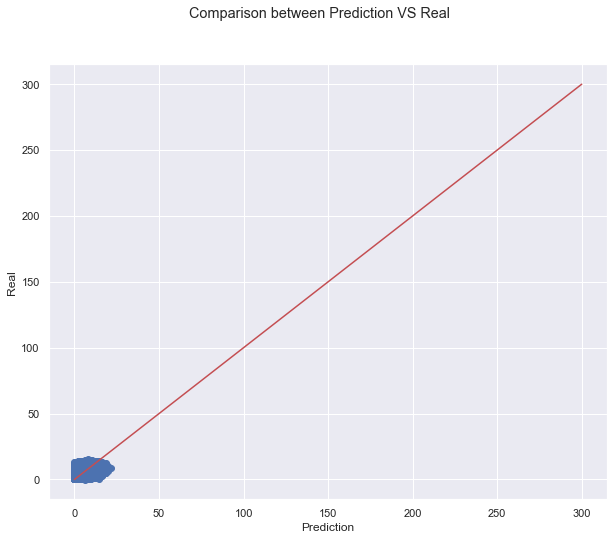

In [250]:
# 실제값과 예측값의 분포 비교
fig, axes = plt.subplots(1, 1, figsize=(10, 8), sharex=True, sharey=True)

# y=x를 그리기 위하여
x_range = np.linspace(0, 300, 1000)

# 예측/실제값 비교
axes.scatter(y_train, submission_prev )
axes.set_xlabel("Prediction")
axes.set_ylabel("Real")

# y=x 그리기
axes.plot(x_range, x_range, color='r');

# Super Title 
plt.suptitle('Comparison between Prediction VS Real');

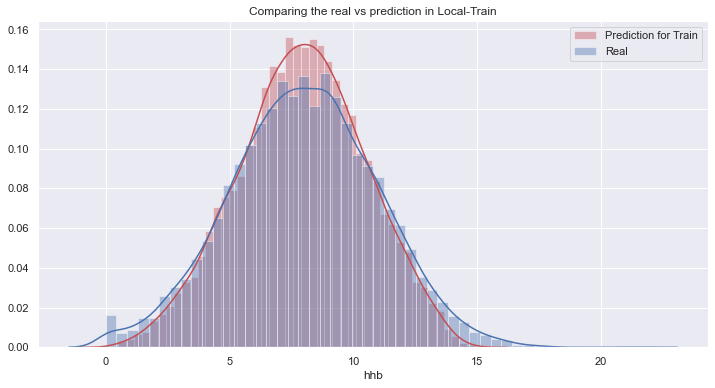

In [251]:
# 실제값 vs 예측값 비교

# hhb
plt.figure(figsize=(12,6))
sns.distplot(submission_prev['hhb'], color='r', label='Prediction for Train')
sns.distplot(y_train['hhb'], color='b', label='Real' )
plt.legend()
plt.title("Comparing the real vs prediction in Local-Train");

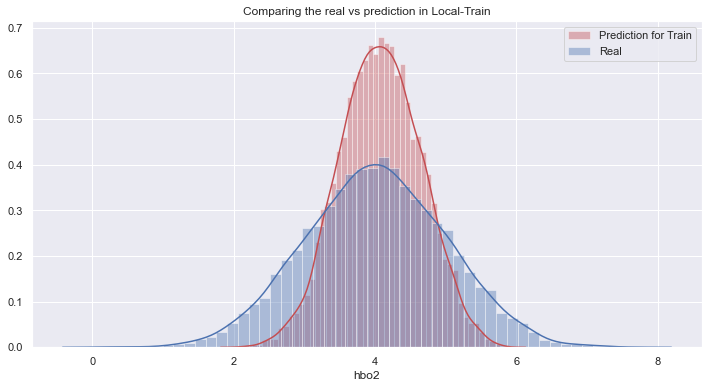

In [252]:
# 실제값 vs 예측값 비교

# hbo2
plt.figure(figsize=(12,6))
sns.distplot(submission_prev['hbo2'], color='r', label='Prediction for Train')
sns.distplot(y_train['hbo2'], color='b', label='Real' )
plt.legend()
plt.title("Comparing the real vs prediction in Local-Train");

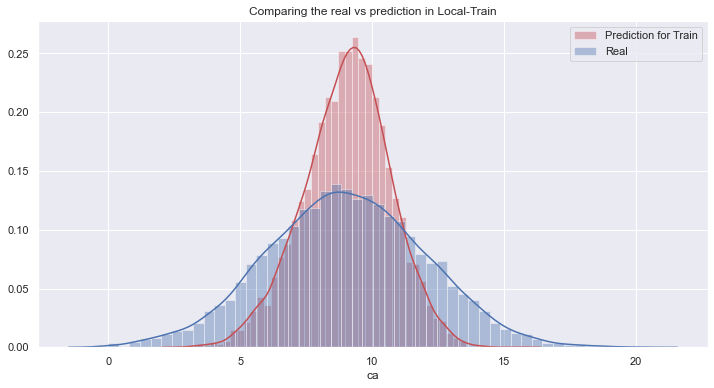

In [253]:
# 실제값 vs 예측값 비교

# ca
plt.figure(figsize=(12,6))
sns.distplot(submission_prev['ca'], color='r', label='Prediction for Train')
sns.distplot(y_train['ca'], color='b', label='Real' )
plt.legend()
plt.title("Comparing the real vs prediction in Local-Train");

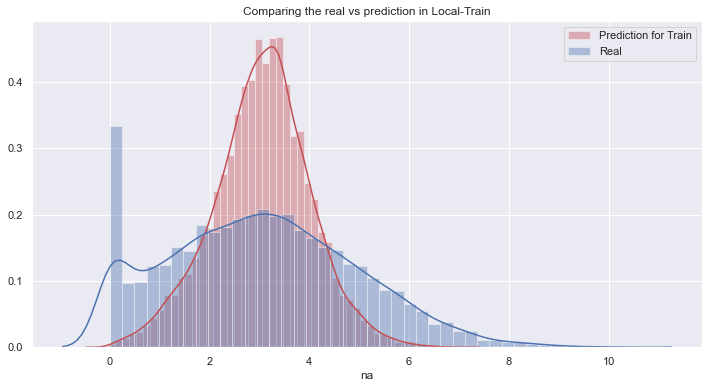

In [254]:
# 실제값 vs 예측값 비교

# na
plt.figure(figsize=(12,6))
sns.distplot(submission_prev['na'], color='r', label='Prediction for Train')
sns.distplot(y_train['na'], color='b', label='Real' )
plt.legend()
plt.title("Comparing the real vs prediction in Local-Train");